# **What about the minimum dataset for obtaining a satisfying fidelity?**

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation


In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [6]:
sim_bknd=Aer.get_backend('aer_simulator')

In [7]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## (In)Fidelity Implementation

In [8]:
def density_matrix_from_bloch_vector(bloch_vector):
   rho = 0.5 * (I+ bloch_vector[0]*X + bloch_vector[1]*Y + bloch_vector[2]*Z)
   return rho

In [9]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

In [10]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [11]:
A = tf.stack([X_tf,Y_tf,Z_tf]) 

In [12]:
@tf.function
def infidelity1(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   infidelity = 1 - fidelity
   return infidelity 

## Noise Models 


In [13]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [14]:
#BIT FLIP, PHASE FLIP AND BIT-PHASE FLIP ERROR

def flip_error(num_qubits, rho, error_type, p):

    E_0 = np.sqrt(1-p)*I
    if error_type == 'bit':
        E_1 = np.sqrt(p)*X
    if error_type == 'phase':
        E_1 = np.sqrt(p)*Z
    if error_type == 'bp':
        E_1 = np.sqrt(p)*Y
        
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## <font color='red'>MSE - 10 samples</font>

In [15]:
predictions_10 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:10], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:10], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
       ])
    
 
    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=loss_fn)
    

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    fid10_c = tf.math.reduce_mean(fidelities)
    fid10 = tf.cast(fid10_c, tf.float64)
    predictions_10.append(fid10)
print(predictions_10)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3345 - val_loss: 0.2981
Epoch 2/200
1/1 [==============================] - 0s 83ms/step - loss: 0.3190 - val_loss: 0.2882
Epoch 3/200
1/1 [==============================] - 0s 79ms/step - loss: 0.3049 - val_loss: 0.2786
Epoch 4/200
1/1 [==============================] - 0s 69ms/step - loss: 0.2916 - val_loss: 0.2694
Epoch 5/200
1/1 [==============================] - 0s 88ms/step - loss: 0.2787 - val_loss: 0.2606
Epoch 6/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2664 - val_loss: 0.2521
Epoch 7/200
1/1 [==============================] - 0s 90ms/step - loss: 0.2547 - val_loss: 0.2439
Epoch 8/200
1/1 [==============================] - 0s 77ms/step - loss: 0.2435 - val_loss: 0.2360
Epoch 9/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2328 - val_loss: 0.2283
Epoch 10/200
1/1 [==============================] - 0s 82ms/step - loss: 0.2223 - val_loss: 0.2209
Epoch 11/200
1/1 [===

1/1 [==============================] - 0s 85ms/step - loss: 6.7605e-04 - val_loss: 0.0080
Epoch 84/200
1/1 [==============================] - 0s 94ms/step - loss: 6.2145e-04 - val_loss: 0.0079
Epoch 85/200
1/1 [==============================] - 0s 102ms/step - loss: 5.7008e-04 - val_loss: 0.0078
Epoch 86/200
1/1 [==============================] - 0s 97ms/step - loss: 5.2213e-04 - val_loss: 0.0077
Epoch 87/200
1/1 [==============================] - 0s 86ms/step - loss: 4.7757e-04 - val_loss: 0.0077
Epoch 88/200
1/1 [==============================] - 0s 79ms/step - loss: 4.3630e-04 - val_loss: 0.0076
Epoch 89/200
1/1 [==============================] - 0s 101ms/step - loss: 3.9813e-04 - val_loss: 0.0076
Epoch 90/200
1/1 [==============================] - 0s 91ms/step - loss: 3.6283e-04 - val_loss: 0.0076
Epoch 91/200
1/1 [==============================] - 0s 106ms/step - loss: 3.3072e-04 - val_loss: 0.0075
Epoch 92/200
1/1 [==============================] - 0s 89ms/step - loss: 3.0137e-04

Epoch 162/200
1/1 [==============================] - 0s 76ms/step - loss: 1.3600e-05 - val_loss: 0.0067
Epoch 163/200
1/1 [==============================] - 0s 76ms/step - loss: 1.3113e-05 - val_loss: 0.0067
Epoch 164/200
1/1 [==============================] - 0s 74ms/step - loss: 1.2629e-05 - val_loss: 0.0067
Epoch 165/200
1/1 [==============================] - 0s 81ms/step - loss: 1.2161e-05 - val_loss: 0.0067
Epoch 166/200
1/1 [==============================] - 0s 72ms/step - loss: 1.1729e-05 - val_loss: 0.0066
Epoch 167/200
1/1 [==============================] - 0s 78ms/step - loss: 1.1332e-05 - val_loss: 0.0066
Epoch 168/200
1/1 [==============================] - 0s 69ms/step - loss: 1.0934e-05 - val_loss: 0.0066
Epoch 169/200
1/1 [==============================] - 0s 69ms/step - loss: 1.0532e-05 - val_loss: 0.0066
Epoch 170/200
1/1 [==============================] - 0s 72ms/step - loss: 1.0155e-05 - val_loss: 0.0066
Epoch 171/200
1/1 [==============================] - 0s 71ms/ste

1/1 [==============================] - 0s 81ms/step - loss: 0.0327 - val_loss: 0.0898
Epoch 43/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0295 - val_loss: 0.0871
Epoch 44/200
1/1 [==============================] - 0s 89ms/step - loss: 0.0266 - val_loss: 0.0844
Epoch 45/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0240 - val_loss: 0.0818
Epoch 46/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0215 - val_loss: 0.0793
Epoch 47/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0193 - val_loss: 0.0767
Epoch 48/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0172 - val_loss: 0.0742
Epoch 49/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0154 - val_loss: 0.0717
Epoch 50/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0137 - val_loss: 0.0692
Epoch 51/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0122 - val_loss: 0.0668
Epoch 52/200
1/1 [=====

1/1 [==============================] - 0s 73ms/step - loss: 7.3989e-05 - val_loss: 0.0219
Epoch 123/200
1/1 [==============================] - 0s 75ms/step - loss: 7.0716e-05 - val_loss: 0.0218
Epoch 124/200
1/1 [==============================] - 0s 76ms/step - loss: 6.7642e-05 - val_loss: 0.0217
Epoch 125/200
1/1 [==============================] - 0s 71ms/step - loss: 6.4778e-05 - val_loss: 0.0217
Epoch 126/200
1/1 [==============================] - 0s 96ms/step - loss: 6.2148e-05 - val_loss: 0.0216
Epoch 127/200
1/1 [==============================] - 0s 96ms/step - loss: 5.9726e-05 - val_loss: 0.0216
Epoch 128/200
1/1 [==============================] - 0s 92ms/step - loss: 5.7496e-05 - val_loss: 0.0215
Epoch 129/200
1/1 [==============================] - 0s 69ms/step - loss: 5.5437e-05 - val_loss: 0.0214
Epoch 130/200
1/1 [==============================] - 0s 70ms/step - loss: 5.3542e-05 - val_loss: 0.0214
Epoch 131/200
1/1 [==============================] - 0s 74ms/step - loss: 5.18

1/1 - 0s - loss: 0.0041 - 250ms/epoch - 250ms/step
Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.3809 - val_loss: 0.3523
Epoch 2/200
1/1 [==============================] - 0s 94ms/step - loss: 0.3637 - val_loss: 0.3409
Epoch 3/200
1/1 [==============================] - 0s 74ms/step - loss: 0.3471 - val_loss: 0.3301
Epoch 4/200
1/1 [==============================] - 0s 87ms/step - loss: 0.3313 - val_loss: 0.3196
Epoch 5/200
1/1 [==============================] - 0s 79ms/step - loss: 0.3161 - val_loss: 0.3098
Epoch 6/200
1/1 [==============================] - 0s 71ms/step - loss: 0.3015 - val_loss: 0.3005
Epoch 7/200
1/1 [==============================] - 0s 69ms/step - loss: 0.2878 - val_loss: 0.2916
Epoch 8/200
1/1 [==============================] - 0s 85ms/step - loss: 0.2750 - val_loss: 0.2831
Epoch 9/200
1/1 [==============================] - 0s 87ms/step - loss: 0.2630 - val_loss: 0.2748
Epoch 10/200
1/1 [==============================] - 0s 79ms/step - lo

1/1 [==============================] - 0s 82ms/step - loss: 0.0022 - val_loss: 0.0107
Epoch 84/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0021 - val_loss: 0.0102
Epoch 85/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0019 - val_loss: 0.0098
Epoch 86/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0018 - val_loss: 0.0094
Epoch 87/200
1/1 [==============================] - 0s 95ms/step - loss: 0.0017 - val_loss: 0.0090
Epoch 88/200
1/1 [==============================] - 0s 92ms/step - loss: 0.0016 - val_loss: 0.0087
Epoch 89/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0015 - val_loss: 0.0084
Epoch 90/200
1/1 [==============================] - 0s 95ms/step - loss: 0.0014 - val_loss: 0.0081
Epoch 91/200
1/1 [==============================] - 0s 92ms/step - loss: 0.0013 - val_loss: 0.0078
Epoch 92/200
1/1 [==============================] - 0s 121ms/step - loss: 0.0013 - val_loss: 0.0076
Epoch 93/200
1/1 [===

1/1 [==============================] - 0s 81ms/step - loss: 2.6519e-05 - val_loss: 0.0045
Epoch 163/200
1/1 [==============================] - 0s 91ms/step - loss: 2.5194e-05 - val_loss: 0.0045
Epoch 164/200
1/1 [==============================] - 0s 92ms/step - loss: 2.3939e-05 - val_loss: 0.0045
Epoch 165/200
1/1 [==============================] - 0s 102ms/step - loss: 2.2762e-05 - val_loss: 0.0045
Epoch 166/200
1/1 [==============================] - 0s 95ms/step - loss: 2.1628e-05 - val_loss: 0.0045
Epoch 167/200
1/1 [==============================] - 0s 89ms/step - loss: 2.0543e-05 - val_loss: 0.0045
Epoch 168/200
1/1 [==============================] - 0s 86ms/step - loss: 1.9505e-05 - val_loss: 0.0044
Epoch 169/200
1/1 [==============================] - 0s 73ms/step - loss: 1.8513e-05 - val_loss: 0.0044
Epoch 170/200
1/1 [==============================] - 0s 88ms/step - loss: 1.7620e-05 - val_loss: 0.0044
Epoch 171/200
1/1 [==============================] - 0s 84ms/step - loss: 1.6

1/1 [==============================] - 0s 63ms/step - loss: 0.0524 - val_loss: 0.0858
Epoch 43/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0487 - val_loss: 0.0820
Epoch 44/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0452 - val_loss: 0.0785
Epoch 45/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0419 - val_loss: 0.0751
Epoch 46/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0388 - val_loss: 0.0720
Epoch 47/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0359 - val_loss: 0.0690
Epoch 48/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0331 - val_loss: 0.0662
Epoch 49/200
1/1 [==============================] - 0s 64ms/step - loss: 0.0306 - val_loss: 0.0636
Epoch 50/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0282 - val_loss: 0.0611
Epoch 51/200
1/1 [==============================] - 0s 62ms/step - loss: 0.0259 - val_loss: 0.0588
Epoch 52/200
1/1 [=====

1/1 [==============================] - 0s 102ms/step - loss: 1.5423e-04 - val_loss: 0.0171
Epoch 124/200
1/1 [==============================] - 0s 69ms/step - loss: 1.5073e-04 - val_loss: 0.0171
Epoch 125/200
1/1 [==============================] - 0s 64ms/step - loss: 1.4736e-04 - val_loss: 0.0171
Epoch 126/200
1/1 [==============================] - 0s 79ms/step - loss: 1.4413e-04 - val_loss: 0.0171
Epoch 127/200
1/1 [==============================] - 0s 84ms/step - loss: 1.4102e-04 - val_loss: 0.0170
Epoch 128/200
1/1 [==============================] - 0s 80ms/step - loss: 1.3804e-04 - val_loss: 0.0170
Epoch 129/200
1/1 [==============================] - 0s 67ms/step - loss: 1.3518e-04 - val_loss: 0.0170
Epoch 130/200
1/1 [==============================] - 0s 70ms/step - loss: 1.3243e-04 - val_loss: 0.0170
Epoch 131/200
1/1 [==============================] - 0s 70ms/step - loss: 1.2983e-04 - val_loss: 0.0169
Epoch 132/200
1/1 [==============================] - 0s 66ms/step - loss: 1.2

1/1 [==============================] - 2s 2s/step - loss: 0.3659 - val_loss: 0.3432
Epoch 2/200
1/1 [==============================] - 0s 65ms/step - loss: 0.3503 - val_loss: 0.3323
Epoch 3/200
1/1 [==============================] - 0s 68ms/step - loss: 0.3353 - val_loss: 0.3218
Epoch 4/200
1/1 [==============================] - 0s 69ms/step - loss: 0.3211 - val_loss: 0.3118
Epoch 5/200
1/1 [==============================] - 0s 68ms/step - loss: 0.3076 - val_loss: 0.3021
Epoch 6/200
1/1 [==============================] - 0s 62ms/step - loss: 0.2947 - val_loss: 0.2927
Epoch 7/200
1/1 [==============================] - 0s 64ms/step - loss: 0.2824 - val_loss: 0.2837
Epoch 8/200
1/1 [==============================] - 0s 63ms/step - loss: 0.2705 - val_loss: 0.2751
Epoch 9/200
1/1 [==============================] - 0s 62ms/step - loss: 0.2592 - val_loss: 0.2667
Epoch 10/200
1/1 [==============================] - 0s 68ms/step - loss: 0.2486 - val_loss: 0.2585
Epoch 11/200
1/1 [===============

Epoch 84/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0035 - val_loss: 0.0321
Epoch 85/200
1/1 [==============================] - 0s 97ms/step - loss: 0.0033 - val_loss: 0.0313
Epoch 86/200
1/1 [==============================] - 0s 108ms/step - loss: 0.0031 - val_loss: 0.0306
Epoch 87/200
1/1 [==============================] - 0s 113ms/step - loss: 0.0029 - val_loss: 0.0298
Epoch 88/200
1/1 [==============================] - 0s 113ms/step - loss: 0.0027 - val_loss: 0.0291
Epoch 89/200
1/1 [==============================] - 0s 110ms/step - loss: 0.0025 - val_loss: 0.0284
Epoch 90/200
1/1 [==============================] - 0s 125ms/step - loss: 0.0023 - val_loss: 0.0277
Epoch 91/200
1/1 [==============================] - 0s 94ms/step - loss: 0.0021 - val_loss: 0.0271
Epoch 92/200
1/1 [==============================] - 0s 120ms/step - loss: 0.0020 - val_loss: 0.0265
Epoch 93/200
1/1 [==============================] - 0s 125ms/step - loss: 0.0018 - val_loss: 0.0260
Epo

Epoch 163/200
1/1 [==============================] - 0s 95ms/step - loss: 4.6304e-05 - val_loss: 0.0197
Epoch 164/200
1/1 [==============================] - 0s 94ms/step - loss: 4.5167e-05 - val_loss: 0.0197
Epoch 165/200
1/1 [==============================] - 0s 111ms/step - loss: 4.4062e-05 - val_loss: 0.0197
Epoch 166/200
1/1 [==============================] - 0s 108ms/step - loss: 4.2989e-05 - val_loss: 0.0197
Epoch 167/200
1/1 [==============================] - 0s 102ms/step - loss: 4.1943e-05 - val_loss: 0.0197
Epoch 168/200
1/1 [==============================] - 0s 112ms/step - loss: 4.0922e-05 - val_loss: 0.0196
Epoch 169/200
1/1 [==============================] - 0s 127ms/step - loss: 3.9927e-05 - val_loss: 0.0196
Epoch 170/200
1/1 [==============================] - 0s 120ms/step - loss: 3.8960e-05 - val_loss: 0.0196
Epoch 171/200
1/1 [==============================] - 0s 113ms/step - loss: 3.8072e-05 - val_loss: 0.0196
Epoch 172/200
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 77ms/step - loss: 0.0379 - val_loss: 0.1082
Epoch 44/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0345 - val_loss: 0.1039
Epoch 45/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0313 - val_loss: 0.0998
Epoch 46/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0283 - val_loss: 0.0958
Epoch 47/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0255 - val_loss: 0.0919
Epoch 48/200
1/1 [==============================] - 0s 74ms/step - loss: 0.0228 - val_loss: 0.0882
Epoch 49/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0204 - val_loss: 0.0845
Epoch 50/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0181 - val_loss: 0.0811
Epoch 51/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0160 - val_loss: 0.0778
Epoch 52/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0140 - val_loss: 0.0746
Epoch 53/200
1/1 [=====

1/1 [==============================] - 0s 76ms/step - loss: 2.4420e-04 - val_loss: 0.0301
Epoch 125/200
1/1 [==============================] - 0s 71ms/step - loss: 2.3889e-04 - val_loss: 0.0300
Epoch 126/200
1/1 [==============================] - 0s 76ms/step - loss: 2.3372e-04 - val_loss: 0.0299
Epoch 127/200
1/1 [==============================] - 0s 77ms/step - loss: 2.2876e-04 - val_loss: 0.0299
Epoch 128/200
1/1 [==============================] - 0s 70ms/step - loss: 2.2396e-04 - val_loss: 0.0298
Epoch 129/200
1/1 [==============================] - 0s 71ms/step - loss: 2.1936e-04 - val_loss: 0.0297
Epoch 130/200
1/1 [==============================] - 0s 84ms/step - loss: 2.1490e-04 - val_loss: 0.0296
Epoch 131/200
1/1 [==============================] - 0s 78ms/step - loss: 2.1060e-04 - val_loss: 0.0295
Epoch 132/200
1/1 [==============================] - 0s 75ms/step - loss: 2.0652e-04 - val_loss: 0.0294
Epoch 133/200
1/1 [==============================] - 0s 72ms/step - loss: 2.02

1/1 [==============================] - 0s 86ms/step - loss: 0.3459 - val_loss: 0.3145
Epoch 3/200
1/1 [==============================] - 0s 80ms/step - loss: 0.3304 - val_loss: 0.3067
Epoch 4/200
1/1 [==============================] - 0s 88ms/step - loss: 0.3158 - val_loss: 0.2994
Epoch 5/200
1/1 [==============================] - 0s 73ms/step - loss: 0.3023 - val_loss: 0.2926
Epoch 6/200
1/1 [==============================] - 0s 68ms/step - loss: 0.2895 - val_loss: 0.2861
Epoch 7/200
1/1 [==============================] - 0s 73ms/step - loss: 0.2772 - val_loss: 0.2799
Epoch 8/200
1/1 [==============================] - 0s 68ms/step - loss: 0.2653 - val_loss: 0.2739
Epoch 9/200
1/1 [==============================] - 0s 75ms/step - loss: 0.2539 - val_loss: 0.2681
Epoch 10/200
1/1 [==============================] - 0s 70ms/step - loss: 0.2429 - val_loss: 0.2625
Epoch 11/200
1/1 [==============================] - 0s 69ms/step - loss: 0.2322 - val_loss: 0.2572
Epoch 12/200
1/1 [============

1/1 [==============================] - 0s 70ms/step - loss: 8.0609e-04 - val_loss: 0.0565
Epoch 85/200
1/1 [==============================] - 0s 74ms/step - loss: 7.7523e-04 - val_loss: 0.0565
Epoch 86/200
1/1 [==============================] - 0s 86ms/step - loss: 7.4158e-04 - val_loss: 0.0566
Epoch 87/200
1/1 [==============================] - 0s 92ms/step - loss: 7.0307e-04 - val_loss: 0.0567
Epoch 88/200
1/1 [==============================] - 0s 86ms/step - loss: 6.6262e-04 - val_loss: 0.0569
Epoch 89/200
1/1 [==============================] - 0s 103ms/step - loss: 6.2134e-04 - val_loss: 0.0570
Epoch 90/200
1/1 [==============================] - 0s 72ms/step - loss: 5.8012e-04 - val_loss: 0.0572
Epoch 91/200
1/1 [==============================] - 0s 69ms/step - loss: 5.3989e-04 - val_loss: 0.0574
Epoch 92/200
1/1 [==============================] - 0s 67ms/step - loss: 5.0144e-04 - val_loss: 0.0577
Epoch 93/200
1/1 [==============================] - 0s 67ms/step - loss: 4.6539e-04 -

1/1 [==============================] - 0s 69ms/step - loss: 6.7671e-05 - val_loss: 0.0528
Epoch 164/200
1/1 [==============================] - 0s 70ms/step - loss: 6.6601e-05 - val_loss: 0.0527
Epoch 165/200
1/1 [==============================] - 0s 71ms/step - loss: 6.5502e-05 - val_loss: 0.0527
Epoch 166/200
1/1 [==============================] - 0s 71ms/step - loss: 6.4381e-05 - val_loss: 0.0526
Epoch 167/200
1/1 [==============================] - 0s 70ms/step - loss: 6.3250e-05 - val_loss: 0.0525
Epoch 168/200
1/1 [==============================] - 0s 73ms/step - loss: 6.2122e-05 - val_loss: 0.0525
Epoch 169/200
1/1 [==============================] - 0s 71ms/step - loss: 6.1004e-05 - val_loss: 0.0524
Epoch 170/200
1/1 [==============================] - 0s 88ms/step - loss: 6.0111e-05 - val_loss: 0.0523
Epoch 171/200
1/1 [==============================] - 0s 84ms/step - loss: 5.9210e-05 - val_loss: 0.0523
Epoch 172/200
1/1 [==============================] - 0s 80ms/step - loss: 5.81

1/1 [==============================] - 0s 116ms/step - loss: 0.0229 - val_loss: 0.1057
Epoch 44/200
1/1 [==============================] - 0s 105ms/step - loss: 0.0211 - val_loss: 0.1007
Epoch 45/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0195 - val_loss: 0.0959
Epoch 46/200
1/1 [==============================] - 0s 100ms/step - loss: 0.0179 - val_loss: 0.0912
Epoch 47/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0164 - val_loss: 0.0866
Epoch 48/200
1/1 [==============================] - 0s 92ms/step - loss: 0.0150 - val_loss: 0.0822
Epoch 49/200
1/1 [==============================] - 0s 94ms/step - loss: 0.0137 - val_loss: 0.0780
Epoch 50/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0126 - val_loss: 0.0740
Epoch 51/200
1/1 [==============================] - 0s 94ms/step - loss: 0.0114 - val_loss: 0.0702
Epoch 52/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0104 - val_loss: 0.0665
Epoch 53/200
1/1 [=

Epoch 124/200
1/1 [==============================] - 0s 65ms/step - loss: 2.1854e-04 - val_loss: 0.0267
Epoch 125/200
1/1 [==============================] - 0s 72ms/step - loss: 2.1134e-04 - val_loss: 0.0267
Epoch 126/200
1/1 [==============================] - 0s 85ms/step - loss: 2.0441e-04 - val_loss: 0.0266
Epoch 127/200
1/1 [==============================] - 0s 89ms/step - loss: 1.9764e-04 - val_loss: 0.0265
Epoch 128/200
1/1 [==============================] - 0s 83ms/step - loss: 1.9103e-04 - val_loss: 0.0265
Epoch 129/200
1/1 [==============================] - 0s 76ms/step - loss: 1.8472e-04 - val_loss: 0.0264
Epoch 130/200
1/1 [==============================] - 0s 75ms/step - loss: 1.7879e-04 - val_loss: 0.0263
Epoch 131/200
1/1 [==============================] - 0s 68ms/step - loss: 1.7335e-04 - val_loss: 0.0263
Epoch 132/200
1/1 [==============================] - 0s 81ms/step - loss: 1.6795e-04 - val_loss: 0.0262
Epoch 133/200
1/1 [==============================] - 0s 70ms/ste

1/1 [==============================] - 0s 84ms/step - loss: 0.3159 - val_loss: 0.3186
Epoch 3/200
1/1 [==============================] - 0s 84ms/step - loss: 0.3048 - val_loss: 0.3086
Epoch 4/200
1/1 [==============================] - 0s 81ms/step - loss: 0.2939 - val_loss: 0.2989
Epoch 5/200
1/1 [==============================] - 0s 70ms/step - loss: 0.2832 - val_loss: 0.2894
Epoch 6/200
1/1 [==============================] - 0s 75ms/step - loss: 0.2728 - val_loss: 0.2801
Epoch 7/200
1/1 [==============================] - 0s 74ms/step - loss: 0.2625 - val_loss: 0.2712
Epoch 8/200
1/1 [==============================] - 0s 69ms/step - loss: 0.2525 - val_loss: 0.2625
Epoch 9/200
1/1 [==============================] - 0s 70ms/step - loss: 0.2428 - val_loss: 0.2540
Epoch 10/200
1/1 [==============================] - 0s 70ms/step - loss: 0.2333 - val_loss: 0.2459
Epoch 11/200
1/1 [==============================] - 0s 85ms/step - loss: 0.2243 - val_loss: 0.2380
Epoch 12/200
1/1 [============

Epoch 85/200
1/1 [==============================] - 0s 69ms/step - loss: 6.9219e-04 - val_loss: 0.0086
Epoch 86/200
1/1 [==============================] - 0s 76ms/step - loss: 6.4190e-04 - val_loss: 0.0086
Epoch 87/200
1/1 [==============================] - 0s 66ms/step - loss: 5.9689e-04 - val_loss: 0.0086
Epoch 88/200
1/1 [==============================] - 0s 71ms/step - loss: 5.5524e-04 - val_loss: 0.0086
Epoch 89/200
1/1 [==============================] - 0s 72ms/step - loss: 5.1709e-04 - val_loss: 0.0086
Epoch 90/200
1/1 [==============================] - 0s 70ms/step - loss: 4.8261e-04 - val_loss: 0.0085
Epoch 91/200
1/1 [==============================] - 0s 73ms/step - loss: 4.5127e-04 - val_loss: 0.0086
Epoch 92/200
1/1 [==============================] - 0s 71ms/step - loss: 4.2290e-04 - val_loss: 0.0086
Epoch 93/200
1/1 [==============================] - 0s 72ms/step - loss: 3.9755e-04 - val_loss: 0.0086
Epoch 94/200
1/1 [==============================] - 0s 78ms/step - loss: 

Epoch 164/200
1/1 [==============================] - 0s 71ms/step - loss: 3.2617e-05 - val_loss: 0.0074
Epoch 165/200
1/1 [==============================] - 0s 71ms/step - loss: 3.1865e-05 - val_loss: 0.0074
Epoch 166/200
1/1 [==============================] - 0s 80ms/step - loss: 3.1164e-05 - val_loss: 0.0074
Epoch 167/200
1/1 [==============================] - 0s 72ms/step - loss: 3.0545e-05 - val_loss: 0.0074
Epoch 168/200
1/1 [==============================] - 0s 74ms/step - loss: 2.9944e-05 - val_loss: 0.0074
Epoch 169/200
1/1 [==============================] - 0s 80ms/step - loss: 2.9359e-05 - val_loss: 0.0074
Epoch 170/200
1/1 [==============================] - 0s 73ms/step - loss: 2.8790e-05 - val_loss: 0.0074
Epoch 171/200
1/1 [==============================] - 0s 88ms/step - loss: 2.8240e-05 - val_loss: 0.0074
Epoch 172/200
1/1 [==============================] - 0s 75ms/step - loss: 2.7704e-05 - val_loss: 0.0073
Epoch 173/200
1/1 [==============================] - 0s 74ms/ste

1/1 [==============================] - 0s 68ms/step - loss: 0.0341 - val_loss: 0.0793
Epoch 45/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0309 - val_loss: 0.0754
Epoch 46/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0280 - val_loss: 0.0717
Epoch 47/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0252 - val_loss: 0.0682
Epoch 48/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0227 - val_loss: 0.0649
Epoch 49/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0204 - val_loss: 0.0617
Epoch 50/200
1/1 [==============================] - 0s 85ms/step - loss: 0.0183 - val_loss: 0.0587
Epoch 51/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0164 - val_loss: 0.0559
Epoch 52/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0147 - val_loss: 0.0532
Epoch 53/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0132 - val_loss: 0.0507
Epoch 54/200
1/1 [=====

1/1 [==============================] - 0s 110ms/step - loss: 2.6876e-05 - val_loss: 0.0130
Epoch 125/200
1/1 [==============================] - 0s 71ms/step - loss: 2.6213e-05 - val_loss: 0.0130
Epoch 126/200
1/1 [==============================] - 0s 79ms/step - loss: 2.5525e-05 - val_loss: 0.0130
Epoch 127/200
1/1 [==============================] - 0s 77ms/step - loss: 2.4808e-05 - val_loss: 0.0130
Epoch 128/200
1/1 [==============================] - 0s 65ms/step - loss: 2.4071e-05 - val_loss: 0.0129
Epoch 129/200
1/1 [==============================] - 0s 65ms/step - loss: 2.3331e-05 - val_loss: 0.0129
Epoch 130/200
1/1 [==============================] - 0s 69ms/step - loss: 2.2603e-05 - val_loss: 0.0129
Epoch 131/200
1/1 [==============================] - 0s 70ms/step - loss: 2.1901e-05 - val_loss: 0.0129
Epoch 132/200
1/1 [==============================] - 0s 67ms/step - loss: 2.1216e-05 - val_loss: 0.0129
Epoch 133/200
1/1 [==============================] - 0s 70ms/step - loss: 2.0

## <font color='red'>MSE - 5 samples</font>

In [16]:
predictions_5 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:5], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:5], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
       ])
    
 
    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=loss_fn)
    

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=5, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    fid5_c = tf.math.reduce_mean(fidelities)
    fid5 = tf.cast(fid5_c, tf.float64)
    predictions_5.append(fid5)
print(predictions_5)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.4089 - val_loss: 0.3511
Epoch 2/200
1/1 [==============================] - 0s 97ms/step - loss: 0.3799 - val_loss: 0.3447
Epoch 3/200
1/1 [==============================] - 0s 83ms/step - loss: 0.3527 - val_loss: 0.3387
Epoch 4/200
1/1 [==============================] - 0s 94ms/step - loss: 0.3277 - val_loss: 0.3333
Epoch 5/200
1/1 [==============================] - 0s 94ms/step - loss: 0.3046 - val_loss: 0.3283
Epoch 6/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2830 - val_loss: 0.3239
Epoch 7/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2626 - val_loss: 0.3197
Epoch 8/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2439 - val_loss: 0.3161
Epoch 9/200
1/1 [==============================] - 0s 83ms/step - loss: 0.2265 - val_loss: 0.3128
Epoch 10/200
1/1 [==============================] - 0s 92ms/step - loss: 0.2103 - val_loss: 0.3098
Epoch 11/200
1/1 [===

1/1 [==============================] - 0s 78ms/step - loss: 7.0479e-04 - val_loss: 0.2100
Epoch 84/200
1/1 [==============================] - 0s 86ms/step - loss: 6.6069e-04 - val_loss: 0.2098
Epoch 85/200
1/1 [==============================] - 0s 81ms/step - loss: 6.2213e-04 - val_loss: 0.2096
Epoch 86/200
1/1 [==============================] - 0s 94ms/step - loss: 5.8835e-04 - val_loss: 0.2094
Epoch 87/200
1/1 [==============================] - 0s 88ms/step - loss: 5.5807e-04 - val_loss: 0.2092
Epoch 88/200
1/1 [==============================] - 0s 83ms/step - loss: 5.3075e-04 - val_loss: 0.2090
Epoch 89/200
1/1 [==============================] - 0s 81ms/step - loss: 5.0714e-04 - val_loss: 0.2089
Epoch 90/200
1/1 [==============================] - 0s 85ms/step - loss: 4.8804e-04 - val_loss: 0.2087
Epoch 91/200
1/1 [==============================] - 0s 82ms/step - loss: 4.7111e-04 - val_loss: 0.2086
Epoch 92/200
1/1 [==============================] - 0s 83ms/step - loss: 4.5556e-04 - 

1/1 [==============================] - 0s 76ms/step - loss: 1.4042e-04 - val_loss: 0.2053
Epoch 163/200
1/1 [==============================] - 0s 108ms/step - loss: 1.3942e-04 - val_loss: 0.2053
Epoch 164/200
1/1 [==============================] - 0s 82ms/step - loss: 1.3843e-04 - val_loss: 0.2052
Epoch 165/200
1/1 [==============================] - 0s 76ms/step - loss: 1.3746e-04 - val_loss: 0.2052
Epoch 166/200
1/1 [==============================] - 0s 98ms/step - loss: 1.3650e-04 - val_loss: 0.2051
Epoch 167/200
1/1 [==============================] - 0s 85ms/step - loss: 1.3555e-04 - val_loss: 0.2051
Epoch 168/200
1/1 [==============================] - 0s 83ms/step - loss: 1.3462e-04 - val_loss: 0.2051
Epoch 169/200
1/1 [==============================] - 0s 94ms/step - loss: 1.3370e-04 - val_loss: 0.2050
Epoch 170/200
1/1 [==============================] - 0s 74ms/step - loss: 1.3279e-04 - val_loss: 0.2050
Epoch 171/200
1/1 [==============================] - 0s 75ms/step - loss: 1.3

1/1 [==============================] - 0s 86ms/step - loss: 0.0578 - val_loss: 0.1516
Epoch 43/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0541 - val_loss: 0.1470
Epoch 44/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0506 - val_loss: 0.1424
Epoch 45/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0472 - val_loss: 0.1379
Epoch 46/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0441 - val_loss: 0.1336
Epoch 47/200
1/1 [==============================] - 0s 103ms/step - loss: 0.0410 - val_loss: 0.1293
Epoch 48/200
1/1 [==============================] - 0s 94ms/step - loss: 0.0382 - val_loss: 0.1251
Epoch 49/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0355 - val_loss: 0.1211
Epoch 50/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0329 - val_loss: 0.1171
Epoch 51/200
1/1 [==============================] - 0s 87ms/step - loss: 0.0305 - val_loss: 0.1133
Epoch 52/200
1/1 [====

1/1 [==============================] - 0s 81ms/step - loss: 8.7076e-05 - val_loss: 0.0395
Epoch 124/200
1/1 [==============================] - 0s 75ms/step - loss: 8.1410e-05 - val_loss: 0.0395
Epoch 125/200
1/1 [==============================] - 0s 82ms/step - loss: 7.5951e-05 - val_loss: 0.0395
Epoch 126/200
1/1 [==============================] - 0s 89ms/step - loss: 7.0727e-05 - val_loss: 0.0394
Epoch 127/200
1/1 [==============================] - 0s 84ms/step - loss: 6.5783e-05 - val_loss: 0.0393
Epoch 128/200
1/1 [==============================] - 0s 80ms/step - loss: 6.1067e-05 - val_loss: 0.0393
Epoch 129/200
1/1 [==============================] - 0s 86ms/step - loss: 5.6588e-05 - val_loss: 0.0392
Epoch 130/200
1/1 [==============================] - 0s 89ms/step - loss: 5.2604e-05 - val_loss: 0.0392
Epoch 131/200
1/1 [==============================] - 0s 79ms/step - loss: 4.8792e-05 - val_loss: 0.0391
Epoch 132/200
1/1 [==============================] - 0s 94ms/step - loss: 4.49

1/1 [==============================] - 1s 1s/step - loss: 0.3329 - val_loss: 0.3341
Epoch 2/200
1/1 [==============================] - 0s 80ms/step - loss: 0.3194 - val_loss: 0.3299
Epoch 3/200
1/1 [==============================] - 0s 80ms/step - loss: 0.3068 - val_loss: 0.3258
Epoch 4/200
1/1 [==============================] - 0s 80ms/step - loss: 0.2943 - val_loss: 0.3216
Epoch 5/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2823 - val_loss: 0.3178
Epoch 6/200
1/1 [==============================] - 0s 117ms/step - loss: 0.2706 - val_loss: 0.3140
Epoch 7/200
1/1 [==============================] - 0s 90ms/step - loss: 0.2593 - val_loss: 0.3104
Epoch 8/200
1/1 [==============================] - 0s 75ms/step - loss: 0.2482 - val_loss: 0.3069
Epoch 9/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2375 - val_loss: 0.3036
Epoch 10/200
1/1 [==============================] - 0s 77ms/step - loss: 0.2272 - val_loss: 0.3004
Epoch 11/200
1/1 [==============

Epoch 84/200
1/1 [==============================] - 0s 91ms/step - loss: 0.0016 - val_loss: 0.1666
Epoch 85/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0014 - val_loss: 0.1650
Epoch 86/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0013 - val_loss: 0.1635
Epoch 87/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0011 - val_loss: 0.1621
Epoch 88/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0010 - val_loss: 0.1608
Epoch 89/200
1/1 [==============================] - 0s 91ms/step - loss: 8.8268e-04 - val_loss: 0.1596
Epoch 90/200
1/1 [==============================] - 0s 93ms/step - loss: 7.7641e-04 - val_loss: 0.1585
Epoch 91/200
1/1 [==============================] - 0s 100ms/step - loss: 6.8139e-04 - val_loss: 0.1575
Epoch 92/200
1/1 [==============================] - 0s 71ms/step - loss: 5.9712e-04 - val_loss: 0.1566
Epoch 93/200
1/1 [==============================] - 0s 75ms/step - loss: 5.2319e-04 - val_lo

1/1 [==============================] - 0s 75ms/step - loss: 5.4501e-06 - val_loss: 0.1442
Epoch 164/200
1/1 [==============================] - 0s 78ms/step - loss: 5.1644e-06 - val_loss: 0.1442
Epoch 165/200
1/1 [==============================] - 0s 86ms/step - loss: 4.8937e-06 - val_loss: 0.1442
Epoch 166/200
1/1 [==============================] - 0s 81ms/step - loss: 4.6369e-06 - val_loss: 0.1442
Epoch 167/200
1/1 [==============================] - 0s 77ms/step - loss: 4.3938e-06 - val_loss: 0.1442
Epoch 168/200
1/1 [==============================] - 0s 78ms/step - loss: 4.1644e-06 - val_loss: 0.1442
Epoch 169/200
1/1 [==============================] - 0s 78ms/step - loss: 3.9476e-06 - val_loss: 0.1442
Epoch 170/200
1/1 [==============================] - 0s 78ms/step - loss: 3.7427e-06 - val_loss: 0.1442
Epoch 171/200
1/1 [==============================] - 0s 76ms/step - loss: 3.5512e-06 - val_loss: 0.1442
Epoch 172/200
1/1 [==============================] - 0s 84ms/step - loss: 3.37

1/1 [==============================] - 0s 79ms/step - loss: 0.0363 - val_loss: 0.1110
Epoch 44/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0344 - val_loss: 0.1089
Epoch 45/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0325 - val_loss: 0.1066
Epoch 46/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0307 - val_loss: 0.1044
Epoch 47/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0290 - val_loss: 0.1020
Epoch 48/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0274 - val_loss: 0.0996
Epoch 49/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0257 - val_loss: 0.0971
Epoch 50/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0242 - val_loss: 0.0946
Epoch 51/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0227 - val_loss: 0.0920
Epoch 52/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0212 - val_loss: 0.0895
Epoch 53/200
1/1 [=====

1/1 [==============================] - 0s 110ms/step - loss: 1.2269e-05 - val_loss: 0.0377
Epoch 125/200
1/1 [==============================] - 0s 88ms/step - loss: 1.1273e-05 - val_loss: 0.0377
Epoch 126/200
1/1 [==============================] - 0s 114ms/step - loss: 1.0317e-05 - val_loss: 0.0377
Epoch 127/200
1/1 [==============================] - 0s 95ms/step - loss: 9.4113e-06 - val_loss: 0.0377
Epoch 128/200
1/1 [==============================] - 0s 75ms/step - loss: 8.5550e-06 - val_loss: 0.0377
Epoch 129/200
1/1 [==============================] - 0s 82ms/step - loss: 7.7475e-06 - val_loss: 0.0377
Epoch 130/200
1/1 [==============================] - 0s 81ms/step - loss: 6.9878e-06 - val_loss: 0.0377
Epoch 131/200
1/1 [==============================] - 0s 94ms/step - loss: 6.2744e-06 - val_loss: 0.0377
Epoch 132/200
1/1 [==============================] - 0s 80ms/step - loss: 5.6050e-06 - val_loss: 0.0377
Epoch 133/200
1/1 [==============================] - 0s 80ms/step - loss: 4.

1/1 [==============================] - 0s 97ms/step - loss: 0.3240 - val_loss: 0.3278
Epoch 3/200
1/1 [==============================] - 0s 95ms/step - loss: 0.3072 - val_loss: 0.3205
Epoch 4/200
1/1 [==============================] - 0s 87ms/step - loss: 0.2910 - val_loss: 0.3136
Epoch 5/200
1/1 [==============================] - 0s 85ms/step - loss: 0.2756 - val_loss: 0.3070
Epoch 6/200
1/1 [==============================] - 0s 94ms/step - loss: 0.2607 - val_loss: 0.3007
Epoch 7/200
1/1 [==============================] - 0s 85ms/step - loss: 0.2462 - val_loss: 0.2948
Epoch 8/200
1/1 [==============================] - 0s 86ms/step - loss: 0.2322 - val_loss: 0.2893
Epoch 9/200
1/1 [==============================] - 0s 74ms/step - loss: 0.2188 - val_loss: 0.2840
Epoch 10/200
1/1 [==============================] - 0s 73ms/step - loss: 0.2059 - val_loss: 0.2789
Epoch 11/200
1/1 [==============================] - 0s 79ms/step - loss: 0.1936 - val_loss: 0.2742
Epoch 12/200
1/1 [============

Epoch 85/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0023 - val_loss: 0.1496
Epoch 86/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0022 - val_loss: 0.1485
Epoch 87/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0022 - val_loss: 0.1476
Epoch 88/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0021 - val_loss: 0.1466
Epoch 89/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0020 - val_loss: 0.1458
Epoch 90/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0020 - val_loss: 0.1449
Epoch 91/200
1/1 [==============================] - 0s 86ms/step - loss: 0.0019 - val_loss: 0.1442
Epoch 92/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0019 - val_loss: 0.1435
Epoch 93/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0018 - val_loss: 0.1429
Epoch 94/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0017 - val_loss: 0.1423
Epoch 95/2

Epoch 165/200
1/1 [==============================] - 0s 75ms/step - loss: 1.4752e-04 - val_loss: 0.1284
Epoch 166/200
1/1 [==============================] - 0s 74ms/step - loss: 1.4323e-04 - val_loss: 0.1283
Epoch 167/200
1/1 [==============================] - 0s 82ms/step - loss: 1.3913e-04 - val_loss: 0.1282
Epoch 168/200
1/1 [==============================] - 0s 89ms/step - loss: 1.3514e-04 - val_loss: 0.1281
Epoch 169/200
1/1 [==============================] - 0s 75ms/step - loss: 1.3122e-04 - val_loss: 0.1280
Epoch 170/200
1/1 [==============================] - 0s 78ms/step - loss: 1.2743e-04 - val_loss: 0.1279
Epoch 171/200
1/1 [==============================] - 0s 96ms/step - loss: 1.2377e-04 - val_loss: 0.1278
Epoch 172/200
1/1 [==============================] - 0s 94ms/step - loss: 1.2028e-04 - val_loss: 0.1277
Epoch 173/200
1/1 [==============================] - 0s 81ms/step - loss: 1.1698e-04 - val_loss: 0.1276
Epoch 174/200
1/1 [==============================] - 0s 77ms/ste

1/1 [==============================] - 0s 79ms/step - loss: 0.0243 - val_loss: 0.1726
Epoch 46/200
1/1 [==============================] - 0s 83ms/step - loss: 0.0223 - val_loss: 0.1712
Epoch 47/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0204 - val_loss: 0.1699
Epoch 48/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0188 - val_loss: 0.1685
Epoch 49/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0173 - val_loss: 0.1671
Epoch 50/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0160 - val_loss: 0.1657
Epoch 51/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0149 - val_loss: 0.1642
Epoch 52/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0139 - val_loss: 0.1627
Epoch 53/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0130 - val_loss: 0.1612
Epoch 54/200
1/1 [==============================] - 0s 90ms/step - loss: 0.0123 - val_loss: 0.1596
Epoch 55/200
1/1 [=====

1/1 [==============================] - 0s 83ms/step - loss: 8.9776e-04 - val_loss: 0.0980
Epoch 128/200
1/1 [==============================] - 0s 74ms/step - loss: 8.6686e-04 - val_loss: 0.0976
Epoch 129/200
1/1 [==============================] - 0s 79ms/step - loss: 8.3734e-04 - val_loss: 0.0972
Epoch 130/200
1/1 [==============================] - 0s 78ms/step - loss: 8.0838e-04 - val_loss: 0.0969
Epoch 131/200
1/1 [==============================] - 0s 81ms/step - loss: 7.7994e-04 - val_loss: 0.0966
Epoch 132/200
1/1 [==============================] - 0s 79ms/step - loss: 7.5204e-04 - val_loss: 0.0962
Epoch 133/200
1/1 [==============================] - 0s 78ms/step - loss: 7.2533e-04 - val_loss: 0.0959
Epoch 134/200
1/1 [==============================] - 0s 77ms/step - loss: 6.9906e-04 - val_loss: 0.0956
Epoch 135/200
1/1 [==============================] - 0s 82ms/step - loss: 6.7476e-04 - val_loss: 0.0953
Epoch 136/200
1/1 [==============================] - 0s 81ms/step - loss: 6.52

1/1 [==============================] - 0s 78ms/step - loss: 0.2817 - val_loss: 0.3156
Epoch 6/200
1/1 [==============================] - 0s 83ms/step - loss: 0.2679 - val_loss: 0.3087
Epoch 7/200
1/1 [==============================] - 0s 80ms/step - loss: 0.2547 - val_loss: 0.3020
Epoch 8/200
1/1 [==============================] - 0s 77ms/step - loss: 0.2423 - val_loss: 0.2956
Epoch 9/200
1/1 [==============================] - 0s 75ms/step - loss: 0.2308 - val_loss: 0.2894
Epoch 10/200
1/1 [==============================] - 0s 79ms/step - loss: 0.2199 - val_loss: 0.2835
Epoch 11/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2097 - val_loss: 0.2779
Epoch 12/200
1/1 [==============================] - 0s 83ms/step - loss: 0.1999 - val_loss: 0.2724
Epoch 13/200
1/1 [==============================] - 0s 76ms/step - loss: 0.1906 - val_loss: 0.2671
Epoch 14/200
1/1 [==============================] - 0s 76ms/step - loss: 0.1819 - val_loss: 0.2620
Epoch 15/200
1/1 [=========

Epoch 88/200
1/1 [==============================] - 0s 74ms/step - loss: 8.3353e-04 - val_loss: 0.0796
Epoch 89/200
1/1 [==============================] - 0s 74ms/step - loss: 7.4936e-04 - val_loss: 0.0791
Epoch 90/200
1/1 [==============================] - 0s 76ms/step - loss: 6.7248e-04 - val_loss: 0.0787
Epoch 91/200
1/1 [==============================] - 0s 78ms/step - loss: 6.0266e-04 - val_loss: 0.0782
Epoch 92/200
1/1 [==============================] - 0s 75ms/step - loss: 5.3985e-04 - val_loss: 0.0778
Epoch 93/200
1/1 [==============================] - 0s 77ms/step - loss: 4.8365e-04 - val_loss: 0.0774
Epoch 94/200
1/1 [==============================] - 0s 85ms/step - loss: 4.3398e-04 - val_loss: 0.0770
Epoch 95/200
1/1 [==============================] - 0s 80ms/step - loss: 3.8982e-04 - val_loss: 0.0766
Epoch 96/200
1/1 [==============================] - 0s 81ms/step - loss: 3.5034e-04 - val_loss: 0.0763
Epoch 97/200
1/1 [==============================] - 0s 81ms/step - loss: 

Epoch 167/200
1/1 [==============================] - 0s 77ms/step - loss: 1.5157e-07 - val_loss: 0.0707
Epoch 168/200
1/1 [==============================] - 0s 79ms/step - loss: 1.3181e-07 - val_loss: 0.0707
Epoch 169/200
1/1 [==============================] - 0s 80ms/step - loss: 1.1401e-07 - val_loss: 0.0707
Epoch 170/200
1/1 [==============================] - 0s 83ms/step - loss: 9.8040e-08 - val_loss: 0.0707
Epoch 171/200
1/1 [==============================] - 0s 83ms/step - loss: 8.3667e-08 - val_loss: 0.0707
Epoch 172/200
1/1 [==============================] - 0s 76ms/step - loss: 7.0732e-08 - val_loss: 0.0707
Epoch 173/200
1/1 [==============================] - 0s 84ms/step - loss: 5.9198e-08 - val_loss: 0.0707
Epoch 174/200
1/1 [==============================] - 0s 95ms/step - loss: 4.9106e-08 - val_loss: 0.0707
Epoch 175/200
1/1 [==============================] - 0s 87ms/step - loss: 4.0510e-08 - val_loss: 0.0707
Epoch 176/200
1/1 [==============================] - 0s 83ms/ste

1/1 [==============================] - 0s 98ms/step - loss: 0.0136 - val_loss: 0.0842
Epoch 48/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0123 - val_loss: 0.0820
Epoch 49/200
1/1 [==============================] - 0s 96ms/step - loss: 0.0111 - val_loss: 0.0799
Epoch 50/200
1/1 [==============================] - 0s 149ms/step - loss: 0.0100 - val_loss: 0.0779
Epoch 51/200
1/1 [==============================] - 0s 125ms/step - loss: 0.0090 - val_loss: 0.0761
Epoch 52/200
1/1 [==============================] - 0s 101ms/step - loss: 0.0081 - val_loss: 0.0744
Epoch 53/200
1/1 [==============================] - 0s 130ms/step - loss: 0.0072 - val_loss: 0.0727
Epoch 54/200
1/1 [==============================] - 0s 149ms/step - loss: 0.0065 - val_loss: 0.0712
Epoch 55/200
1/1 [==============================] - 0s 119ms/step - loss: 0.0058 - val_loss: 0.0698
Epoch 56/200
1/1 [==============================] - 0s 111ms/step - loss: 0.0052 - val_loss: 0.0685
Epoch 57/200
1/1

Epoch 127/200
1/1 [==============================] - 0s 89ms/step - loss: 1.3969e-06 - val_loss: 0.0518
Epoch 128/200
1/1 [==============================] - 0s 90ms/step - loss: 1.2842e-06 - val_loss: 0.0518
Epoch 129/200
1/1 [==============================] - 0s 90ms/step - loss: 1.1898e-06 - val_loss: 0.0518
Epoch 130/200
1/1 [==============================] - 0s 93ms/step - loss: 1.1088e-06 - val_loss: 0.0518
Epoch 131/200
1/1 [==============================] - 0s 91ms/step - loss: 1.0342e-06 - val_loss: 0.0518
Epoch 132/200
1/1 [==============================] - 0s 85ms/step - loss: 9.6152e-07 - val_loss: 0.0518
Epoch 133/200
1/1 [==============================] - 0s 93ms/step - loss: 8.9025e-07 - val_loss: 0.0518
Epoch 134/200
1/1 [==============================] - 0s 88ms/step - loss: 8.2275e-07 - val_loss: 0.0518
Epoch 135/200
1/1 [==============================] - 0s 91ms/step - loss: 7.6165e-07 - val_loss: 0.0518
Epoch 136/200
1/1 [==============================] - 0s 84ms/ste

1/1 [==============================] - 0s 84ms/step - loss: 0.2631 - val_loss: 0.2996
Epoch 6/200
1/1 [==============================] - 0s 84ms/step - loss: 0.2456 - val_loss: 0.2923
Epoch 7/200
1/1 [==============================] - 0s 73ms/step - loss: 0.2288 - val_loss: 0.2853
Epoch 8/200
1/1 [==============================] - 0s 80ms/step - loss: 0.2126 - val_loss: 0.2787
Epoch 9/200
1/1 [==============================] - 0s 71ms/step - loss: 0.1971 - val_loss: 0.2724
Epoch 10/200
1/1 [==============================] - 0s 76ms/step - loss: 0.1825 - val_loss: 0.2664
Epoch 11/200
1/1 [==============================] - 0s 75ms/step - loss: 0.1688 - val_loss: 0.2607
Epoch 12/200
1/1 [==============================] - 0s 80ms/step - loss: 0.1556 - val_loss: 0.2553
Epoch 13/200
1/1 [==============================] - 0s 82ms/step - loss: 0.1431 - val_loss: 0.2502
Epoch 14/200
1/1 [==============================] - 0s 70ms/step - loss: 0.1312 - val_loss: 0.2455
Epoch 15/200
1/1 [=========

Epoch 88/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0022 - val_loss: 0.1422
Epoch 89/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0022 - val_loss: 0.1418
Epoch 90/200
1/1 [==============================] - 0s 117ms/step - loss: 0.0021 - val_loss: 0.1414
Epoch 91/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0021 - val_loss: 0.1409
Epoch 92/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0021 - val_loss: 0.1405
Epoch 93/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0020 - val_loss: 0.1401
Epoch 94/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0020 - val_loss: 0.1396
Epoch 95/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0020 - val_loss: 0.1392
Epoch 96/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0019 - val_loss: 0.1388
Epoch 97/200
1/1 [==============================] - 0s 89ms/step - loss: 0.0019 - val_loss: 0.1384
Epoch 98/

1/1 [==============================] - 0s 86ms/step - loss: 4.7391e-04 - val_loss: 0.1189
Epoch 169/200
1/1 [==============================] - 0s 89ms/step - loss: 4.6189e-04 - val_loss: 0.1187
Epoch 170/200
1/1 [==============================] - 0s 75ms/step - loss: 4.5008e-04 - val_loss: 0.1185
Epoch 171/200
1/1 [==============================] - 0s 79ms/step - loss: 4.4005e-04 - val_loss: 0.1182
Epoch 172/200
1/1 [==============================] - 0s 76ms/step - loss: 4.2706e-04 - val_loss: 0.1180
Epoch 173/200
1/1 [==============================] - 0s 82ms/step - loss: 4.1649e-04 - val_loss: 0.1178
Epoch 174/200
1/1 [==============================] - 0s 82ms/step - loss: 4.0639e-04 - val_loss: 0.1176
Epoch 175/200
1/1 [==============================] - 0s 75ms/step - loss: 3.9631e-04 - val_loss: 0.1174
Epoch 176/200
1/1 [==============================] - 0s 79ms/step - loss: 3.8597e-04 - val_loss: 0.1172
Epoch 177/200
1/1 [==============================] - 0s 80ms/step - loss: 3.75

1/1 [==============================] - 0s 74ms/step - loss: 0.0167 - val_loss: 0.1407
Epoch 49/200
1/1 [==============================] - 0s 88ms/step - loss: 0.0156 - val_loss: 0.1386
Epoch 50/200
1/1 [==============================] - 0s 79ms/step - loss: 0.0146 - val_loss: 0.1366
Epoch 51/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0138 - val_loss: 0.1345
Epoch 52/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0130 - val_loss: 0.1324
Epoch 53/200
1/1 [==============================] - 0s 94ms/step - loss: 0.0122 - val_loss: 0.1304
Epoch 54/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0115 - val_loss: 0.1283
Epoch 55/200
1/1 [==============================] - 0s 84ms/step - loss: 0.0109 - val_loss: 0.1262
Epoch 56/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0103 - val_loss: 0.1242
Epoch 57/200
1/1 [==============================] - 0s 94ms/step - loss: 0.0098 - val_loss: 0.1222
Epoch 58/200
1/1 [====

1/1 [==============================] - 0s 80ms/step - loss: 2.2021e-04 - val_loss: 0.0720
Epoch 130/200
1/1 [==============================] - 0s 90ms/step - loss: 2.0855e-04 - val_loss: 0.0718
Epoch 131/200
1/1 [==============================] - 0s 89ms/step - loss: 1.9748e-04 - val_loss: 0.0717
Epoch 132/200
1/1 [==============================] - 0s 93ms/step - loss: 1.8689e-04 - val_loss: 0.0715
Epoch 133/200
1/1 [==============================] - 0s 77ms/step - loss: 1.7692e-04 - val_loss: 0.0714
Epoch 134/200
1/1 [==============================] - 0s 87ms/step - loss: 1.6777e-04 - val_loss: 0.0712
Epoch 135/200
1/1 [==============================] - 0s 83ms/step - loss: 1.5897e-04 - val_loss: 0.0711
Epoch 136/200
1/1 [==============================] - 0s 88ms/step - loss: 1.5053e-04 - val_loss: 0.0709
Epoch 137/200
1/1 [==============================] - 0s 93ms/step - loss: 1.4254e-04 - val_loss: 0.0708
Epoch 138/200
1/1 [==============================] - 0s 99ms/step - loss: 1.35

## <font color='red'>MSE - 20 samples</font>

In [17]:
predictions_20 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:20], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:20], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
       ])
    
 
    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=loss_fn)
    

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=5, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    fid20_c = tf.math.reduce_mean(fidelities)
    fid20 = tf.cast(fid20_c, tf.float64)
    predictions_20.append(fid20)
print(predictions_20)

Epoch 1/200
4/4 [==============================] - 1s 93ms/step - loss: 0.3323 - val_loss: 0.3159
Epoch 2/200
4/4 [==============================] - 0s 27ms/step - loss: 0.2937 - val_loss: 0.2869
Epoch 3/200
4/4 [==============================] - 0s 25ms/step - loss: 0.2632 - val_loss: 0.2598
Epoch 4/200
4/4 [==============================] - 0s 28ms/step - loss: 0.2330 - val_loss: 0.2352
Epoch 5/200
4/4 [==============================] - 0s 32ms/step - loss: 0.2063 - val_loss: 0.2128
Epoch 6/200
4/4 [==============================] - 0s 35ms/step - loss: 0.1824 - val_loss: 0.1925
Epoch 7/200
4/4 [==============================] - 0s 33ms/step - loss: 0.1607 - val_loss: 0.1730
Epoch 8/200
4/4 [==============================] - 0s 32ms/step - loss: 0.1416 - val_loss: 0.1537
Epoch 9/200
4/4 [==============================] - 0s 33ms/step - loss: 0.1220 - val_loss: 0.1356
Epoch 10/200
4/4 [==============================] - 0s 35ms/step - loss: 0.1043 - val_loss: 0.1191
Epoch 11/200
4/4 [=

4/4 [==============================] - 0s 25ms/step - loss: 4.8186e-05 - val_loss: 0.0037
Epoch 82/200
4/4 [==============================] - 0s 27ms/step - loss: 4.5810e-05 - val_loss: 0.0037
Epoch 83/200
4/4 [==============================] - 0s 24ms/step - loss: 4.4888e-05 - val_loss: 0.0037
Epoch 84/200
4/4 [==============================] - 0s 30ms/step - loss: 4.3000e-05 - val_loss: 0.0037
Epoch 85/200
4/4 [==============================] - 0s 31ms/step - loss: 4.1111e-05 - val_loss: 0.0037
Epoch 86/200
4/4 [==============================] - 0s 28ms/step - loss: 4.0593e-05 - val_loss: 0.0037
Epoch 87/200
4/4 [==============================] - 0s 28ms/step - loss: 3.8889e-05 - val_loss: 0.0037
Epoch 88/200
4/4 [==============================] - 0s 23ms/step - loss: 3.7697e-05 - val_loss: 0.0036
Epoch 89/200
4/4 [==============================] - 0s 24ms/step - loss: 3.8050e-05 - val_loss: 0.0036
Epoch 90/200
4/4 [==============================] - 0s 25ms/step - loss: 3.6085e-05 - 

4/4 [==============================] - 0s 23ms/step - loss: 8.8478e-06 - val_loss: 0.0033
Epoch 161/200
4/4 [==============================] - 0s 24ms/step - loss: 8.3904e-06 - val_loss: 0.0033
Epoch 162/200
4/4 [==============================] - 0s 28ms/step - loss: 8.5855e-06 - val_loss: 0.0033
Epoch 163/200
4/4 [==============================] - 0s 27ms/step - loss: 7.7392e-06 - val_loss: 0.0033
Epoch 164/200
4/4 [==============================] - 0s 27ms/step - loss: 7.4378e-06 - val_loss: 0.0033
Epoch 165/200
4/4 [==============================] - 0s 24ms/step - loss: 7.4651e-06 - val_loss: 0.0033
Epoch 166/200
4/4 [==============================] - 0s 25ms/step - loss: 7.3814e-06 - val_loss: 0.0033
Epoch 167/200
4/4 [==============================] - 0s 24ms/step - loss: 7.1836e-06 - val_loss: 0.0033
Epoch 168/200
4/4 [==============================] - 0s 25ms/step - loss: 7.3030e-06 - val_loss: 0.0033
Epoch 169/200
4/4 [==============================] - 0s 24ms/step - loss: 7.03

4/4 [==============================] - 0s 24ms/step - loss: 3.6151e-04 - val_loss: 0.0012
Epoch 41/200
4/4 [==============================] - 0s 30ms/step - loss: 3.3770e-04 - val_loss: 0.0012
Epoch 42/200
4/4 [==============================] - 0s 27ms/step - loss: 3.0383e-04 - val_loss: 0.0011
Epoch 43/200
4/4 [==============================] - 0s 27ms/step - loss: 2.8019e-04 - val_loss: 0.0011
Epoch 44/200
4/4 [==============================] - 0s 24ms/step - loss: 2.5737e-04 - val_loss: 0.0010
Epoch 45/200
4/4 [==============================] - 0s 24ms/step - loss: 2.3483e-04 - val_loss: 0.0010
Epoch 46/200
4/4 [==============================] - 0s 26ms/step - loss: 2.1790e-04 - val_loss: 9.7028e-04
Epoch 47/200
4/4 [==============================] - 0s 28ms/step - loss: 2.0020e-04 - val_loss: 9.3686e-04
Epoch 48/200
4/4 [==============================] - 0s 23ms/step - loss: 1.8732e-04 - val_loss: 9.0661e-04
Epoch 49/200
4/4 [==============================] - 0s 24ms/step - loss: 1

Epoch 117/200
4/4 [==============================] - 0s 24ms/step - loss: 4.8759e-06 - val_loss: 5.8338e-04
Epoch 118/200
4/4 [==============================] - 0s 27ms/step - loss: 4.8706e-06 - val_loss: 5.8865e-04
Epoch 119/200
4/4 [==============================] - 0s 31ms/step - loss: 4.6072e-06 - val_loss: 5.8277e-04
Epoch 120/200
4/4 [==============================] - 0s 28ms/step - loss: 4.3029e-06 - val_loss: 5.8203e-04
Epoch 121/200
4/4 [==============================] - 0s 29ms/step - loss: 4.1166e-06 - val_loss: 5.8523e-04
Epoch 122/200
4/4 [==============================] - 0s 30ms/step - loss: 3.8612e-06 - val_loss: 5.8452e-04
Epoch 123/200
4/4 [==============================] - 0s 23ms/step - loss: 3.7934e-06 - val_loss: 5.8628e-04
Epoch 124/200
4/4 [==============================] - 0s 24ms/step - loss: 3.6819e-06 - val_loss: 5.8445e-04
Epoch 125/200
4/4 [==============================] - 0s 24ms/step - loss: 3.6377e-06 - val_loss: 5.8395e-04
Epoch 126/200
4/4 [=========

Epoch 193/200
4/4 [==============================] - 0s 32ms/step - loss: 4.8512e-07 - val_loss: 5.8248e-04
Epoch 194/200
4/4 [==============================] - 0s 40ms/step - loss: 5.5100e-07 - val_loss: 5.8143e-04
Epoch 195/200
4/4 [==============================] - 0s 36ms/step - loss: 5.4024e-07 - val_loss: 5.7976e-04
Epoch 196/200
4/4 [==============================] - 0s 52ms/step - loss: 4.9563e-07 - val_loss: 5.8240e-04
Epoch 197/200
4/4 [==============================] - 0s 33ms/step - loss: 4.6043e-07 - val_loss: 5.8257e-04
Epoch 198/200
4/4 [==============================] - 0s 35ms/step - loss: 4.5187e-07 - val_loss: 5.8049e-04
Epoch 199/200
4/4 [==============================] - 0s 35ms/step - loss: 4.4777e-07 - val_loss: 5.8030e-04
Epoch 200/200
4/4 [==============================] - 0s 38ms/step - loss: 4.2861e-07 - val_loss: 5.8081e-04
1/1 - 0s - loss: 0.0013 - 303ms/epoch - 303ms/step
Epoch 1/200
4/4 [==============================] - 2s 94ms/step - loss: 0.3234 - val_

4/4 [==============================] - 0s 26ms/step - loss: 4.0674e-05 - val_loss: 6.9663e-04
Epoch 72/200
4/4 [==============================] - 0s 25ms/step - loss: 3.9027e-05 - val_loss: 6.8523e-04
Epoch 73/200
4/4 [==============================] - 0s 28ms/step - loss: 3.7870e-05 - val_loss: 6.7474e-04
Epoch 74/200
4/4 [==============================] - 0s 30ms/step - loss: 3.7079e-05 - val_loss: 6.7975e-04
Epoch 75/200
4/4 [==============================] - 0s 25ms/step - loss: 3.4916e-05 - val_loss: 6.8079e-04
Epoch 76/200
4/4 [==============================] - 0s 28ms/step - loss: 3.4653e-05 - val_loss: 6.8507e-04
Epoch 77/200
4/4 [==============================] - 0s 23ms/step - loss: 3.3714e-05 - val_loss: 6.7982e-04
Epoch 78/200
4/4 [==============================] - 0s 24ms/step - loss: 3.2808e-05 - val_loss: 6.7792e-04
Epoch 79/200
4/4 [==============================] - 0s 23ms/step - loss: 3.1639e-05 - val_loss: 6.6985e-04
Epoch 80/200
4/4 [==============================] 

4/4 [==============================] - 0s 35ms/step - loss: 6.8306e-06 - val_loss: 6.2143e-04
Epoch 148/200
4/4 [==============================] - 0s 31ms/step - loss: 6.1745e-06 - val_loss: 6.3152e-04
Epoch 149/200
4/4 [==============================] - 0s 40ms/step - loss: 6.5017e-06 - val_loss: 6.2258e-04
Epoch 150/200
4/4 [==============================] - 0s 32ms/step - loss: 5.6877e-06 - val_loss: 6.1883e-04
Epoch 151/200
4/4 [==============================] - 0s 33ms/step - loss: 6.2709e-06 - val_loss: 6.2012e-04
Epoch 152/200
4/4 [==============================] - 0s 33ms/step - loss: 5.9401e-06 - val_loss: 6.2660e-04
Epoch 153/200
4/4 [==============================] - 0s 34ms/step - loss: 6.2313e-06 - val_loss: 6.2469e-04
Epoch 154/200
4/4 [==============================] - 0s 32ms/step - loss: 5.2347e-06 - val_loss: 6.1702e-04
Epoch 155/200
4/4 [==============================] - 0s 26ms/step - loss: 4.9825e-06 - val_loss: 6.1821e-04
Epoch 156/200
4/4 [=======================

4/4 [==============================] - 0s 30ms/step - loss: 0.0059 - val_loss: 0.0131
Epoch 25/200
4/4 [==============================] - 0s 50ms/step - loss: 0.0048 - val_loss: 0.0108
Epoch 26/200
4/4 [==============================] - 0s 50ms/step - loss: 0.0038 - val_loss: 0.0091
Epoch 27/200
4/4 [==============================] - 0s 46ms/step - loss: 0.0033 - val_loss: 0.0078
Epoch 28/200
4/4 [==============================] - 0s 36ms/step - loss: 0.0027 - val_loss: 0.0067
Epoch 29/200
4/4 [==============================] - 0s 44ms/step - loss: 0.0024 - val_loss: 0.0058
Epoch 30/200
4/4 [==============================] - 0s 58ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 31/200
4/4 [==============================] - 0s 64ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 32/200
4/4 [==============================] - 0s 42ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 33/200
4/4 [==============================] - 0s 40ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 34/200
4/4 [=====

4/4 [==============================] - 0s 32ms/step - loss: 3.3409e-05 - val_loss: 0.0021
Epoch 105/200
4/4 [==============================] - 0s 27ms/step - loss: 3.0360e-05 - val_loss: 0.0021
Epoch 106/200
4/4 [==============================] - 0s 27ms/step - loss: 3.0256e-05 - val_loss: 0.0021
Epoch 107/200
4/4 [==============================] - 0s 25ms/step - loss: 2.9911e-05 - val_loss: 0.0021
Epoch 108/200
4/4 [==============================] - 0s 27ms/step - loss: 2.9446e-05 - val_loss: 0.0021
Epoch 109/200
4/4 [==============================] - 0s 26ms/step - loss: 2.9092e-05 - val_loss: 0.0021
Epoch 110/200
4/4 [==============================] - 0s 24ms/step - loss: 2.7268e-05 - val_loss: 0.0021
Epoch 111/200
4/4 [==============================] - 0s 24ms/step - loss: 2.6126e-05 - val_loss: 0.0021
Epoch 112/200
4/4 [==============================] - 0s 29ms/step - loss: 2.6992e-05 - val_loss: 0.0021
Epoch 113/200
4/4 [==============================] - 0s 25ms/step - loss: 2.58

Epoch 183/200
4/4 [==============================] - 0s 27ms/step - loss: 8.8892e-06 - val_loss: 0.0019
Epoch 184/200
4/4 [==============================] - 0s 24ms/step - loss: 8.3549e-06 - val_loss: 0.0019
Epoch 185/200
4/4 [==============================] - 0s 24ms/step - loss: 8.5697e-06 - val_loss: 0.0019
Epoch 186/200
4/4 [==============================] - 0s 23ms/step - loss: 7.5700e-06 - val_loss: 0.0019
Epoch 187/200
4/4 [==============================] - 0s 24ms/step - loss: 7.8178e-06 - val_loss: 0.0019
Epoch 188/200
4/4 [==============================] - 0s 24ms/step - loss: 7.3725e-06 - val_loss: 0.0019
Epoch 189/200
4/4 [==============================] - 0s 23ms/step - loss: 7.6810e-06 - val_loss: 0.0019
Epoch 190/200
4/4 [==============================] - 0s 24ms/step - loss: 6.8590e-06 - val_loss: 0.0019
Epoch 191/200
4/4 [==============================] - 0s 24ms/step - loss: 7.0446e-06 - val_loss: 0.0019
Epoch 192/200
4/4 [==============================] - 0s 24ms/ste

Epoch 63/200
4/4 [==============================] - 0s 29ms/step - loss: 3.4574e-05 - val_loss: 0.0020
Epoch 64/200
4/4 [==============================] - 0s 24ms/step - loss: 3.2508e-05 - val_loss: 0.0020
Epoch 65/200
4/4 [==============================] - 0s 23ms/step - loss: 3.1201e-05 - val_loss: 0.0020
Epoch 66/200
4/4 [==============================] - 0s 24ms/step - loss: 2.9259e-05 - val_loss: 0.0020
Epoch 67/200
4/4 [==============================] - 0s 25ms/step - loss: 2.8080e-05 - val_loss: 0.0020
Epoch 68/200
4/4 [==============================] - 0s 28ms/step - loss: 2.7173e-05 - val_loss: 0.0020
Epoch 69/200
4/4 [==============================] - 0s 24ms/step - loss: 2.5775e-05 - val_loss: 0.0020
Epoch 70/200
4/4 [==============================] - 0s 28ms/step - loss: 2.4677e-05 - val_loss: 0.0020
Epoch 71/200
4/4 [==============================] - 0s 28ms/step - loss: 2.3640e-05 - val_loss: 0.0020
Epoch 72/200
4/4 [==============================] - 0s 24ms/step - loss: 

4/4 [==============================] - 0s 23ms/step - loss: 3.4196e-06 - val_loss: 0.0019
Epoch 143/200
4/4 [==============================] - 0s 24ms/step - loss: 3.6059e-06 - val_loss: 0.0019
Epoch 144/200
4/4 [==============================] - 0s 24ms/step - loss: 3.5991e-06 - val_loss: 0.0019
Epoch 145/200
4/4 [==============================] - 0s 28ms/step - loss: 3.4368e-06 - val_loss: 0.0019
Epoch 146/200
4/4 [==============================] - 0s 28ms/step - loss: 3.0595e-06 - val_loss: 0.0019
Epoch 147/200
4/4 [==============================] - 0s 28ms/step - loss: 3.1409e-06 - val_loss: 0.0019
Epoch 148/200
4/4 [==============================] - 0s 23ms/step - loss: 3.0359e-06 - val_loss: 0.0019
Epoch 149/200
4/4 [==============================] - 0s 24ms/step - loss: 3.1284e-06 - val_loss: 0.0019
Epoch 150/200
4/4 [==============================] - 0s 23ms/step - loss: 2.8916e-06 - val_loss: 0.0019
Epoch 151/200
4/4 [==============================] - 0s 24ms/step - loss: 3.09

4/4 [==============================] - 0s 24ms/step - loss: 0.0056 - val_loss: 0.0122
Epoch 22/200
4/4 [==============================] - 0s 27ms/step - loss: 0.0043 - val_loss: 0.0102
Epoch 23/200
4/4 [==============================] - 0s 30ms/step - loss: 0.0035 - val_loss: 0.0090
Epoch 24/200
4/4 [==============================] - 0s 24ms/step - loss: 0.0028 - val_loss: 0.0080
Epoch 25/200
4/4 [==============================] - 0s 24ms/step - loss: 0.0023 - val_loss: 0.0075
Epoch 26/200
4/4 [==============================] - 0s 24ms/step - loss: 0.0020 - val_loss: 0.0070
Epoch 27/200
4/4 [==============================] - 0s 23ms/step - loss: 0.0016 - val_loss: 0.0068
Epoch 28/200
4/4 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 0.0064
Epoch 29/200
4/4 [==============================] - 0s 25ms/step - loss: 0.0012 - val_loss: 0.0060
Epoch 30/200
4/4 [==============================] - 0s 24ms/step - loss: 9.7019e-04 - val_loss: 0.0057
Epoch 31/200
4/4 [=

4/4 [==============================] - 0s 24ms/step - loss: 2.4337e-05 - val_loss: 0.0031
Epoch 102/200
4/4 [==============================] - 0s 24ms/step - loss: 2.4647e-05 - val_loss: 0.0031
Epoch 103/200
4/4 [==============================] - 0s 24ms/step - loss: 2.4618e-05 - val_loss: 0.0031
Epoch 104/200
4/4 [==============================] - 0s 25ms/step - loss: 2.2131e-05 - val_loss: 0.0030
Epoch 105/200
4/4 [==============================] - 0s 24ms/step - loss: 2.1003e-05 - val_loss: 0.0030
Epoch 106/200
4/4 [==============================] - 0s 25ms/step - loss: 2.1724e-05 - val_loss: 0.0030
Epoch 107/200
4/4 [==============================] - 0s 24ms/step - loss: 2.2113e-05 - val_loss: 0.0030
Epoch 108/200
4/4 [==============================] - 0s 25ms/step - loss: 1.9806e-05 - val_loss: 0.0030
Epoch 109/200
4/4 [==============================] - 0s 23ms/step - loss: 1.8637e-05 - val_loss: 0.0030
Epoch 110/200
4/4 [==============================] - 0s 24ms/step - loss: 1.95

Epoch 180/200
4/4 [==============================] - 0s 31ms/step - loss: 4.5391e-06 - val_loss: 0.0027
Epoch 181/200
4/4 [==============================] - 0s 33ms/step - loss: 4.4413e-06 - val_loss: 0.0027
Epoch 182/200
4/4 [==============================] - 0s 25ms/step - loss: 4.5344e-06 - val_loss: 0.0027
Epoch 183/200
4/4 [==============================] - 0s 25ms/step - loss: 4.3315e-06 - val_loss: 0.0027
Epoch 184/200
4/4 [==============================] - 0s 26ms/step - loss: 4.3409e-06 - val_loss: 0.0027
Epoch 185/200
4/4 [==============================] - 0s 26ms/step - loss: 4.2185e-06 - val_loss: 0.0027
Epoch 186/200
4/4 [==============================] - 0s 29ms/step - loss: 4.1531e-06 - val_loss: 0.0027
Epoch 187/200
4/4 [==============================] - 0s 38ms/step - loss: 3.8921e-06 - val_loss: 0.0027
Epoch 188/200
4/4 [==============================] - 0s 34ms/step - loss: 3.9152e-06 - val_loss: 0.0027
Epoch 189/200
4/4 [==============================] - 0s 34ms/ste

4/4 [==============================] - 0s 27ms/step - loss: 1.1797e-04 - val_loss: 0.0027
Epoch 61/200
4/4 [==============================] - 0s 30ms/step - loss: 1.1025e-04 - val_loss: 0.0027
Epoch 62/200
4/4 [==============================] - 0s 27ms/step - loss: 1.0078e-04 - val_loss: 0.0027
Epoch 63/200
4/4 [==============================] - 0s 27ms/step - loss: 9.5043e-05 - val_loss: 0.0027
Epoch 64/200
4/4 [==============================] - 0s 27ms/step - loss: 9.1732e-05 - val_loss: 0.0027
Epoch 65/200
4/4 [==============================] - 0s 27ms/step - loss: 8.5354e-05 - val_loss: 0.0026
Epoch 66/200
4/4 [==============================] - 0s 27ms/step - loss: 8.2140e-05 - val_loss: 0.0026
Epoch 67/200
4/4 [==============================] - 0s 31ms/step - loss: 7.7592e-05 - val_loss: 0.0026
Epoch 68/200
4/4 [==============================] - 0s 28ms/step - loss: 7.3765e-05 - val_loss: 0.0025
Epoch 69/200
4/4 [==============================] - 0s 28ms/step - loss: 7.0191e-05 - 

4/4 [==============================] - 0s 26ms/step - loss: 1.2038e-05 - val_loss: 0.0021
Epoch 140/200
4/4 [==============================] - 0s 27ms/step - loss: 1.1133e-05 - val_loss: 0.0021
Epoch 141/200
4/4 [==============================] - 0s 25ms/step - loss: 1.0954e-05 - val_loss: 0.0021
Epoch 142/200
4/4 [==============================] - 0s 26ms/step - loss: 1.1972e-05 - val_loss: 0.0021
Epoch 143/200
4/4 [==============================] - 0s 25ms/step - loss: 1.0566e-05 - val_loss: 0.0021
Epoch 144/200
4/4 [==============================] - 0s 26ms/step - loss: 1.0401e-05 - val_loss: 0.0021
Epoch 145/200
4/4 [==============================] - 0s 29ms/step - loss: 1.0322e-05 - val_loss: 0.0021
Epoch 146/200
4/4 [==============================] - 0s 26ms/step - loss: 1.0829e-05 - val_loss: 0.0021
Epoch 147/200
4/4 [==============================] - 0s 25ms/step - loss: 1.0450e-05 - val_loss: 0.0021
Epoch 148/200
4/4 [==============================] - 0s 25ms/step - loss: 1.00

4/4 [==============================] - 0s 25ms/step - loss: 0.0046 - val_loss: 0.0102
Epoch 19/200
4/4 [==============================] - 0s 26ms/step - loss: 0.0037 - val_loss: 0.0085
Epoch 20/200
4/4 [==============================] - 0s 27ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 21/200
4/4 [==============================] - 0s 26ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 22/200
4/4 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0056
Epoch 23/200
4/4 [==============================] - 0s 26ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 24/200
4/4 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 25/200
4/4 [==============================] - 0s 29ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 26/200
4/4 [==============================] - 0s 14ms/step - loss: 9.7424e-04 - val_loss: 0.0051
Epoch 27/200
4/4 [==============================] - 0s 27ms/step - loss: 8.1711e-04 - val_loss: 0.0051
Epoch 28/200
4/

Epoch 98/200
4/4 [==============================] - 0s 18ms/step - loss: 3.2148e-05 - val_loss: 0.0029
Epoch 99/200
4/4 [==============================] - 0s 16ms/step - loss: 3.1886e-05 - val_loss: 0.0029
Epoch 100/200
4/4 [==============================] - 0s 16ms/step - loss: 3.0514e-05 - val_loss: 0.0029
Epoch 101/200
4/4 [==============================] - 0s 17ms/step - loss: 2.9991e-05 - val_loss: 0.0029
Epoch 102/200
4/4 [==============================] - 0s 16ms/step - loss: 2.8904e-05 - val_loss: 0.0029
Epoch 103/200
4/4 [==============================] - 0s 17ms/step - loss: 2.7779e-05 - val_loss: 0.0029
Epoch 104/200
4/4 [==============================] - 0s 18ms/step - loss: 2.7227e-05 - val_loss: 0.0029
Epoch 105/200
4/4 [==============================] - 0s 20ms/step - loss: 2.5916e-05 - val_loss: 0.0029
Epoch 106/200
4/4 [==============================] - 0s 18ms/step - loss: 2.5190e-05 - val_loss: 0.0029
Epoch 107/200
4/4 [==============================] - 0s 18ms/step 

Epoch 177/200
4/4 [==============================] - 0s 15ms/step - loss: 2.2534e-06 - val_loss: 0.0028
Epoch 178/200
4/4 [==============================] - 0s 15ms/step - loss: 2.2125e-06 - val_loss: 0.0028
Epoch 179/200
4/4 [==============================] - 0s 14ms/step - loss: 2.1093e-06 - val_loss: 0.0028
Epoch 180/200
4/4 [==============================] - 0s 15ms/step - loss: 2.0364e-06 - val_loss: 0.0028
Epoch 181/200
4/4 [==============================] - 0s 14ms/step - loss: 2.0529e-06 - val_loss: 0.0028
Epoch 182/200
4/4 [==============================] - 0s 14ms/step - loss: 2.0901e-06 - val_loss: 0.0028
Epoch 183/200
4/4 [==============================] - 0s 14ms/step - loss: 1.8186e-06 - val_loss: 0.0028
Epoch 184/200
4/4 [==============================] - 0s 15ms/step - loss: 1.9347e-06 - val_loss: 0.0028
Epoch 185/200
4/4 [==============================] - 0s 15ms/step - loss: 1.8702e-06 - val_loss: 0.0028
Epoch 186/200
4/4 [==============================] - 0s 14ms/ste

4/4 [==============================] - 0s 15ms/step - loss: 1.3577e-04 - val_loss: 0.0013
Epoch 58/200
4/4 [==============================] - 0s 14ms/step - loss: 1.3340e-04 - val_loss: 0.0013
Epoch 59/200
4/4 [==============================] - 0s 14ms/step - loss: 1.2951e-04 - val_loss: 0.0012
Epoch 60/200
4/4 [==============================] - 0s 16ms/step - loss: 1.2236e-04 - val_loss: 0.0012
Epoch 61/200
4/4 [==============================] - 0s 14ms/step - loss: 1.1689e-04 - val_loss: 0.0012
Epoch 62/200
4/4 [==============================] - 0s 15ms/step - loss: 1.1312e-04 - val_loss: 0.0012
Epoch 63/200
4/4 [==============================] - 0s 15ms/step - loss: 1.0632e-04 - val_loss: 0.0012
Epoch 64/200
4/4 [==============================] - 0s 14ms/step - loss: 1.0895e-04 - val_loss: 0.0012
Epoch 65/200
4/4 [==============================] - 0s 15ms/step - loss: 1.0375e-04 - val_loss: 0.0012
Epoch 66/200
4/4 [==============================] - 0s 15ms/step - loss: 9.6830e-05 - 

4/4 [==============================] - 0s 16ms/step - loss: 1.4063e-05 - val_loss: 0.0010
Epoch 137/200
4/4 [==============================] - 0s 16ms/step - loss: 1.4240e-05 - val_loss: 0.0010
Epoch 138/200
4/4 [==============================] - 0s 17ms/step - loss: 1.3031e-05 - val_loss: 0.0010
Epoch 139/200
4/4 [==============================] - 0s 15ms/step - loss: 1.3951e-05 - val_loss: 0.0010
Epoch 140/200
4/4 [==============================] - 0s 15ms/step - loss: 1.2400e-05 - val_loss: 0.0010
Epoch 141/200
4/4 [==============================] - 0s 15ms/step - loss: 1.3146e-05 - val_loss: 0.0010
Epoch 142/200
4/4 [==============================] - 0s 16ms/step - loss: 1.3201e-05 - val_loss: 0.0010
Epoch 143/200
4/4 [==============================] - 0s 20ms/step - loss: 1.1743e-05 - val_loss: 0.0010
Epoch 144/200
4/4 [==============================] - 0s 15ms/step - loss: 1.4834e-05 - val_loss: 0.0010
Epoch 145/200
4/4 [==============================] - 0s 15ms/step - loss: 1.42

4/4 [==============================] - 0s 15ms/step - loss: 0.0220 - val_loss: 0.0769
Epoch 16/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0174 - val_loss: 0.0672
Epoch 17/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0131 - val_loss: 0.0596
Epoch 18/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0107 - val_loss: 0.0524
Epoch 19/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0089 - val_loss: 0.0466
Epoch 20/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0074 - val_loss: 0.0427
Epoch 21/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0064 - val_loss: 0.0396
Epoch 22/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0058 - val_loss: 0.0369
Epoch 23/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0053 - val_loss: 0.0345
Epoch 24/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0048 - val_loss: 0.0322
Epoch 25/200
4/4 [=====

4/4 [==============================] - 0s 16ms/step - loss: 4.3999e-05 - val_loss: 0.0111
Epoch 96/200
4/4 [==============================] - 0s 15ms/step - loss: 4.2600e-05 - val_loss: 0.0111
Epoch 97/200
4/4 [==============================] - 0s 16ms/step - loss: 4.2778e-05 - val_loss: 0.0110
Epoch 98/200
4/4 [==============================] - 0s 16ms/step - loss: 4.1497e-05 - val_loss: 0.0110
Epoch 99/200
4/4 [==============================] - 0s 15ms/step - loss: 3.9750e-05 - val_loss: 0.0110
Epoch 100/200
4/4 [==============================] - 0s 16ms/step - loss: 3.9887e-05 - val_loss: 0.0110
Epoch 101/200
4/4 [==============================] - 0s 15ms/step - loss: 3.7120e-05 - val_loss: 0.0110
Epoch 102/200
4/4 [==============================] - 0s 15ms/step - loss: 3.6599e-05 - val_loss: 0.0110
Epoch 103/200
4/4 [==============================] - 0s 15ms/step - loss: 3.6869e-05 - val_loss: 0.0109
Epoch 104/200
4/4 [==============================] - 0s 15ms/step - loss: 3.5380e-

Epoch 174/200
4/4 [==============================] - 0s 15ms/step - loss: 9.4424e-06 - val_loss: 0.0103
Epoch 175/200
4/4 [==============================] - 0s 15ms/step - loss: 9.3372e-06 - val_loss: 0.0103
Epoch 176/200
4/4 [==============================] - 0s 14ms/step - loss: 8.9855e-06 - val_loss: 0.0104
Epoch 177/200
4/4 [==============================] - 0s 14ms/step - loss: 8.7046e-06 - val_loss: 0.0104
Epoch 178/200
4/4 [==============================] - 0s 15ms/step - loss: 9.1967e-06 - val_loss: 0.0103
Epoch 179/200
4/4 [==============================] - 0s 15ms/step - loss: 8.8313e-06 - val_loss: 0.0103
Epoch 180/200
4/4 [==============================] - 0s 14ms/step - loss: 8.0001e-06 - val_loss: 0.0103
Epoch 181/200
4/4 [==============================] - 0s 15ms/step - loss: 8.1355e-06 - val_loss: 0.0103
Epoch 182/200
4/4 [==============================] - 0s 14ms/step - loss: 8.0478e-06 - val_loss: 0.0103
Epoch 183/200
4/4 [==============================] - 0s 15ms/ste

## <font color='red'>MSE - 30 samples</font>

In [18]:
predictions_30 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:30], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:30], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
       ])
    
 
    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=loss_fn)
    

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=6, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    fid30_c = tf.math.reduce_mean(fidelities)
    fid30 = tf.cast(fid30_c, tf.float64)
    predictions_30.append(fid30)
print(predictions_30)

Epoch 1/200
5/5 [==============================] - 2s 38ms/step - loss: 0.3182 - val_loss: 0.3106
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 0.2711 - val_loss: 0.2717
Epoch 3/200
5/5 [==============================] - 0s 12ms/step - loss: 0.2338 - val_loss: 0.2374
Epoch 4/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1982 - val_loss: 0.2079
Epoch 5/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1680 - val_loss: 0.1805
Epoch 6/200
5/5 [==============================] - 0s 12ms/step - loss: 0.1380 - val_loss: 0.1562
Epoch 7/200
5/5 [==============================] - 0s 12ms/step - loss: 0.1120 - val_loss: 0.1346
Epoch 8/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0898 - val_loss: 0.1159
Epoch 9/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0701 - val_loss: 0.0993
Epoch 10/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0552 - val_loss: 0.0861
Epoch 11/200
5/5 [=

5/5 [==============================] - 0s 12ms/step - loss: 3.7936e-05 - val_loss: 0.0022
Epoch 82/200
5/5 [==============================] - 0s 12ms/step - loss: 3.6475e-05 - val_loss: 0.0022
Epoch 83/200
5/5 [==============================] - 0s 11ms/step - loss: 3.5424e-05 - val_loss: 0.0022
Epoch 84/200
5/5 [==============================] - 0s 11ms/step - loss: 3.5409e-05 - val_loss: 0.0022
Epoch 85/200
5/5 [==============================] - 0s 11ms/step - loss: 3.3888e-05 - val_loss: 0.0022
Epoch 86/200
5/5 [==============================] - 0s 12ms/step - loss: 3.2652e-05 - val_loss: 0.0022
Epoch 87/200
5/5 [==============================] - 0s 11ms/step - loss: 3.2359e-05 - val_loss: 0.0022
Epoch 88/200
5/5 [==============================] - 0s 12ms/step - loss: 3.1394e-05 - val_loss: 0.0022
Epoch 89/200
5/5 [==============================] - 0s 11ms/step - loss: 3.0448e-05 - val_loss: 0.0022
Epoch 90/200
5/5 [==============================] - 0s 11ms/step - loss: 3.1012e-05 - 

5/5 [==============================] - 0s 12ms/step - loss: 7.7603e-06 - val_loss: 0.0019
Epoch 161/200
5/5 [==============================] - 0s 11ms/step - loss: 7.9421e-06 - val_loss: 0.0019
Epoch 162/200
5/5 [==============================] - 0s 11ms/step - loss: 7.6765e-06 - val_loss: 0.0019
Epoch 163/200
5/5 [==============================] - 0s 11ms/step - loss: 7.7455e-06 - val_loss: 0.0019
Epoch 164/200
5/5 [==============================] - 0s 11ms/step - loss: 7.1280e-06 - val_loss: 0.0018
Epoch 165/200
5/5 [==============================] - 0s 12ms/step - loss: 7.7415e-06 - val_loss: 0.0018
Epoch 166/200
5/5 [==============================] - 0s 12ms/step - loss: 7.4021e-06 - val_loss: 0.0018
Epoch 167/200
5/5 [==============================] - 0s 11ms/step - loss: 7.0421e-06 - val_loss: 0.0018
Epoch 168/200
5/5 [==============================] - 0s 11ms/step - loss: 7.0548e-06 - val_loss: 0.0018
Epoch 169/200
5/5 [==============================] - 0s 11ms/step - loss: 7.43

Epoch 40/200
5/5 [==============================] - 0s 12ms/step - loss: 1.9014e-04 - val_loss: 0.0015
Epoch 41/200
5/5 [==============================] - 0s 13ms/step - loss: 1.7296e-04 - val_loss: 0.0015
Epoch 42/200
5/5 [==============================] - 0s 13ms/step - loss: 1.6094e-04 - val_loss: 0.0015
Epoch 43/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5375e-04 - val_loss: 0.0015
Epoch 44/200
5/5 [==============================] - 0s 13ms/step - loss: 1.4680e-04 - val_loss: 0.0014
Epoch 45/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3718e-04 - val_loss: 0.0014
Epoch 46/200
5/5 [==============================] - 0s 13ms/step - loss: 1.2970e-04 - val_loss: 0.0014
Epoch 47/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2649e-04 - val_loss: 0.0014
Epoch 48/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2572e-04 - val_loss: 0.0014
Epoch 49/200
5/5 [==============================] - 0s 15ms/step - loss: 

5/5 [==============================] - 0s 13ms/step - loss: 1.1167e-05 - val_loss: 0.0011
Epoch 120/200
5/5 [==============================] - 0s 13ms/step - loss: 1.0848e-05 - val_loss: 0.0011
Epoch 121/200
5/5 [==============================] - 0s 13ms/step - loss: 1.1662e-05 - val_loss: 0.0012
Epoch 122/200
5/5 [==============================] - 0s 12ms/step - loss: 9.5147e-06 - val_loss: 0.0011
Epoch 123/200
5/5 [==============================] - 0s 12ms/step - loss: 1.0159e-05 - val_loss: 0.0011
Epoch 124/200
5/5 [==============================] - 0s 12ms/step - loss: 9.6536e-06 - val_loss: 0.0011
Epoch 125/200
5/5 [==============================] - 0s 12ms/step - loss: 9.1714e-06 - val_loss: 0.0011
Epoch 126/200
5/5 [==============================] - 0s 12ms/step - loss: 9.3412e-06 - val_loss: 0.0011
Epoch 127/200
5/5 [==============================] - 0s 11ms/step - loss: 8.6086e-06 - val_loss: 0.0011
Epoch 128/200
5/5 [==============================] - 0s 11ms/step - loss: 8.64

Epoch 198/200
5/5 [==============================] - 0s 12ms/step - loss: 2.4199e-06 - val_loss: 0.0011
Epoch 199/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3656e-06 - val_loss: 0.0011
Epoch 200/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3792e-06 - val_loss: 0.0011
1/1 - 0s - loss: 8.6526e-04 - 33ms/epoch - 33ms/step
Epoch 1/200
5/5 [==============================] - 1s 40ms/step - loss: 0.3599 - val_loss: 0.3293
Epoch 2/200
5/5 [==============================] - 0s 13ms/step - loss: 0.3070 - val_loss: 0.2894
Epoch 3/200
5/5 [==============================] - 0s 12ms/step - loss: 0.2658 - val_loss: 0.2545
Epoch 4/200
5/5 [==============================] - 0s 14ms/step - loss: 0.2287 - val_loss: 0.2222
Epoch 5/200
5/5 [==============================] - 0s 12ms/step - loss: 0.1953 - val_loss: 0.1926
Epoch 6/200
5/5 [==============================] - 0s 12ms/step - loss: 0.1660 - val_loss: 0.1650
Epoch 7/200
5/5 [==============================

5/5 [==============================] - 0s 12ms/step - loss: 3.3509e-05 - val_loss: 5.8952e-04
Epoch 77/200
5/5 [==============================] - 0s 12ms/step - loss: 3.2701e-05 - val_loss: 5.7812e-04
Epoch 78/200
5/5 [==============================] - 0s 12ms/step - loss: 3.2000e-05 - val_loss: 5.8021e-04
Epoch 79/200
5/5 [==============================] - 0s 12ms/step - loss: 3.0166e-05 - val_loss: 5.7909e-04
Epoch 80/200
5/5 [==============================] - 0s 11ms/step - loss: 2.9257e-05 - val_loss: 5.7063e-04
Epoch 81/200
5/5 [==============================] - 0s 12ms/step - loss: 2.7964e-05 - val_loss: 5.7603e-04
Epoch 82/200
5/5 [==============================] - 0s 13ms/step - loss: 2.7620e-05 - val_loss: 5.7732e-04
Epoch 83/200
5/5 [==============================] - 0s 12ms/step - loss: 2.6470e-05 - val_loss: 5.6698e-04
Epoch 84/200
5/5 [==============================] - 0s 12ms/step - loss: 2.6429e-05 - val_loss: 5.6646e-04
Epoch 85/200
5/5 [==============================] 

5/5 [==============================] - 0s 12ms/step - loss: 5.6108e-06 - val_loss: 5.3092e-04
Epoch 153/200
5/5 [==============================] - 0s 13ms/step - loss: 5.0433e-06 - val_loss: 5.2906e-04
Epoch 154/200
5/5 [==============================] - 0s 14ms/step - loss: 4.8585e-06 - val_loss: 5.2286e-04
Epoch 155/200
5/5 [==============================] - 0s 14ms/step - loss: 5.0735e-06 - val_loss: 5.2293e-04
Epoch 156/200
5/5 [==============================] - 0s 12ms/step - loss: 4.9469e-06 - val_loss: 5.2631e-04
Epoch 157/200
5/5 [==============================] - 0s 12ms/step - loss: 4.8014e-06 - val_loss: 5.3001e-04
Epoch 158/200
5/5 [==============================] - 0s 11ms/step - loss: 4.7555e-06 - val_loss: 5.2843e-04
Epoch 159/200
5/5 [==============================] - 0s 12ms/step - loss: 4.5322e-06 - val_loss: 5.2485e-04
Epoch 160/200
5/5 [==============================] - 0s 11ms/step - loss: 5.0522e-06 - val_loss: 5.2385e-04
Epoch 161/200
5/5 [=======================

Epoch 30/200
5/5 [==============================] - 0s 12ms/step - loss: 8.7542e-04 - val_loss: 0.0034
Epoch 31/200
5/5 [==============================] - 0s 12ms/step - loss: 7.3828e-04 - val_loss: 0.0032
Epoch 32/200
5/5 [==============================] - 0s 11ms/step - loss: 6.5899e-04 - val_loss: 0.0031
Epoch 33/200
5/5 [==============================] - 0s 11ms/step - loss: 5.7112e-04 - val_loss: 0.0028
Epoch 34/200
5/5 [==============================] - 0s 12ms/step - loss: 5.2676e-04 - val_loss: 0.0026
Epoch 35/200
5/5 [==============================] - 0s 12ms/step - loss: 4.4863e-04 - val_loss: 0.0025
Epoch 36/200
5/5 [==============================] - 0s 12ms/step - loss: 3.9242e-04 - val_loss: 0.0024
Epoch 37/200
5/5 [==============================] - 0s 12ms/step - loss: 3.5854e-04 - val_loss: 0.0023
Epoch 38/200
5/5 [==============================] - 0s 12ms/step - loss: 3.1500e-04 - val_loss: 0.0022
Epoch 39/200
5/5 [==============================] - 0s 11ms/step - loss: 

5/5 [==============================] - 0s 12ms/step - loss: 1.4889e-05 - val_loss: 0.0014
Epoch 110/200
5/5 [==============================] - 0s 13ms/step - loss: 1.4691e-05 - val_loss: 0.0014
Epoch 111/200
5/5 [==============================] - 0s 14ms/step - loss: 1.4741e-05 - val_loss: 0.0014
Epoch 112/200
5/5 [==============================] - 0s 13ms/step - loss: 1.4103e-05 - val_loss: 0.0014
Epoch 113/200
5/5 [==============================] - 0s 14ms/step - loss: 1.4051e-05 - val_loss: 0.0014
Epoch 114/200
5/5 [==============================] - 0s 15ms/step - loss: 1.3981e-05 - val_loss: 0.0014
Epoch 115/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3338e-05 - val_loss: 0.0013
Epoch 116/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3334e-05 - val_loss: 0.0014
Epoch 117/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2821e-05 - val_loss: 0.0014
Epoch 118/200
5/5 [==============================] - 0s 12ms/step - loss: 1.33

Epoch 188/200
5/5 [==============================] - 0s 12ms/step - loss: 5.1443e-06 - val_loss: 0.0013
Epoch 189/200
5/5 [==============================] - 0s 11ms/step - loss: 5.3381e-06 - val_loss: 0.0013
Epoch 190/200
5/5 [==============================] - 0s 11ms/step - loss: 4.7262e-06 - val_loss: 0.0013
Epoch 191/200
5/5 [==============================] - 0s 12ms/step - loss: 5.0268e-06 - val_loss: 0.0013
Epoch 192/200
5/5 [==============================] - 0s 11ms/step - loss: 5.0435e-06 - val_loss: 0.0013
Epoch 193/200
5/5 [==============================] - 0s 11ms/step - loss: 5.7084e-06 - val_loss: 0.0013
Epoch 194/200
5/5 [==============================] - 0s 12ms/step - loss: 4.3681e-06 - val_loss: 0.0013
Epoch 195/200
5/5 [==============================] - 0s 12ms/step - loss: 5.2266e-06 - val_loss: 0.0013
Epoch 196/200
5/5 [==============================] - 0s 12ms/step - loss: 4.7947e-06 - val_loss: 0.0013
Epoch 197/200
5/5 [==============================] - 0s 11ms/ste

Epoch 68/200
5/5 [==============================] - 0s 11ms/step - loss: 5.0304e-05 - val_loss: 0.0015
Epoch 69/200
5/5 [==============================] - 0s 11ms/step - loss: 4.7597e-05 - val_loss: 0.0015
Epoch 70/200
5/5 [==============================] - 0s 11ms/step - loss: 4.6522e-05 - val_loss: 0.0015
Epoch 71/200
5/5 [==============================] - 0s 11ms/step - loss: 4.4833e-05 - val_loss: 0.0014
Epoch 72/200
5/5 [==============================] - 0s 11ms/step - loss: 4.3807e-05 - val_loss: 0.0014
Epoch 73/200
5/5 [==============================] - 0s 11ms/step - loss: 4.2153e-05 - val_loss: 0.0014
Epoch 74/200
5/5 [==============================] - 0s 11ms/step - loss: 4.1857e-05 - val_loss: 0.0014
Epoch 75/200
5/5 [==============================] - 0s 12ms/step - loss: 3.9684e-05 - val_loss: 0.0014
Epoch 76/200
5/5 [==============================] - 0s 11ms/step - loss: 3.9036e-05 - val_loss: 0.0014
Epoch 77/200
5/5 [==============================] - 0s 11ms/step - loss: 

5/5 [==============================] - 0s 13ms/step - loss: 8.2666e-06 - val_loss: 0.0012
Epoch 148/200
5/5 [==============================] - 0s 13ms/step - loss: 7.4997e-06 - val_loss: 0.0013
Epoch 149/200
5/5 [==============================] - 0s 12ms/step - loss: 7.4307e-06 - val_loss: 0.0012
Epoch 150/200
5/5 [==============================] - 0s 12ms/step - loss: 7.6817e-06 - val_loss: 0.0013
Epoch 151/200
5/5 [==============================] - 0s 11ms/step - loss: 7.8703e-06 - val_loss: 0.0013
Epoch 152/200
5/5 [==============================] - 0s 12ms/step - loss: 8.1102e-06 - val_loss: 0.0013
Epoch 153/200
5/5 [==============================] - 0s 12ms/step - loss: 7.4507e-06 - val_loss: 0.0013
Epoch 154/200
5/5 [==============================] - 0s 12ms/step - loss: 6.9647e-06 - val_loss: 0.0012
Epoch 155/200
5/5 [==============================] - 0s 12ms/step - loss: 7.3556e-06 - val_loss: 0.0012
Epoch 156/200
5/5 [==============================] - 0s 13ms/step - loss: 6.75

5/5 [==============================] - 0s 12ms/step - loss: 5.9742e-04 - val_loss: 0.0018
Epoch 27/200
5/5 [==============================] - 0s 12ms/step - loss: 5.3782e-04 - val_loss: 0.0017
Epoch 28/200
5/5 [==============================] - 0s 12ms/step - loss: 4.8629e-04 - val_loss: 0.0016
Epoch 29/200
5/5 [==============================] - 0s 12ms/step - loss: 4.3339e-04 - val_loss: 0.0015
Epoch 30/200
5/5 [==============================] - 0s 12ms/step - loss: 4.0731e-04 - val_loss: 0.0014
Epoch 31/200
5/5 [==============================] - 0s 12ms/step - loss: 3.7204e-04 - val_loss: 0.0014
Epoch 32/200
5/5 [==============================] - 0s 12ms/step - loss: 3.4414e-04 - val_loss: 0.0013
Epoch 33/200
5/5 [==============================] - 0s 12ms/step - loss: 3.2504e-04 - val_loss: 0.0013
Epoch 34/200
5/5 [==============================] - 0s 12ms/step - loss: 3.0234e-04 - val_loss: 0.0012
Epoch 35/200
5/5 [==============================] - 0s 11ms/step - loss: 2.7719e-04 - 

5/5 [==============================] - 0s 13ms/step - loss: 1.4185e-05 - val_loss: 4.2955e-04
Epoch 104/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4163e-05 - val_loss: 4.2934e-04
Epoch 105/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3098e-05 - val_loss: 4.2488e-04
Epoch 106/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3006e-05 - val_loss: 4.2783e-04
Epoch 107/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3769e-05 - val_loss: 4.2771e-04
Epoch 108/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3301e-05 - val_loss: 4.3525e-04
Epoch 109/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2234e-05 - val_loss: 4.1504e-04
Epoch 110/200
5/5 [==============================] - 0s 13ms/step - loss: 1.1501e-05 - val_loss: 4.2466e-04
Epoch 111/200
5/5 [==============================] - 0s 12ms/step - loss: 1.0958e-05 - val_loss: 4.2439e-04
Epoch 112/200
5/5 [=======================

Epoch 179/200
5/5 [==============================] - 0s 12ms/step - loss: 2.1950e-06 - val_loss: 4.0204e-04
Epoch 180/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4245e-06 - val_loss: 4.0689e-04
Epoch 181/200
5/5 [==============================] - 0s 11ms/step - loss: 2.1196e-06 - val_loss: 4.1037e-04
Epoch 182/200
5/5 [==============================] - 0s 11ms/step - loss: 2.0618e-06 - val_loss: 4.0714e-04
Epoch 183/200
5/5 [==============================] - 0s 12ms/step - loss: 2.1026e-06 - val_loss: 4.0438e-04
Epoch 184/200
5/5 [==============================] - 0s 12ms/step - loss: 1.9529e-06 - val_loss: 4.1250e-04
Epoch 185/200
5/5 [==============================] - 0s 12ms/step - loss: 2.4640e-06 - val_loss: 4.0751e-04
Epoch 186/200
5/5 [==============================] - 0s 12ms/step - loss: 2.0865e-06 - val_loss: 4.0301e-04
Epoch 187/200
5/5 [==============================] - 0s 12ms/step - loss: 1.8986e-06 - val_loss: 4.1318e-04
Epoch 188/200
5/5 [=========

5/5 [==============================] - 0s 13ms/step - loss: 8.8732e-05 - val_loss: 0.0014
Epoch 59/200
5/5 [==============================] - 0s 12ms/step - loss: 8.4816e-05 - val_loss: 0.0015
Epoch 60/200
5/5 [==============================] - 0s 13ms/step - loss: 8.2495e-05 - val_loss: 0.0015
Epoch 61/200
5/5 [==============================] - 0s 13ms/step - loss: 7.8511e-05 - val_loss: 0.0014
Epoch 62/200
5/5 [==============================] - 0s 12ms/step - loss: 7.9030e-05 - val_loss: 0.0014
Epoch 63/200
5/5 [==============================] - 0s 13ms/step - loss: 7.4190e-05 - val_loss: 0.0014
Epoch 64/200
5/5 [==============================] - 0s 13ms/step - loss: 7.3720e-05 - val_loss: 0.0014
Epoch 65/200
5/5 [==============================] - 0s 13ms/step - loss: 7.0714e-05 - val_loss: 0.0014
Epoch 66/200
5/5 [==============================] - 0s 12ms/step - loss: 6.9770e-05 - val_loss: 0.0014
Epoch 67/200
5/5 [==============================] - 0s 12ms/step - loss: 6.5842e-05 - 

5/5 [==============================] - 0s 12ms/step - loss: 1.3098e-05 - val_loss: 0.0011
Epoch 138/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3380e-05 - val_loss: 0.0011
Epoch 139/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2747e-05 - val_loss: 0.0010
Epoch 140/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2517e-05 - val_loss: 0.0011
Epoch 141/200
5/5 [==============================] - 0s 13ms/step - loss: 1.2019e-05 - val_loss: 0.0011
Epoch 142/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2077e-05 - val_loss: 0.0010
Epoch 143/200
5/5 [==============================] - 0s 13ms/step - loss: 1.1261e-05 - val_loss: 0.0010
Epoch 144/200
5/5 [==============================] - 0s 13ms/step - loss: 1.1720e-05 - val_loss: 0.0011
Epoch 145/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1170e-05 - val_loss: 0.0011
Epoch 146/200
5/5 [==============================] - 0s 13ms/step - loss: 1.11

Epoch 16/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 17/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 18/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0033 - val_loss: 0.0053
Epoch 19/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 20/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 0.0043
Epoch 21/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 22/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 23/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 24/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 25/200
5/5 [==============================] - 0s 13ms/step - loss: 9.5988e-04 - val_loss: 0.0031
Epoch 

Epoch 96/200
5/5 [==============================] - 0s 12ms/step - loss: 3.3697e-05 - val_loss: 0.0012
Epoch 97/200
5/5 [==============================] - 0s 12ms/step - loss: 3.5378e-05 - val_loss: 0.0012
Epoch 98/200
5/5 [==============================] - 0s 11ms/step - loss: 3.4520e-05 - val_loss: 0.0012
Epoch 99/200
5/5 [==============================] - 0s 12ms/step - loss: 3.3126e-05 - val_loss: 0.0012
Epoch 100/200
5/5 [==============================] - 0s 11ms/step - loss: 3.1756e-05 - val_loss: 0.0012
Epoch 101/200
5/5 [==============================] - 0s 13ms/step - loss: 3.2166e-05 - val_loss: 0.0012
Epoch 102/200
5/5 [==============================] - 0s 12ms/step - loss: 3.0090e-05 - val_loss: 0.0012
Epoch 103/200
5/5 [==============================] - 0s 13ms/step - loss: 2.8803e-05 - val_loss: 0.0012
Epoch 104/200
5/5 [==============================] - 0s 12ms/step - loss: 2.9908e-05 - val_loss: 0.0012
Epoch 105/200
5/5 [==============================] - 0s 11ms/step - 

Epoch 175/200
5/5 [==============================] - 0s 12ms/step - loss: 8.3478e-06 - val_loss: 0.0011
Epoch 176/200
5/5 [==============================] - 0s 12ms/step - loss: 9.3362e-06 - val_loss: 0.0011
Epoch 177/200
5/5 [==============================] - 0s 13ms/step - loss: 7.5702e-06 - val_loss: 0.0011
Epoch 178/200
5/5 [==============================] - 0s 12ms/step - loss: 8.0654e-06 - val_loss: 0.0011
Epoch 179/200
5/5 [==============================] - 0s 12ms/step - loss: 8.3048e-06 - val_loss: 0.0011
Epoch 180/200
5/5 [==============================] - 0s 11ms/step - loss: 7.8058e-06 - val_loss: 0.0011
Epoch 181/200
5/5 [==============================] - 0s 11ms/step - loss: 7.9404e-06 - val_loss: 0.0011
Epoch 182/200
5/5 [==============================] - 0s 12ms/step - loss: 7.1995e-06 - val_loss: 0.0011
Epoch 183/200
5/5 [==============================] - 0s 12ms/step - loss: 7.4367e-06 - val_loss: 0.0011
Epoch 184/200
5/5 [==============================] - 0s 12ms/ste

5/5 [==============================] - 0s 12ms/step - loss: 8.8554e-05 - val_loss: 8.9219e-04
Epoch 55/200
5/5 [==============================] - 0s 12ms/step - loss: 8.8106e-05 - val_loss: 8.8869e-04
Epoch 56/200
5/5 [==============================] - 0s 12ms/step - loss: 8.4164e-05 - val_loss: 8.7685e-04
Epoch 57/200
5/5 [==============================] - 0s 12ms/step - loss: 8.1614e-05 - val_loss: 8.6997e-04
Epoch 58/200
5/5 [==============================] - 0s 12ms/step - loss: 8.0495e-05 - val_loss: 8.6440e-04
Epoch 59/200
5/5 [==============================] - 0s 12ms/step - loss: 7.8326e-05 - val_loss: 8.6675e-04
Epoch 60/200
5/5 [==============================] - 0s 12ms/step - loss: 7.2307e-05 - val_loss: 8.5861e-04
Epoch 61/200
5/5 [==============================] - 0s 12ms/step - loss: 6.6651e-05 - val_loss: 8.5247e-04
Epoch 62/200
5/5 [==============================] - 0s 12ms/step - loss: 6.6108e-05 - val_loss: 8.5028e-04
Epoch 63/200
5/5 [==============================] 

5/5 [==============================] - 0s 12ms/step - loss: 1.3617e-05 - val_loss: 7.6119e-04
Epoch 131/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1920e-05 - val_loss: 7.6213e-04
Epoch 132/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2209e-05 - val_loss: 7.6423e-04
Epoch 133/200
5/5 [==============================] - 0s 13ms/step - loss: 1.2177e-05 - val_loss: 7.6247e-04
Epoch 134/200
5/5 [==============================] - 0s 13ms/step - loss: 1.1738e-05 - val_loss: 7.5813e-04
Epoch 135/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1367e-05 - val_loss: 7.5976e-04
Epoch 136/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1687e-05 - val_loss: 7.5906e-04
Epoch 137/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1014e-05 - val_loss: 7.6070e-04
Epoch 138/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1761e-05 - val_loss: 7.5857e-04
Epoch 139/200
5/5 [=======================

Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1413 - val_loss: 0.1474
Epoch 7/200
5/5 [==============================] - 0s 12ms/step - loss: 0.1184 - val_loss: 0.1254
Epoch 8/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0977 - val_loss: 0.1060
Epoch 9/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0804 - val_loss: 0.0892
Epoch 10/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0641 - val_loss: 0.0737
Epoch 11/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0497 - val_loss: 0.0588
Epoch 12/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0373 - val_loss: 0.0454
Epoch 13/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0264 - val_loss: 0.0338
Epoch 14/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0174 - val_loss: 0.0241
Epoch 15/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0166
Epoch 16/200
5

5/5 [==============================] - 0s 12ms/step - loss: 4.6035e-05 - val_loss: 0.0011
Epoch 87/200
5/5 [==============================] - 0s 12ms/step - loss: 4.4153e-05 - val_loss: 0.0011
Epoch 88/200
5/5 [==============================] - 0s 12ms/step - loss: 4.2296e-05 - val_loss: 0.0011
Epoch 89/200
5/5 [==============================] - 0s 12ms/step - loss: 4.2167e-05 - val_loss: 0.0011
Epoch 90/200
5/5 [==============================] - 0s 12ms/step - loss: 4.1680e-05 - val_loss: 0.0011
Epoch 91/200
5/5 [==============================] - 0s 12ms/step - loss: 3.9522e-05 - val_loss: 0.0011
Epoch 92/200
5/5 [==============================] - 0s 12ms/step - loss: 3.9186e-05 - val_loss: 0.0011
Epoch 93/200
5/5 [==============================] - 0s 11ms/step - loss: 3.8421e-05 - val_loss: 0.0011
Epoch 94/200
5/5 [==============================] - 0s 12ms/step - loss: 3.7816e-05 - val_loss: 0.0011
Epoch 95/200
5/5 [==============================] - 0s 12ms/step - loss: 3.6268e-05 - 

Epoch 164/200
5/5 [==============================] - 0s 11ms/step - loss: 9.2211e-06 - val_loss: 9.5465e-04
Epoch 165/200
5/5 [==============================] - 0s 12ms/step - loss: 9.4456e-06 - val_loss: 9.6261e-04
Epoch 166/200
5/5 [==============================] - 0s 11ms/step - loss: 9.0407e-06 - val_loss: 9.6556e-04
Epoch 167/200
5/5 [==============================] - 0s 11ms/step - loss: 8.8420e-06 - val_loss: 9.5625e-04
Epoch 168/200
5/5 [==============================] - 0s 12ms/step - loss: 8.3746e-06 - val_loss: 9.6284e-04
Epoch 169/200
5/5 [==============================] - 0s 12ms/step - loss: 8.2192e-06 - val_loss: 9.5531e-04
Epoch 170/200
5/5 [==============================] - 0s 11ms/step - loss: 8.0480e-06 - val_loss: 9.4695e-04
Epoch 171/200
5/5 [==============================] - 0s 12ms/step - loss: 8.5126e-06 - val_loss: 9.5270e-04
Epoch 172/200
5/5 [==============================] - 0s 11ms/step - loss: 7.9483e-06 - val_loss: 9.5544e-04
Epoch 173/200
5/5 [=========

## <font color='red'>MSE - 40 samples</font>

In [19]:
predictions_40 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:40], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:40], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
       ])
    
 
    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=loss_fn)
    

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=8, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    fid40_c = tf.math.reduce_mean(fidelities)
    fid40 = tf.cast(fid40_c, tf.float64)
    predictions_40.append(fid40)
print(predictions_40)

Epoch 1/200
5/5 [==============================] - 1s 38ms/step - loss: 0.3236 - val_loss: 0.3034
Epoch 2/200
5/5 [==============================] - 0s 13ms/step - loss: 0.2785 - val_loss: 0.2674
Epoch 3/200
5/5 [==============================] - 0s 13ms/step - loss: 0.2392 - val_loss: 0.2359
Epoch 4/200
5/5 [==============================] - 0s 13ms/step - loss: 0.2061 - val_loss: 0.2061
Epoch 5/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1749 - val_loss: 0.1787
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1473 - val_loss: 0.1530
Epoch 7/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1212 - val_loss: 0.1289
Epoch 8/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0975 - val_loss: 0.1070
Epoch 9/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0769 - val_loss: 0.0867
Epoch 10/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0582 - val_loss: 0.0688
Epoch 11/200
5/5 [=

Epoch 80/200
5/5 [==============================] - 0s 11ms/step - loss: 4.3998e-05 - val_loss: 6.6010e-04
Epoch 81/200
5/5 [==============================] - 0s 10ms/step - loss: 4.2409e-05 - val_loss: 6.5923e-04
Epoch 82/200
5/5 [==============================] - 0s 10ms/step - loss: 4.1974e-05 - val_loss: 6.6146e-04
Epoch 83/200
5/5 [==============================] - 0s 11ms/step - loss: 4.0818e-05 - val_loss: 6.6048e-04
Epoch 84/200
5/5 [==============================] - 0s 10ms/step - loss: 4.1931e-05 - val_loss: 6.4896e-04
Epoch 85/200
5/5 [==============================] - 0s 11ms/step - loss: 3.9471e-05 - val_loss: 6.5415e-04
Epoch 86/200
5/5 [==============================] - 0s 11ms/step - loss: 3.7999e-05 - val_loss: 6.5033e-04
Epoch 87/200
5/5 [==============================] - 0s 11ms/step - loss: 3.8047e-05 - val_loss: 6.4325e-04
Epoch 88/200
5/5 [==============================] - 0s 12ms/step - loss: 3.6707e-05 - val_loss: 6.4416e-04
Epoch 89/200
5/5 [===================

5/5 [==============================] - 0s 11ms/step - loss: 1.0861e-05 - val_loss: 5.5912e-04
Epoch 157/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0679e-05 - val_loss: 5.6263e-04
Epoch 158/200
5/5 [==============================] - 0s 13ms/step - loss: 1.1018e-05 - val_loss: 5.6258e-04
Epoch 159/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1327e-05 - val_loss: 5.5823e-04
Epoch 160/200
5/5 [==============================] - 0s 10ms/step - loss: 1.0882e-05 - val_loss: 5.6273e-04
Epoch 161/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1215e-05 - val_loss: 5.6441e-04
Epoch 162/200
5/5 [==============================] - 0s 13ms/step - loss: 1.0793e-05 - val_loss: 5.6068e-04
Epoch 163/200
5/5 [==============================] - 0s 13ms/step - loss: 1.0329e-05 - val_loss: 5.5886e-04
Epoch 164/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0191e-05 - val_loss: 5.5580e-04
Epoch 165/200
5/5 [=======================

Epoch 34/200
5/5 [==============================] - 0s 11ms/step - loss: 3.2023e-04 - val_loss: 8.5284e-04
Epoch 35/200
5/5 [==============================] - 0s 12ms/step - loss: 2.9218e-04 - val_loss: 7.8233e-04
Epoch 36/200
5/5 [==============================] - 0s 10ms/step - loss: 2.6092e-04 - val_loss: 7.3401e-04
Epoch 37/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4050e-04 - val_loss: 6.9645e-04
Epoch 38/200
5/5 [==============================] - 0s 11ms/step - loss: 2.2457e-04 - val_loss: 6.6858e-04
Epoch 39/200
5/5 [==============================] - 0s 10ms/step - loss: 2.0735e-04 - val_loss: 6.3673e-04
Epoch 40/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9343e-04 - val_loss: 5.9985e-04
Epoch 41/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8352e-04 - val_loss: 5.8233e-04
Epoch 42/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6861e-04 - val_loss: 5.6789e-04
Epoch 43/200
5/5 [===================

5/5 [==============================] - 0s 11ms/step - loss: 2.2401e-05 - val_loss: 3.4740e-04
Epoch 111/200
5/5 [==============================] - 0s 12ms/step - loss: 2.1745e-05 - val_loss: 3.4249e-04
Epoch 112/200
5/5 [==============================] - 0s 11ms/step - loss: 2.1669e-05 - val_loss: 3.4657e-04
Epoch 113/200
5/5 [==============================] - 0s 11ms/step - loss: 2.0714e-05 - val_loss: 3.5044e-04
Epoch 114/200
5/5 [==============================] - 0s 11ms/step - loss: 2.0966e-05 - val_loss: 3.4299e-04
Epoch 115/200
5/5 [==============================] - 0s 10ms/step - loss: 2.0846e-05 - val_loss: 3.4499e-04
Epoch 116/200
5/5 [==============================] - 0s 10ms/step - loss: 1.9608e-05 - val_loss: 3.4111e-04
Epoch 117/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9549e-05 - val_loss: 3.4153e-04
Epoch 118/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9024e-05 - val_loss: 3.3994e-04
Epoch 119/200
5/5 [=======================

Epoch 186/200
5/5 [==============================] - 0s 11ms/step - loss: 8.4426e-06 - val_loss: 3.1936e-04
Epoch 187/200
5/5 [==============================] - 0s 11ms/step - loss: 8.0822e-06 - val_loss: 3.1294e-04
Epoch 188/200
5/5 [==============================] - 0s 11ms/step - loss: 8.0079e-06 - val_loss: 3.1357e-04
Epoch 189/200
5/5 [==============================] - 0s 11ms/step - loss: 7.7893e-06 - val_loss: 3.1578e-04
Epoch 190/200
5/5 [==============================] - 0s 11ms/step - loss: 7.3504e-06 - val_loss: 3.1371e-04
Epoch 191/200
5/5 [==============================] - 0s 11ms/step - loss: 8.4510e-06 - val_loss: 3.1465e-04
Epoch 192/200
5/5 [==============================] - 0s 11ms/step - loss: 7.7826e-06 - val_loss: 3.1221e-04
Epoch 193/200
5/5 [==============================] - 0s 10ms/step - loss: 8.2777e-06 - val_loss: 3.1252e-04
Epoch 194/200
5/5 [==============================] - 0s 11ms/step - loss: 7.3938e-06 - val_loss: 3.1621e-04
Epoch 195/200
5/5 [=========

Epoch 64/200
5/5 [==============================] - 0s 11ms/step - loss: 6.4974e-05 - val_loss: 4.5117e-04
Epoch 65/200
5/5 [==============================] - 0s 11ms/step - loss: 6.5744e-05 - val_loss: 4.4768e-04
Epoch 66/200
5/5 [==============================] - 0s 11ms/step - loss: 6.2013e-05 - val_loss: 4.4670e-04
Epoch 67/200
5/5 [==============================] - 0s 11ms/step - loss: 6.0253e-05 - val_loss: 4.4231e-04
Epoch 68/200
5/5 [==============================] - 0s 11ms/step - loss: 5.8062e-05 - val_loss: 4.4335e-04
Epoch 69/200
5/5 [==============================] - 0s 12ms/step - loss: 5.5288e-05 - val_loss: 4.3780e-04
Epoch 70/200
5/5 [==============================] - 0s 11ms/step - loss: 5.5837e-05 - val_loss: 4.3703e-04
Epoch 71/200
5/5 [==============================] - 0s 12ms/step - loss: 5.4345e-05 - val_loss: 4.3471e-04
Epoch 72/200
5/5 [==============================] - 0s 11ms/step - loss: 5.1876e-05 - val_loss: 4.3492e-04
Epoch 73/200
5/5 [===================

5/5 [==============================] - 0s 11ms/step - loss: 1.2869e-05 - val_loss: 3.6464e-04
Epoch 141/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1896e-05 - val_loss: 3.6720e-04
Epoch 142/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2149e-05 - val_loss: 3.6154e-04
Epoch 143/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1913e-05 - val_loss: 3.6120e-04
Epoch 144/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1948e-05 - val_loss: 3.6395e-04
Epoch 145/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1191e-05 - val_loss: 3.5993e-04
Epoch 146/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0884e-05 - val_loss: 3.6617e-04
Epoch 147/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0407e-05 - val_loss: 3.6216e-04
Epoch 148/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1258e-05 - val_loss: 3.6063e-04
Epoch 149/200
5/5 [=======================

Epoch 17/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0069
Epoch 18/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 19/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 20/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 21/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 22/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 23/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 24/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 25/200
5/5 [==============================] - 0s 10ms/step - loss: 9.5528e-04 - val_loss: 0.0025
Epoch 26/200
5/5 [==============================] - 0s 11ms/step - loss: 8.2169e-04 - val_loss: 0.0022
Ep

5/5 [==============================] - 0s 11ms/step - loss: 1.7765e-05 - val_loss: 4.2163e-04
Epoch 95/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8448e-05 - val_loss: 4.1256e-04
Epoch 96/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6522e-05 - val_loss: 4.1510e-04
Epoch 97/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6125e-05 - val_loss: 4.1367e-04
Epoch 98/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5868e-05 - val_loss: 4.1189e-04
Epoch 99/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5096e-05 - val_loss: 4.1245e-04
Epoch 100/200
5/5 [==============================] - 0s 11ms/step - loss: 1.4544e-05 - val_loss: 4.0895e-04
Epoch 101/200
5/5 [==============================] - 0s 11ms/step - loss: 1.4190e-05 - val_loss: 4.0524e-04
Epoch 102/200
5/5 [==============================] - 0s 11ms/step - loss: 1.3666e-05 - val_loss: 4.0685e-04
Epoch 103/200
5/5 [============================

5/5 [==============================] - 0s 12ms/step - loss: 5.6043e-06 - val_loss: 3.6793e-04
Epoch 171/200
5/5 [==============================] - 0s 11ms/step - loss: 5.1865e-06 - val_loss: 3.6483e-04
Epoch 172/200
5/5 [==============================] - 0s 11ms/step - loss: 4.8278e-06 - val_loss: 3.6459e-04
Epoch 173/200
5/5 [==============================] - 0s 11ms/step - loss: 4.8851e-06 - val_loss: 3.6883e-04
Epoch 174/200
5/5 [==============================] - 0s 11ms/step - loss: 5.1784e-06 - val_loss: 3.6509e-04
Epoch 175/200
5/5 [==============================] - 0s 11ms/step - loss: 4.6705e-06 - val_loss: 3.6433e-04
Epoch 176/200
5/5 [==============================] - 0s 11ms/step - loss: 4.8280e-06 - val_loss: 3.6260e-04
Epoch 177/200
5/5 [==============================] - 0s 11ms/step - loss: 4.8429e-06 - val_loss: 3.6512e-04
Epoch 178/200
5/5 [==============================] - 0s 10ms/step - loss: 4.5365e-06 - val_loss: 3.6334e-04
Epoch 179/200
5/5 [=======================

5/5 [==============================] - 0s 11ms/step - loss: 2.0486e-04 - val_loss: 7.8860e-04
Epoch 49/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9567e-04 - val_loss: 7.8047e-04
Epoch 50/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8383e-04 - val_loss: 7.7989e-04
Epoch 51/200
5/5 [==============================] - 0s 11ms/step - loss: 1.7877e-04 - val_loss: 7.6292e-04
Epoch 52/200
5/5 [==============================] - 0s 11ms/step - loss: 1.7049e-04 - val_loss: 7.5133e-04
Epoch 53/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6354e-04 - val_loss: 7.4703e-04
Epoch 54/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5549e-04 - val_loss: 7.2943e-04
Epoch 55/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5139e-04 - val_loss: 7.2388e-04
Epoch 56/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4313e-04 - val_loss: 7.2337e-04
Epoch 57/200
5/5 [==============================] 

5/5 [==============================] - 0s 11ms/step - loss: 2.6448e-05 - val_loss: 5.3649e-04
Epoch 125/200
5/5 [==============================] - 0s 11ms/step - loss: 2.5197e-05 - val_loss: 5.3494e-04
Epoch 126/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4585e-05 - val_loss: 5.3043e-04
Epoch 127/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4497e-05 - val_loss: 5.3146e-04
Epoch 128/200
5/5 [==============================] - 0s 11ms/step - loss: 2.3679e-05 - val_loss: 5.3347e-04
Epoch 129/200
5/5 [==============================] - 0s 11ms/step - loss: 2.3552e-05 - val_loss: 5.3327e-04
Epoch 130/200
5/5 [==============================] - 0s 11ms/step - loss: 2.3261e-05 - val_loss: 5.3053e-04
Epoch 131/200
5/5 [==============================] - 0s 11ms/step - loss: 2.2082e-05 - val_loss: 5.2777e-04
Epoch 132/200
5/5 [==============================] - 0s 12ms/step - loss: 2.2975e-05 - val_loss: 5.2294e-04
Epoch 133/200
5/5 [=======================

Epoch 200/200
5/5 [==============================] - 0s 11ms/step - loss: 7.5775e-06 - val_loss: 4.8374e-04
1/1 - 0s - loss: 4.0351e-04 - 94ms/epoch - 94ms/step
Epoch 1/200
5/5 [==============================] - 1s 37ms/step - loss: 0.3553 - val_loss: 0.3261
Epoch 2/200
5/5 [==============================] - 0s 12ms/step - loss: 0.3042 - val_loss: 0.2809
Epoch 3/200
5/5 [==============================] - 0s 11ms/step - loss: 0.2597 - val_loss: 0.2433
Epoch 4/200
5/5 [==============================] - 0s 11ms/step - loss: 0.2219 - val_loss: 0.2096
Epoch 5/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1895 - val_loss: 0.1781
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1586 - val_loss: 0.1492
Epoch 7/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1299 - val_loss: 0.1216
Epoch 8/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1041 - val_loss: 0.0967
Epoch 9/200
5/5 [==============================] - 0s 1

5/5 [==============================] - 0s 11ms/step - loss: 5.0773e-05 - val_loss: 9.0850e-04
Epoch 79/200
5/5 [==============================] - 0s 11ms/step - loss: 4.9926e-05 - val_loss: 9.0409e-04
Epoch 80/200
5/5 [==============================] - 0s 11ms/step - loss: 4.8847e-05 - val_loss: 9.0340e-04
Epoch 81/200
5/5 [==============================] - 0s 11ms/step - loss: 4.9538e-05 - val_loss: 9.0343e-04
Epoch 82/200
5/5 [==============================] - 0s 11ms/step - loss: 4.6302e-05 - val_loss: 8.7894e-04
Epoch 83/200
5/5 [==============================] - 0s 11ms/step - loss: 4.6062e-05 - val_loss: 8.9805e-04
Epoch 84/200
5/5 [==============================] - 0s 11ms/step - loss: 4.4388e-05 - val_loss: 8.8336e-04
Epoch 85/200
5/5 [==============================] - 0s 11ms/step - loss: 4.2439e-05 - val_loss: 8.9319e-04
Epoch 86/200
5/5 [==============================] - 0s 11ms/step - loss: 4.1755e-05 - val_loss: 8.8342e-04
Epoch 87/200
5/5 [==============================] 

5/5 [==============================] - 0s 11ms/step - loss: 1.2229e-05 - val_loss: 7.9731e-04
Epoch 155/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1515e-05 - val_loss: 7.9955e-04
Epoch 156/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0865e-05 - val_loss: 7.9312e-04
Epoch 157/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1589e-05 - val_loss: 7.9497e-04
Epoch 158/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0402e-05 - val_loss: 7.8382e-04
Epoch 159/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0705e-05 - val_loss: 7.9725e-04
Epoch 160/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0087e-05 - val_loss: 7.9396e-04
Epoch 161/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0815e-05 - val_loss: 7.8492e-04
Epoch 162/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0444e-05 - val_loss: 7.9687e-04
Epoch 163/200
5/5 [=======================

Epoch 32/200
5/5 [==============================] - 0s 11ms/step - loss: 4.3876e-04 - val_loss: 6.8703e-04
Epoch 33/200
5/5 [==============================] - 0s 11ms/step - loss: 3.9642e-04 - val_loss: 6.5547e-04
Epoch 34/200
5/5 [==============================] - 0s 11ms/step - loss: 3.5615e-04 - val_loss: 5.9252e-04
Epoch 35/200
5/5 [==============================] - 0s 10ms/step - loss: 3.4005e-04 - val_loss: 5.1265e-04
Epoch 36/200
5/5 [==============================] - 0s 11ms/step - loss: 3.0711e-04 - val_loss: 4.9702e-04
Epoch 37/200
5/5 [==============================] - 0s 12ms/step - loss: 2.8100e-04 - val_loss: 4.8136e-04
Epoch 38/200
5/5 [==============================] - 0s 11ms/step - loss: 2.7287e-04 - val_loss: 4.4894e-04
Epoch 39/200
5/5 [==============================] - 0s 10ms/step - loss: 2.5179e-04 - val_loss: 4.3425e-04
Epoch 40/200
5/5 [==============================] - 0s 11ms/step - loss: 2.3486e-04 - val_loss: 4.3304e-04
Epoch 41/200
5/5 [===================

5/5 [==============================] - 0s 11ms/step - loss: 2.4121e-05 - val_loss: 2.0336e-04
Epoch 109/200
5/5 [==============================] - 0s 11ms/step - loss: 2.2138e-05 - val_loss: 2.1463e-04
Epoch 110/200
5/5 [==============================] - 0s 11ms/step - loss: 2.2993e-05 - val_loss: 2.0800e-04
Epoch 111/200
5/5 [==============================] - 0s 10ms/step - loss: 2.1156e-05 - val_loss: 2.0437e-04
Epoch 112/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9896e-05 - val_loss: 2.0586e-04
Epoch 113/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9712e-05 - val_loss: 2.0613e-04
Epoch 114/200
5/5 [==============================] - 0s 10ms/step - loss: 1.9198e-05 - val_loss: 2.0356e-04
Epoch 115/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9176e-05 - val_loss: 2.0324e-04
Epoch 116/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8182e-05 - val_loss: 2.0349e-04
Epoch 117/200
5/5 [=======================

Epoch 184/200
5/5 [==============================] - 0s 12ms/step - loss: 5.7131e-06 - val_loss: 1.8002e-04
Epoch 185/200
5/5 [==============================] - 0s 11ms/step - loss: 5.7056e-06 - val_loss: 1.8227e-04
Epoch 186/200
5/5 [==============================] - 0s 11ms/step - loss: 6.1165e-06 - val_loss: 1.7468e-04
Epoch 187/200
5/5 [==============================] - 0s 11ms/step - loss: 5.9943e-06 - val_loss: 1.7946e-04
Epoch 188/200
5/5 [==============================] - 0s 11ms/step - loss: 5.8199e-06 - val_loss: 1.7863e-04
Epoch 189/200
5/5 [==============================] - 0s 12ms/step - loss: 5.3024e-06 - val_loss: 1.7911e-04
Epoch 190/200
5/5 [==============================] - 0s 11ms/step - loss: 5.4220e-06 - val_loss: 1.7588e-04
Epoch 191/200
5/5 [==============================] - 0s 11ms/step - loss: 5.0973e-06 - val_loss: 1.7717e-04
Epoch 192/200
5/5 [==============================] - 0s 11ms/step - loss: 5.1650e-06 - val_loss: 1.7909e-04
Epoch 193/200
5/5 [=========

Epoch 62/200
5/5 [==============================] - 0s 11ms/step - loss: 6.8447e-05 - val_loss: 3.7802e-04
Epoch 63/200
5/5 [==============================] - 0s 11ms/step - loss: 6.5237e-05 - val_loss: 3.6369e-04
Epoch 64/200
5/5 [==============================] - 0s 11ms/step - loss: 6.4903e-05 - val_loss: 3.6049e-04
Epoch 65/200
5/5 [==============================] - 0s 11ms/step - loss: 6.1406e-05 - val_loss: 3.6471e-04
Epoch 66/200
5/5 [==============================] - 0s 11ms/step - loss: 5.9756e-05 - val_loss: 3.6668e-04
Epoch 67/200
5/5 [==============================] - 0s 11ms/step - loss: 5.7823e-05 - val_loss: 3.6926e-04
Epoch 68/200
5/5 [==============================] - 0s 11ms/step - loss: 5.6474e-05 - val_loss: 3.6305e-04
Epoch 69/200
5/5 [==============================] - 0s 11ms/step - loss: 5.5947e-05 - val_loss: 3.5496e-04
Epoch 70/200
5/5 [==============================] - 0s 11ms/step - loss: 5.3994e-05 - val_loss: 3.5989e-04
Epoch 71/200
5/5 [===================

5/5 [==============================] - 0s 11ms/step - loss: 1.1420e-05 - val_loss: 2.9694e-04
Epoch 139/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1131e-05 - val_loss: 2.9151e-04
Epoch 140/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0710e-05 - val_loss: 2.8718e-04
Epoch 141/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0766e-05 - val_loss: 2.9382e-04
Epoch 142/200
5/5 [==============================] - 0s 12ms/step - loss: 1.0198e-05 - val_loss: 2.8830e-04
Epoch 143/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0525e-05 - val_loss: 2.9043e-04
Epoch 144/200
5/5 [==============================] - 0s 11ms/step - loss: 9.8384e-06 - val_loss: 2.8732e-04
Epoch 145/200
5/5 [==============================] - 0s 11ms/step - loss: 9.9886e-06 - val_loss: 2.8499e-04
Epoch 146/200
5/5 [==============================] - 0s 11ms/step - loss: 9.8049e-06 - val_loss: 2.8877e-04
Epoch 147/200
5/5 [=======================

5/5 [==============================] - 0s 11ms/step - loss: 0.0302 - val_loss: 0.0354
Epoch 15/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0204 - val_loss: 0.0245
Epoch 16/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0137 - val_loss: 0.0161
Epoch 17/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0090 - val_loss: 0.0100
Epoch 18/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 19/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 20/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 21/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 22/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 23/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 24/200
5/5 [=====

5/5 [==============================] - 0s 11ms/step - loss: 3.3692e-05 - val_loss: 6.1954e-04
Epoch 92/200
5/5 [==============================] - 0s 11ms/step - loss: 3.2535e-05 - val_loss: 6.1394e-04
Epoch 93/200
5/5 [==============================] - 0s 11ms/step - loss: 3.1615e-05 - val_loss: 6.2435e-04
Epoch 94/200
5/5 [==============================] - 0s 11ms/step - loss: 3.0746e-05 - val_loss: 6.1962e-04
Epoch 95/200
5/5 [==============================] - 0s 11ms/step - loss: 2.9893e-05 - val_loss: 6.0081e-04
Epoch 96/200
5/5 [==============================] - 0s 11ms/step - loss: 2.9219e-05 - val_loss: 6.0651e-04
Epoch 97/200
5/5 [==============================] - 0s 11ms/step - loss: 2.8535e-05 - val_loss: 6.1825e-04
Epoch 98/200
5/5 [==============================] - 0s 11ms/step - loss: 2.7171e-05 - val_loss: 6.0594e-04
Epoch 99/200
5/5 [==============================] - 0s 12ms/step - loss: 2.7494e-05 - val_loss: 6.0083e-04
Epoch 100/200
5/5 [==============================]

5/5 [==============================] - 0s 11ms/step - loss: 8.2889e-06 - val_loss: 5.3402e-04
Epoch 168/200
5/5 [==============================] - 0s 11ms/step - loss: 7.1530e-06 - val_loss: 5.5317e-04
Epoch 169/200
5/5 [==============================] - 0s 11ms/step - loss: 7.6369e-06 - val_loss: 5.4555e-04
Epoch 170/200
5/5 [==============================] - 0s 12ms/step - loss: 7.3471e-06 - val_loss: 5.3684e-04
Epoch 171/200
5/5 [==============================] - 0s 11ms/step - loss: 6.7054e-06 - val_loss: 5.4421e-04
Epoch 172/200
5/5 [==============================] - 0s 11ms/step - loss: 7.1752e-06 - val_loss: 5.4521e-04
Epoch 173/200
5/5 [==============================] - 0s 11ms/step - loss: 6.4431e-06 - val_loss: 5.3412e-04
Epoch 174/200
5/5 [==============================] - 0s 11ms/step - loss: 6.4471e-06 - val_loss: 5.3825e-04
Epoch 175/200
5/5 [==============================] - 0s 11ms/step - loss: 6.5501e-06 - val_loss: 5.4927e-04
Epoch 176/200
5/5 [=======================

5/5 [==============================] - 0s 11ms/step - loss: 1.1596e-04 - val_loss: 0.0012
Epoch 46/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1132e-04 - val_loss: 0.0012
Epoch 47/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0525e-04 - val_loss: 0.0012
Epoch 48/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0052e-04 - val_loss: 0.0012
Epoch 49/200
5/5 [==============================] - 0s 15ms/step - loss: 9.7245e-05 - val_loss: 0.0012
Epoch 50/200
5/5 [==============================] - 0s 11ms/step - loss: 9.2080e-05 - val_loss: 0.0011
Epoch 51/200
5/5 [==============================] - 0s 11ms/step - loss: 8.8515e-05 - val_loss: 0.0011
Epoch 52/200
5/5 [==============================] - 0s 11ms/step - loss: 8.2146e-05 - val_loss: 0.0011
Epoch 53/200
5/5 [==============================] - 0s 11ms/step - loss: 7.8458e-05 - val_loss: 0.0011
Epoch 54/200
5/5 [==============================] - 0s 11ms/step - loss: 7.8490e-05 - 

5/5 [==============================] - 0s 11ms/step - loss: 1.2988e-05 - val_loss: 9.2899e-04
Epoch 123/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2997e-05 - val_loss: 9.3529e-04
Epoch 124/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2580e-05 - val_loss: 9.2582e-04
Epoch 125/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2550e-05 - val_loss: 9.1669e-04
Epoch 126/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2102e-05 - val_loss: 9.4207e-04
Epoch 127/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1906e-05 - val_loss: 9.4454e-04
Epoch 128/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1486e-05 - val_loss: 9.2059e-04
Epoch 129/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1163e-05 - val_loss: 9.2009e-04
Epoch 130/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1082e-05 - val_loss: 9.2588e-04
Epoch 131/200
5/5 [=======================

Epoch 198/200
5/5 [==============================] - 0s 10ms/step - loss: 3.8062e-06 - val_loss: 9.2417e-04
Epoch 199/200
5/5 [==============================] - 0s 11ms/step - loss: 4.0149e-06 - val_loss: 9.1513e-04
Epoch 200/200
5/5 [==============================] - 0s 11ms/step - loss: 3.7326e-06 - val_loss: 9.0625e-04
1/1 - 0s - loss: 2.2834e-04 - 98ms/epoch - 98ms/step
[<tf.Tensor: shape=(), dtype=float64, numpy=0.9925232548610898>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9913166163641254>, <tf.Tensor: shape=(), dtype=float64, numpy=0.992784971280589>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9944001780268467>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9945036424305211>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9994060224432534>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9987435966407443>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9993182763866674>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9892174141825869>, <tf.Tensor: shape=(), dtype=float64, numpy=0.99

## <font color='green'>INF - 10 samples</font>

In [20]:
inf_predictions_10 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:10], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:10], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
      tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
       ])
    

    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=infidelity1)

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    inf_fid10_c = tf.math.reduce_mean(fidelities)
    inf_fid10 = tf.cast(inf_fid10_c, tf.float64)
    inf_predictions_10.append(inf_fid10)
print(inf_predictions_10)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.3373 - val_loss: 0.4385
Epoch 2/200
1/1 [==============================] - 0s 42ms/step - loss: 0.2673 - val_loss: 0.3944
Epoch 3/200
1/1 [==============================] - 0s 40ms/step - loss: 0.2126 - val_loss: 0.3564
Epoch 4/200
1/1 [==============================] - 0s 45ms/step - loss: 0.1738 - val_loss: 0.3280
Epoch 5/200
1/1 [==============================] - 0s 44ms/step - loss: 0.1487 - val_loss: 0.3070
Epoch 6/200
1/1 [==============================] - 0s 40ms/step - loss: 0.1310 - val_loss: 0.2894
Epoch 7/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1140 - val_loss: 0.2733
Epoch 8/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0960 - val_loss: 0.2575
Epoch 9/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0783 - val_loss: 0.2422
Epoch 10/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0630 - val_loss: 0.2266
Epoch 11/200
1/1 [===

1/1 [==============================] - 0s 43ms/step - loss: 2.7847e-05 - val_loss: 0.0469
Epoch 83/200
1/1 [==============================] - 0s 43ms/step - loss: 2.5678e-05 - val_loss: 0.0467
Epoch 84/200
1/1 [==============================] - 0s 42ms/step - loss: 2.3496e-05 - val_loss: 0.0466
Epoch 85/200
1/1 [==============================] - 0s 41ms/step - loss: 2.1625e-05 - val_loss: 0.0464
Epoch 86/200
1/1 [==============================] - 0s 41ms/step - loss: 2.0379e-05 - val_loss: 0.0462
Epoch 87/200
1/1 [==============================] - 0s 46ms/step - loss: 1.9884e-05 - val_loss: 0.0461
Epoch 88/200
1/1 [==============================] - 0s 40ms/step - loss: 2.0087e-05 - val_loss: 0.0460
Epoch 89/200
1/1 [==============================] - 0s 40ms/step - loss: 2.0659e-05 - val_loss: 0.0459
Epoch 90/200
1/1 [==============================] - 0s 43ms/step - loss: 2.1154e-05 - val_loss: 0.0459
Epoch 91/200
1/1 [==============================] - 0s 43ms/step - loss: 2.1356e-05 - 

1/1 [==============================] - 0s 45ms/step - loss: 5.4955e-06 - val_loss: 0.0468
Epoch 162/200
1/1 [==============================] - 0s 41ms/step - loss: 5.4419e-06 - val_loss: 0.0468
Epoch 163/200
1/1 [==============================] - 0s 40ms/step - loss: 5.3585e-06 - val_loss: 0.0468
Epoch 164/200
1/1 [==============================] - 0s 40ms/step - loss: 5.2810e-06 - val_loss: 0.0468
Epoch 165/200
1/1 [==============================] - 0s 41ms/step - loss: 5.1975e-06 - val_loss: 0.0468
Epoch 166/200
1/1 [==============================] - 0s 43ms/step - loss: 5.1379e-06 - val_loss: 0.0468
Epoch 167/200
1/1 [==============================] - 0s 41ms/step - loss: 5.0724e-06 - val_loss: 0.0468
Epoch 168/200
1/1 [==============================] - 0s 40ms/step - loss: 4.9829e-06 - val_loss: 0.0468
Epoch 169/200
1/1 [==============================] - 0s 40ms/step - loss: 4.8995e-06 - val_loss: 0.0468
Epoch 170/200
1/1 [==============================] - 0s 39ms/step - loss: 4.85

1/1 [==============================] - 0s 41ms/step - loss: 0.0027 - val_loss: 0.0196
Epoch 42/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0025 - val_loss: 0.0187
Epoch 43/200
1/1 [==============================] - 0s 39ms/step - loss: 0.0023 - val_loss: 0.0178
Epoch 44/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0022 - val_loss: 0.0171
Epoch 45/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0020 - val_loss: 0.0164
Epoch 46/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0019 - val_loss: 0.0159
Epoch 47/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0017 - val_loss: 0.0154
Epoch 48/200
1/1 [==============================] - 0s 38ms/step - loss: 0.0016 - val_loss: 0.0151
Epoch 49/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0014 - val_loss: 0.0148
Epoch 50/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0012 - val_loss: 0.0146
Epoch 51/200
1/1 [=====

Epoch 121/200
1/1 [==============================] - 0s 45ms/step - loss: 7.4720e-05 - val_loss: 0.0111
Epoch 122/200
1/1 [==============================] - 0s 40ms/step - loss: 7.3755e-05 - val_loss: 0.0111
Epoch 123/200
1/1 [==============================] - 0s 41ms/step - loss: 7.2837e-05 - val_loss: 0.0111
Epoch 124/200
1/1 [==============================] - 0s 41ms/step - loss: 7.1967e-05 - val_loss: 0.0111
Epoch 125/200
1/1 [==============================] - 0s 43ms/step - loss: 7.1144e-05 - val_loss: 0.0111
Epoch 126/200
1/1 [==============================] - 0s 45ms/step - loss: 7.0310e-05 - val_loss: 0.0110
Epoch 127/200
1/1 [==============================] - 0s 40ms/step - loss: 6.9565e-05 - val_loss: 0.0110
Epoch 128/200
1/1 [==============================] - 0s 42ms/step - loss: 6.8808e-05 - val_loss: 0.0110
Epoch 129/200
1/1 [==============================] - 0s 43ms/step - loss: 6.8057e-05 - val_loss: 0.0110
Epoch 130/200
1/1 [==============================] - 0s 38ms/ste

Epoch 200/200
1/1 [==============================] - 0s 41ms/step - loss: 4.6563e-05 - val_loss: 0.0106
1/1 - 0s - loss: 0.0128 - 117ms/epoch - 117ms/step
Epoch 1/200
1/1 [==============================] - 1s 893ms/step - loss: 0.5801 - val_loss: 0.5388
Epoch 2/200
1/1 [==============================] - 0s 42ms/step - loss: 0.5351 - val_loss: 0.4929
Epoch 3/200
1/1 [==============================] - 0s 41ms/step - loss: 0.4944 - val_loss: 0.4498
Epoch 4/200
1/1 [==============================] - 0s 42ms/step - loss: 0.4556 - val_loss: 0.4100
Epoch 5/200
1/1 [==============================] - 0s 41ms/step - loss: 0.4157 - val_loss: 0.3737
Epoch 6/200
1/1 [==============================] - 0s 40ms/step - loss: 0.3726 - val_loss: 0.3419
Epoch 7/200
1/1 [==============================] - 0s 43ms/step - loss: 0.3278 - val_loss: 0.3258
Epoch 8/200
1/1 [==============================] - 0s 42ms/step - loss: 0.2838 - val_loss: 0.2976
Epoch 9/200
1/1 [==============================] - 0s 41ms/s

1/1 [==============================] - 0s 39ms/step - loss: 9.3804e-04 - val_loss: 0.0510
Epoch 83/200
1/1 [==============================] - 0s 44ms/step - loss: 9.0033e-04 - val_loss: 0.0508
Epoch 84/200
1/1 [==============================] - 0s 43ms/step - loss: 8.6504e-04 - val_loss: 0.0505
Epoch 85/200
1/1 [==============================] - 0s 41ms/step - loss: 8.3085e-04 - val_loss: 0.0503
Epoch 86/200
1/1 [==============================] - 0s 41ms/step - loss: 7.9710e-04 - val_loss: 0.0500
Epoch 87/200
1/1 [==============================] - 0s 39ms/step - loss: 7.6392e-04 - val_loss: 0.0497
Epoch 88/200
1/1 [==============================] - 0s 39ms/step - loss: 7.3203e-04 - val_loss: 0.0494
Epoch 89/200
1/1 [==============================] - 0s 42ms/step - loss: 7.0182e-04 - val_loss: 0.0492
Epoch 90/200
1/1 [==============================] - 0s 43ms/step - loss: 6.7354e-04 - val_loss: 0.0489
Epoch 91/200
1/1 [==============================] - 0s 42ms/step - loss: 6.4701e-04 - 

1/1 [==============================] - 0s 42ms/step - loss: 5.9468e-05 - val_loss: 0.0393
Epoch 162/200
1/1 [==============================] - 0s 42ms/step - loss: 5.7513e-05 - val_loss: 0.0393
Epoch 163/200
1/1 [==============================] - 0s 42ms/step - loss: 5.5611e-05 - val_loss: 0.0392
Epoch 164/200
1/1 [==============================] - 0s 39ms/step - loss: 5.3751e-05 - val_loss: 0.0391
Epoch 165/200
1/1 [==============================] - 0s 42ms/step - loss: 5.2017e-05 - val_loss: 0.0391
Epoch 166/200
1/1 [==============================] - 0s 41ms/step - loss: 5.0253e-05 - val_loss: 0.0390
Epoch 167/200
1/1 [==============================] - 0s 44ms/step - loss: 4.8554e-05 - val_loss: 0.0390
Epoch 168/200
1/1 [==============================] - 0s 51ms/step - loss: 4.6957e-05 - val_loss: 0.0389
Epoch 169/200
1/1 [==============================] - 0s 44ms/step - loss: 4.5389e-05 - val_loss: 0.0389
Epoch 170/200
1/1 [==============================] - 0s 42ms/step - loss: 4.38

1/1 [==============================] - 0s 41ms/step - loss: 6.8004e-04 - val_loss: 0.0119
Epoch 42/200
1/1 [==============================] - 0s 43ms/step - loss: 6.3149e-04 - val_loss: 0.0116
Epoch 43/200
1/1 [==============================] - 0s 41ms/step - loss: 5.8109e-04 - val_loss: 0.0114
Epoch 44/200
1/1 [==============================] - 0s 41ms/step - loss: 5.2994e-04 - val_loss: 0.0111
Epoch 45/200
1/1 [==============================] - 0s 40ms/step - loss: 4.7938e-04 - val_loss: 0.0108
Epoch 46/200
1/1 [==============================] - 0s 42ms/step - loss: 4.3153e-04 - val_loss: 0.0106
Epoch 47/200
1/1 [==============================] - 0s 45ms/step - loss: 3.8685e-04 - val_loss: 0.0104
Epoch 48/200
1/1 [==============================] - 0s 40ms/step - loss: 3.4549e-04 - val_loss: 0.0102
Epoch 49/200
1/1 [==============================] - 0s 41ms/step - loss: 3.0762e-04 - val_loss: 0.0101
Epoch 50/200
1/1 [==============================] - 0s 42ms/step - loss: 2.7357e-04 - 

1/1 [==============================] - 0s 42ms/step - loss: 1.8477e-07 - val_loss: 0.0095
Epoch 121/200
1/1 [==============================] - 0s 42ms/step - loss: 1.7285e-07 - val_loss: 0.0095
Epoch 122/200
1/1 [==============================] - 0s 43ms/step - loss: 1.5497e-07 - val_loss: 0.0095
Epoch 123/200
1/1 [==============================] - 0s 41ms/step - loss: 1.4901e-07 - val_loss: 0.0095
Epoch 124/200
1/1 [==============================] - 0s 42ms/step - loss: 1.1921e-07 - val_loss: 0.0095
Epoch 125/200
1/1 [==============================] - 0s 40ms/step - loss: 1.0133e-07 - val_loss: 0.0095
Epoch 126/200
1/1 [==============================] - 0s 42ms/step - loss: 1.0133e-07 - val_loss: 0.0095
Epoch 127/200
1/1 [==============================] - 0s 42ms/step - loss: 8.9407e-08 - val_loss: 0.0095
Epoch 128/200
1/1 [==============================] - 0s 40ms/step - loss: 7.7486e-08 - val_loss: 0.0095
Epoch 129/200
1/1 [==============================] - 0s 41ms/step - loss: 8.94

Epoch 199/200
1/1 [==============================] - 0s 40ms/step - loss: 1.1921e-08 - val_loss: 0.0095
Epoch 200/200
1/1 [==============================] - 0s 42ms/step - loss: 2.3842e-08 - val_loss: 0.0095
1/1 - 0s - loss: 0.0054 - 115ms/epoch - 115ms/step
Epoch 1/200
1/1 [==============================] - 1s 776ms/step - loss: 0.4716 - val_loss: 0.4421
Epoch 2/200
1/1 [==============================] - 0s 42ms/step - loss: 0.4218 - val_loss: 0.4107
Epoch 3/200
1/1 [==============================] - 0s 41ms/step - loss: 0.3792 - val_loss: 0.3823
Epoch 4/200
1/1 [==============================] - 0s 42ms/step - loss: 0.3421 - val_loss: 0.3557
Epoch 5/200
1/1 [==============================] - 0s 44ms/step - loss: 0.3086 - val_loss: 0.3306
Epoch 6/200
1/1 [==============================] - 0s 39ms/step - loss: 0.2780 - val_loss: 0.3067
Epoch 7/200
1/1 [==============================] - 0s 42ms/step - loss: 0.2504 - val_loss: 0.2839
Epoch 8/200
1/1 [==============================] - 0s 

Epoch 81/200
1/1 [==============================] - 0s 41ms/step - loss: 3.9153e-04 - val_loss: 0.0146
Epoch 82/200
1/1 [==============================] - 0s 42ms/step - loss: 3.6537e-04 - val_loss: 0.0146
Epoch 83/200
1/1 [==============================] - 0s 45ms/step - loss: 3.4098e-04 - val_loss: 0.0146
Epoch 84/200
1/1 [==============================] - 0s 39ms/step - loss: 3.1884e-04 - val_loss: 0.0145
Epoch 85/200
1/1 [==============================] - 0s 41ms/step - loss: 2.9720e-04 - val_loss: 0.0145
Epoch 86/200
1/1 [==============================] - 0s 41ms/step - loss: 2.7537e-04 - val_loss: 0.0144
Epoch 87/200
1/1 [==============================] - 0s 43ms/step - loss: 2.5333e-04 - val_loss: 0.0144
Epoch 88/200
1/1 [==============================] - 0s 41ms/step - loss: 2.3148e-04 - val_loss: 0.0143
Epoch 89/200
1/1 [==============================] - 0s 41ms/step - loss: 2.1034e-04 - val_loss: 0.0143
Epoch 90/200
1/1 [==============================] - 0s 43ms/step - loss: 

Epoch 160/200
1/1 [==============================] - 0s 43ms/step - loss: 2.1005e-05 - val_loss: 0.0136
Epoch 161/200
1/1 [==============================] - 0s 42ms/step - loss: 2.0790e-05 - val_loss: 0.0136
Epoch 162/200
1/1 [==============================] - 0s 41ms/step - loss: 2.0611e-05 - val_loss: 0.0136
Epoch 163/200
1/1 [==============================] - 0s 40ms/step - loss: 2.0427e-05 - val_loss: 0.0136
Epoch 164/200
1/1 [==============================] - 0s 41ms/step - loss: 2.0242e-05 - val_loss: 0.0136
Epoch 165/200
1/1 [==============================] - 0s 41ms/step - loss: 2.0063e-05 - val_loss: 0.0136
Epoch 166/200
1/1 [==============================] - 0s 42ms/step - loss: 1.9908e-05 - val_loss: 0.0136
Epoch 167/200
1/1 [==============================] - 0s 42ms/step - loss: 1.9747e-05 - val_loss: 0.0136
Epoch 168/200
1/1 [==============================] - 0s 40ms/step - loss: 1.9580e-05 - val_loss: 0.0136
Epoch 169/200
1/1 [==============================] - 0s 40ms/ste

1/1 [==============================] - 0s 43ms/step - loss: 0.0012 - val_loss: 0.0393
Epoch 41/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0011 - val_loss: 0.0383
Epoch 42/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0011 - val_loss: 0.0375
Epoch 43/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0010 - val_loss: 0.0368
Epoch 44/200
1/1 [==============================] - 0s 40ms/step - loss: 9.3367e-04 - val_loss: 0.0362
Epoch 45/200
1/1 [==============================] - 0s 40ms/step - loss: 8.5616e-04 - val_loss: 0.0358
Epoch 46/200
1/1 [==============================] - 0s 43ms/step - loss: 7.7498e-04 - val_loss: 0.0355
Epoch 47/200
1/1 [==============================] - 0s 44ms/step - loss: 6.9369e-04 - val_loss: 0.0353
Epoch 48/200
1/1 [==============================] - 0s 39ms/step - loss: 6.1716e-04 - val_loss: 0.0352
Epoch 49/200
1/1 [==============================] - 0s 41ms/step - loss: 5.4938e-04 - val_loss: 0.0351

1/1 [==============================] - 0s 42ms/step - loss: 2.7817e-05 - val_loss: 0.0294
Epoch 120/200
1/1 [==============================] - 0s 47ms/step - loss: 2.6929e-05 - val_loss: 0.0294
Epoch 121/200
1/1 [==============================] - 0s 42ms/step - loss: 2.6041e-05 - val_loss: 0.0293
Epoch 122/200
1/1 [==============================] - 0s 42ms/step - loss: 2.5183e-05 - val_loss: 0.0293
Epoch 123/200
1/1 [==============================] - 0s 43ms/step - loss: 2.4384e-05 - val_loss: 0.0293
Epoch 124/200
1/1 [==============================] - 0s 41ms/step - loss: 2.3568e-05 - val_loss: 0.0292
Epoch 125/200
1/1 [==============================] - 0s 39ms/step - loss: 2.2846e-05 - val_loss: 0.0292
Epoch 126/200
1/1 [==============================] - 0s 40ms/step - loss: 2.2084e-05 - val_loss: 0.0292
Epoch 127/200
1/1 [==============================] - 0s 41ms/step - loss: 2.1368e-05 - val_loss: 0.0291
Epoch 128/200
1/1 [==============================] - 0s 44ms/step - loss: 2.06

Epoch 198/200
1/1 [==============================] - 0s 39ms/step - loss: 1.0788e-06 - val_loss: 0.0275
Epoch 199/200
1/1 [==============================] - 0s 42ms/step - loss: 1.0431e-06 - val_loss: 0.0275
Epoch 200/200
1/1 [==============================] - 0s 41ms/step - loss: 9.8348e-07 - val_loss: 0.0275
1/1 - 0s - loss: 0.0072 - 119ms/epoch - 119ms/step
Epoch 1/200
1/1 [==============================] - 1s 770ms/step - loss: 0.3773 - val_loss: 0.3837
Epoch 2/200
1/1 [==============================] - 0s 41ms/step - loss: 0.3388 - val_loss: 0.3591
Epoch 3/200
1/1 [==============================] - 0s 39ms/step - loss: 0.2973 - val_loss: 0.3353
Epoch 4/200
1/1 [==============================] - 0s 42ms/step - loss: 0.2541 - val_loss: 0.3134
Epoch 5/200
1/1 [==============================] - 0s 40ms/step - loss: 0.2133 - val_loss: 0.2929
Epoch 6/200
1/1 [==============================] - 0s 41ms/step - loss: 0.1761 - val_loss: 0.2734
Epoch 7/200
1/1 [==============================]

1/1 [==============================] - 0s 44ms/step - loss: 3.7105e-04 - val_loss: 0.0214
Epoch 80/200
1/1 [==============================] - 0s 41ms/step - loss: 3.5416e-04 - val_loss: 0.0213
Epoch 81/200
1/1 [==============================] - 0s 41ms/step - loss: 3.3699e-04 - val_loss: 0.0212
Epoch 82/200
1/1 [==============================] - 0s 41ms/step - loss: 3.2383e-04 - val_loss: 0.0211
Epoch 83/200
1/1 [==============================] - 0s 39ms/step - loss: 3.1449e-04 - val_loss: 0.0210
Epoch 84/200
1/1 [==============================] - 0s 43ms/step - loss: 3.0478e-04 - val_loss: 0.0209
Epoch 85/200
1/1 [==============================] - 0s 39ms/step - loss: 2.9453e-04 - val_loss: 0.0208
Epoch 86/200
1/1 [==============================] - 0s 42ms/step - loss: 2.8375e-04 - val_loss: 0.0207
Epoch 87/200
1/1 [==============================] - 0s 44ms/step - loss: 2.7266e-04 - val_loss: 0.0206
Epoch 88/200
1/1 [==============================] - 0s 39ms/step - loss: 2.6151e-04 - 

1/1 [==============================] - 0s 44ms/step - loss: 1.4180e-05 - val_loss: 0.0168
Epoch 159/200
1/1 [==============================] - 0s 50ms/step - loss: 1.3554e-05 - val_loss: 0.0168
Epoch 160/200
1/1 [==============================] - 0s 39ms/step - loss: 1.2940e-05 - val_loss: 0.0167
Epoch 161/200
1/1 [==============================] - 0s 41ms/step - loss: 1.2344e-05 - val_loss: 0.0167
Epoch 162/200
1/1 [==============================] - 0s 44ms/step - loss: 1.1802e-05 - val_loss: 0.0167
Epoch 163/200
1/1 [==============================] - 0s 45ms/step - loss: 1.1259e-05 - val_loss: 0.0167
Epoch 164/200
1/1 [==============================] - 0s 43ms/step - loss: 1.0741e-05 - val_loss: 0.0166
Epoch 165/200
1/1 [==============================] - 0s 45ms/step - loss: 1.0258e-05 - val_loss: 0.0166
Epoch 166/200
1/1 [==============================] - 0s 45ms/step - loss: 9.7632e-06 - val_loss: 0.0166
Epoch 167/200
1/1 [==============================] - 0s 44ms/step - loss: 9.32

1/1 [==============================] - 0s 43ms/step - loss: 0.0020 - val_loss: 0.0144
Epoch 39/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0020 - val_loss: 0.0143
Epoch 40/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0020 - val_loss: 0.0143
Epoch 41/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0019 - val_loss: 0.0143
Epoch 42/200
1/1 [==============================] - 0s 46ms/step - loss: 0.0019 - val_loss: 0.0142
Epoch 43/200
1/1 [==============================] - 0s 46ms/step - loss: 0.0018 - val_loss: 0.0141
Epoch 44/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0017 - val_loss: 0.0140
Epoch 45/200
1/1 [==============================] - 0s 45ms/step - loss: 0.0016 - val_loss: 0.0139
Epoch 46/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0015 - val_loss: 0.0138
Epoch 47/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0013 - val_loss: 0.0137
Epoch 48/200
1/1 [=====

Epoch 118/200
1/1 [==============================] - 0s 45ms/step - loss: 4.9472e-07 - val_loss: 0.0112
Epoch 119/200
1/1 [==============================] - 0s 43ms/step - loss: 3.9935e-07 - val_loss: 0.0112
Epoch 120/200
1/1 [==============================] - 0s 44ms/step - loss: 3.4571e-07 - val_loss: 0.0112
Epoch 121/200
1/1 [==============================] - 0s 42ms/step - loss: 2.9206e-07 - val_loss: 0.0112
Epoch 122/200
1/1 [==============================] - 0s 47ms/step - loss: 2.3842e-07 - val_loss: 0.0112
Epoch 123/200
1/1 [==============================] - 0s 44ms/step - loss: 2.3842e-07 - val_loss: 0.0112
Epoch 124/200
1/1 [==============================] - 0s 45ms/step - loss: 1.9670e-07 - val_loss: 0.0112
Epoch 125/200
1/1 [==============================] - 0s 44ms/step - loss: 1.9670e-07 - val_loss: 0.0112
Epoch 126/200
1/1 [==============================] - 0s 43ms/step - loss: 1.8477e-07 - val_loss: 0.0112
Epoch 127/200
1/1 [==============================] - 0s 46ms/ste

1/1 [==============================] - 0s 41ms/step - loss: 1.1921e-08 - val_loss: 0.0112
Epoch 197/200
1/1 [==============================] - 0s 41ms/step - loss: 2.3842e-08 - val_loss: 0.0112
Epoch 198/200
1/1 [==============================] - 0s 41ms/step - loss: 1.1921e-08 - val_loss: 0.0112
Epoch 199/200
1/1 [==============================] - 0s 40ms/step - loss: 1.7881e-08 - val_loss: 0.0112
Epoch 200/200
1/1 [==============================] - 0s 43ms/step - loss: 5.9605e-09 - val_loss: 0.0112
1/1 - 0s - loss: 0.0138 - 117ms/epoch - 117ms/step
Epoch 1/200
1/1 [==============================] - 1s 767ms/step - loss: 0.3890 - val_loss: 0.4192
Epoch 2/200
1/1 [==============================] - 0s 40ms/step - loss: 0.3262 - val_loss: 0.3752
Epoch 3/200
1/1 [==============================] - 0s 40ms/step - loss: 0.2763 - val_loss: 0.3313
Epoch 4/200
1/1 [==============================] - 0s 44ms/step - loss: 0.2344 - val_loss: 0.2922
Epoch 5/200
1/1 [==============================] -

Epoch 77/200
1/1 [==============================] - 0s 43ms/step - loss: 5.2822e-05 - val_loss: 0.0464
Epoch 78/200
1/1 [==============================] - 0s 42ms/step - loss: 4.8399e-05 - val_loss: 0.0463
Epoch 79/200
1/1 [==============================] - 0s 43ms/step - loss: 4.4501e-05 - val_loss: 0.0462
Epoch 80/200
1/1 [==============================] - 0s 41ms/step - loss: 4.1032e-05 - val_loss: 0.0461
Epoch 81/200
1/1 [==============================] - 0s 45ms/step - loss: 3.8290e-05 - val_loss: 0.0461
Epoch 82/200
1/1 [==============================] - 0s 39ms/step - loss: 3.5948e-05 - val_loss: 0.0461
Epoch 83/200
1/1 [==============================] - 0s 41ms/step - loss: 3.3927e-05 - val_loss: 0.0461
Epoch 84/200
1/1 [==============================] - 0s 40ms/step - loss: 3.2157e-05 - val_loss: 0.0462
Epoch 85/200
1/1 [==============================] - 0s 40ms/step - loss: 3.0571e-05 - val_loss: 0.0462
Epoch 86/200
1/1 [==============================] - 0s 41ms/step - loss: 

Epoch 156/200
1/1 [==============================] - 0s 41ms/step - loss: 6.3181e-07 - val_loss: 0.0470
Epoch 157/200
1/1 [==============================] - 0s 40ms/step - loss: 5.8413e-07 - val_loss: 0.0471
Epoch 158/200
1/1 [==============================] - 0s 44ms/step - loss: 5.9009e-07 - val_loss: 0.0471
Epoch 159/200
1/1 [==============================] - 0s 41ms/step - loss: 5.1260e-07 - val_loss: 0.0471
Epoch 160/200
1/1 [==============================] - 0s 42ms/step - loss: 5.0068e-07 - val_loss: 0.0471
Epoch 161/200
1/1 [==============================] - 0s 41ms/step - loss: 4.7088e-07 - val_loss: 0.0471
Epoch 162/200
1/1 [==============================] - 0s 39ms/step - loss: 4.4107e-07 - val_loss: 0.0471
Epoch 163/200
1/1 [==============================] - 0s 43ms/step - loss: 4.2319e-07 - val_loss: 0.0471
Epoch 164/200
1/1 [==============================] - 0s 41ms/step - loss: 4.0531e-07 - val_loss: 0.0471
Epoch 165/200
1/1 [==============================] - 0s 40ms/ste

1/1 [==============================] - 0s 47ms/step - loss: 0.0021 - val_loss: 0.0171
Epoch 37/200
1/1 [==============================] - 0s 39ms/step - loss: 0.0018 - val_loss: 0.0171
Epoch 38/200
1/1 [==============================] - 0s 39ms/step - loss: 0.0016 - val_loss: 0.0172
Epoch 39/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0014 - val_loss: 0.0173
Epoch 40/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0012 - val_loss: 0.0175
Epoch 41/200
1/1 [==============================] - 0s 42ms/step - loss: 0.0011 - val_loss: 0.0176
Epoch 42/200
1/1 [==============================] - 0s 41ms/step - loss: 0.0010 - val_loss: 0.0178
Epoch 43/200
1/1 [==============================] - 0s 40ms/step - loss: 9.7392e-04 - val_loss: 0.0179
Epoch 44/200
1/1 [==============================] - 0s 42ms/step - loss: 9.2983e-04 - val_loss: 0.0179
Epoch 45/200
1/1 [==============================] - 0s 41ms/step - loss: 8.8768e-04 - val_loss: 0.0179
Epoch 46/20

Epoch 116/200
1/1 [==============================] - 0s 46ms/step - loss: 2.4498e-05 - val_loss: 0.0145
Epoch 117/200
1/1 [==============================] - 0s 41ms/step - loss: 2.4140e-05 - val_loss: 0.0145
Epoch 118/200
1/1 [==============================] - 0s 39ms/step - loss: 2.3788e-05 - val_loss: 0.0145
Epoch 119/200
1/1 [==============================] - 0s 40ms/step - loss: 2.3425e-05 - val_loss: 0.0145
Epoch 120/200
1/1 [==============================] - 0s 42ms/step - loss: 2.3133e-05 - val_loss: 0.0145
Epoch 121/200
1/1 [==============================] - 0s 42ms/step - loss: 2.2841e-05 - val_loss: 0.0145
Epoch 122/200
1/1 [==============================] - 0s 41ms/step - loss: 2.2537e-05 - val_loss: 0.0145
Epoch 123/200
1/1 [==============================] - 0s 40ms/step - loss: 2.2268e-05 - val_loss: 0.0145
Epoch 124/200
1/1 [==============================] - 0s 47ms/step - loss: 2.1994e-05 - val_loss: 0.0145
Epoch 125/200
1/1 [==============================] - 0s 39ms/ste

Epoch 195/200
1/1 [==============================] - 0s 41ms/step - loss: 1.0282e-05 - val_loss: 0.0145
Epoch 196/200
1/1 [==============================] - 0s 43ms/step - loss: 1.0192e-05 - val_loss: 0.0145
Epoch 197/200
1/1 [==============================] - 0s 42ms/step - loss: 1.0079e-05 - val_loss: 0.0145
Epoch 198/200
1/1 [==============================] - 0s 40ms/step - loss: 9.9659e-06 - val_loss: 0.0145
Epoch 199/200
1/1 [==============================] - 0s 41ms/step - loss: 9.8526e-06 - val_loss: 0.0145
Epoch 200/200
1/1 [==============================] - 0s 46ms/step - loss: 9.7692e-06 - val_loss: 0.0145
1/1 - 0s - loss: 0.0163 - 117ms/epoch - 117ms/step
[<tf.Tensor: shape=(), dtype=float64, numpy=0.9204451279138415>, <tf.Tensor: shape=(), dtype=float64, numpy=0.987200952649838>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9563832824958503>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9945994049337846>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9795031170186176>, <tf.T

## <font color='green'>INF - 5 samples</font>

In [21]:
inf_predictions_5 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:5], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:5], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
      tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
       ])
    

    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=infidelity1)

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=5, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    inf_fid5_c = tf.math.reduce_mean(fidelities)
    inf_fid5 = tf.cast(inf_fid5_c, tf.float64)
    inf_predictions_5.append(inf_fid5)
print(inf_predictions_5)

Epoch 1/200
1/1 [==============================] - 1s 961ms/step - loss: 0.6593 - val_loss: 0.5803
Epoch 2/200
1/1 [==============================] - 0s 50ms/step - loss: 0.5736 - val_loss: 0.5357
Epoch 3/200
1/1 [==============================] - 0s 45ms/step - loss: 0.4841 - val_loss: 0.4977
Epoch 4/200
1/1 [==============================] - 0s 50ms/step - loss: 0.3999 - val_loss: 0.4662
Epoch 5/200
1/1 [==============================] - 0s 49ms/step - loss: 0.3278 - val_loss: 0.4401
Epoch 6/200
1/1 [==============================] - 0s 51ms/step - loss: 0.2688 - val_loss: 0.4177
Epoch 7/200
1/1 [==============================] - 0s 50ms/step - loss: 0.2220 - val_loss: 0.3981
Epoch 8/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1864 - val_loss: 0.3816
Epoch 9/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1584 - val_loss: 0.3669
Epoch 10/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1370 - val_loss: 0.3537
Epoch 11/200
1/1 [

1/1 [==============================] - 0s 47ms/step - loss: 4.7791e-05 - val_loss: 0.1667
Epoch 84/200
1/1 [==============================] - 0s 49ms/step - loss: 4.4096e-05 - val_loss: 0.1663
Epoch 85/200
1/1 [==============================] - 0s 44ms/step - loss: 4.0102e-05 - val_loss: 0.1659
Epoch 86/200
1/1 [==============================] - 0s 44ms/step - loss: 3.6514e-05 - val_loss: 0.1655
Epoch 87/200
1/1 [==============================] - 0s 44ms/step - loss: 3.3665e-05 - val_loss: 0.1651
Epoch 88/200
1/1 [==============================] - 0s 47ms/step - loss: 3.1662e-05 - val_loss: 0.1648
Epoch 89/200
1/1 [==============================] - 0s 49ms/step - loss: 3.0243e-05 - val_loss: 0.1645
Epoch 90/200
1/1 [==============================] - 0s 48ms/step - loss: 2.9039e-05 - val_loss: 0.1642
Epoch 91/200
1/1 [==============================] - 0s 48ms/step - loss: 2.7645e-05 - val_loss: 0.1641
Epoch 92/200
1/1 [==============================] - 0s 46ms/step - loss: 2.6095e-05 - 

1/1 [==============================] - 0s 47ms/step - loss: 5.9605e-08 - val_loss: 0.1640
Epoch 163/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0000e+00 - val_loss: 0.1640
Epoch 164/200
1/1 [==============================] - 0s 43ms/step - loss: 1.1921e-08 - val_loss: 0.1640
Epoch 165/200
1/1 [==============================] - 0s 43ms/step - loss: 4.7684e-08 - val_loss: 0.1640
Epoch 166/200
1/1 [==============================] - 0s 45ms/step - loss: 3.5763e-08 - val_loss: 0.1640
Epoch 167/200
1/1 [==============================] - 0s 45ms/step - loss: 2.3842e-08 - val_loss: 0.1640
Epoch 168/200
1/1 [==============================] - 0s 47ms/step - loss: 2.3842e-08 - val_loss: 0.1640
Epoch 169/200
1/1 [==============================] - 0s 47ms/step - loss: 2.3842e-08 - val_loss: 0.1640
Epoch 170/200
1/1 [==============================] - 0s 46ms/step - loss: -1.1921e-08 - val_loss: 0.1640
Epoch 171/200
1/1 [==============================] - 0s 43ms/step - loss: 3.5

1/1 [==============================] - 0s 46ms/step - loss: 0.0064 - val_loss: 0.0844
Epoch 43/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0053 - val_loss: 0.0825
Epoch 44/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0043 - val_loss: 0.0807
Epoch 45/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0035 - val_loss: 0.0790
Epoch 46/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0029 - val_loss: 0.0773
Epoch 47/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0024 - val_loss: 0.0757
Epoch 48/200
1/1 [==============================] - 0s 45ms/step - loss: 0.0019 - val_loss: 0.0742
Epoch 49/200
1/1 [==============================] - 0s 46ms/step - loss: 0.0016 - val_loss: 0.0728
Epoch 50/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0013 - val_loss: 0.0715
Epoch 51/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0011 - val_loss: 0.0703
Epoch 52/200
1/1 [=====

Epoch 122/200
1/1 [==============================] - 0s 46ms/step - loss: 1.6451e-06 - val_loss: 0.0662
Epoch 123/200
1/1 [==============================] - 0s 47ms/step - loss: 1.5855e-06 - val_loss: 0.0662
Epoch 124/200
1/1 [==============================] - 0s 45ms/step - loss: 1.4782e-06 - val_loss: 0.0662
Epoch 125/200
1/1 [==============================] - 0s 47ms/step - loss: 1.3113e-06 - val_loss: 0.0662
Epoch 126/200
1/1 [==============================] - 0s 47ms/step - loss: 1.1563e-06 - val_loss: 0.0662
Epoch 127/200
1/1 [==============================] - 0s 47ms/step - loss: 1.0014e-06 - val_loss: 0.0661
Epoch 128/200
1/1 [==============================] - 0s 48ms/step - loss: 7.9870e-07 - val_loss: 0.0661
Epoch 129/200
1/1 [==============================] - 0s 65ms/step - loss: 6.4373e-07 - val_loss: 0.0661
Epoch 130/200
1/1 [==============================] - 0s 51ms/step - loss: 4.8876e-07 - val_loss: 0.0661
Epoch 131/200
1/1 [==============================] - 0s 49ms/ste

1/1 [==============================] - 0s 48ms/step - loss: 1.1921e-08 - val_loss: 0.0661
1/1 - 0s - loss: 0.0763 - 126ms/epoch - 126ms/step
Epoch 1/200
1/1 [==============================] - 1s 906ms/step - loss: 0.6566 - val_loss: 0.5630
Epoch 2/200
1/1 [==============================] - 0s 48ms/step - loss: 0.6006 - val_loss: 0.5416
Epoch 3/200
1/1 [==============================] - 0s 48ms/step - loss: 0.5490 - val_loss: 0.5219
Epoch 4/200
1/1 [==============================] - 0s 45ms/step - loss: 0.5007 - val_loss: 0.5038
Epoch 5/200
1/1 [==============================] - 0s 47ms/step - loss: 0.4535 - val_loss: 0.4866
Epoch 6/200
1/1 [==============================] - 0s 48ms/step - loss: 0.4069 - val_loss: 0.4698
Epoch 7/200
1/1 [==============================] - 0s 51ms/step - loss: 0.3623 - val_loss: 0.4529
Epoch 8/200
1/1 [==============================] - 0s 47ms/step - loss: 0.3194 - val_loss: 0.4349
Epoch 9/200
1/1 [==============================] - 0s 48ms/step - loss: 0.

1/1 [==============================] - 0s 47ms/step - loss: 7.5305e-05 - val_loss: 0.0919
Epoch 82/200
1/1 [==============================] - 0s 51ms/step - loss: 6.4397e-05 - val_loss: 0.0916
Epoch 83/200
1/1 [==============================] - 0s 46ms/step - loss: 5.4455e-05 - val_loss: 0.0912
Epoch 84/200
1/1 [==============================] - 0s 51ms/step - loss: 4.5979e-05 - val_loss: 0.0908
Epoch 85/200
1/1 [==============================] - 0s 47ms/step - loss: 3.9017e-05 - val_loss: 0.0903
Epoch 86/200
1/1 [==============================] - 0s 51ms/step - loss: 3.3557e-05 - val_loss: 0.0899
Epoch 87/200
1/1 [==============================] - 0s 47ms/step - loss: 2.9564e-05 - val_loss: 0.0895
Epoch 88/200
1/1 [==============================] - 0s 46ms/step - loss: 2.6643e-05 - val_loss: 0.0891
Epoch 89/200
1/1 [==============================] - 0s 46ms/step - loss: 2.4581e-05 - val_loss: 0.0887
Epoch 90/200
1/1 [==============================] - 0s 48ms/step - loss: 2.2948e-05 - 

1/1 [==============================] - 0s 48ms/step - loss: 2.3842e-08 - val_loss: 0.0855
Epoch 161/200
1/1 [==============================] - 0s 48ms/step - loss: 1.1921e-08 - val_loss: 0.0855
Epoch 162/200
1/1 [==============================] - 0s 64ms/step - loss: 1.1921e-08 - val_loss: 0.0855
Epoch 163/200
1/1 [==============================] - 0s 50ms/step - loss: 1.1921e-08 - val_loss: 0.0855
Epoch 164/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0000e+00 - val_loss: 0.0855
Epoch 165/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0000e+00 - val_loss: 0.0855
Epoch 166/200
1/1 [==============================] - 0s 51ms/step - loss: 0.0000e+00 - val_loss: 0.0855
Epoch 167/200
1/1 [==============================] - 0s 47ms/step - loss: 1.1921e-08 - val_loss: 0.0855
Epoch 168/200
1/1 [==============================] - 0s 50ms/step - loss: 0.0000e+00 - val_loss: 0.0855
Epoch 169/200
1/1 [==============================] - 0s 47ms/step - loss: 2.38

1/1 [==============================] - 0s 49ms/step - loss: 2.7059e-04 - val_loss: 0.1394
Epoch 40/200
1/1 [==============================] - 0s 48ms/step - loss: 2.4922e-04 - val_loss: 0.1390
Epoch 41/200
1/1 [==============================] - 0s 46ms/step - loss: 2.2200e-04 - val_loss: 0.1384
Epoch 42/200
1/1 [==============================] - 0s 48ms/step - loss: 1.9127e-04 - val_loss: 0.1377
Epoch 43/200
1/1 [==============================] - 0s 49ms/step - loss: 1.5988e-04 - val_loss: 0.1368
Epoch 44/200
1/1 [==============================] - 0s 48ms/step - loss: 1.3041e-04 - val_loss: 0.1360
Epoch 45/200
1/1 [==============================] - 0s 48ms/step - loss: 1.0533e-04 - val_loss: 0.1351
Epoch 46/200
1/1 [==============================] - 0s 47ms/step - loss: 8.6355e-05 - val_loss: 0.1342
Epoch 47/200
1/1 [==============================] - 0s 49ms/step - loss: 7.3946e-05 - val_loss: 0.1333
Epoch 48/200
1/1 [==============================] - 0s 49ms/step - loss: 6.8128e-05 - 

1/1 [==============================] - 0s 49ms/step - loss: 7.1526e-08 - val_loss: 0.1316
Epoch 119/200
1/1 [==============================] - 0s 47ms/step - loss: 3.5763e-08 - val_loss: 0.1316
Epoch 120/200
1/1 [==============================] - 0s 47ms/step - loss: 2.3842e-08 - val_loss: 0.1316
Epoch 121/200
1/1 [==============================] - 0s 49ms/step - loss: 3.5763e-08 - val_loss: 0.1316
Epoch 122/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0000e+00 - val_loss: 0.1316
Epoch 123/200
1/1 [==============================] - 0s 48ms/step - loss: 2.3842e-08 - val_loss: 0.1316
Epoch 124/200
1/1 [==============================] - 0s 48ms/step - loss: 2.3842e-08 - val_loss: 0.1315
Epoch 125/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0000e+00 - val_loss: 0.1315
Epoch 126/200
1/1 [==============================] - 0s 46ms/step - loss: 3.5763e-08 - val_loss: 0.1315
Epoch 127/200
1/1 [==============================] - 0s 48ms/step - loss: 3.57

Epoch 197/200
1/1 [==============================] - 0s 46ms/step - loss: 2.3842e-08 - val_loss: 0.1315
Epoch 198/200
1/1 [==============================] - 0s 50ms/step - loss: -2.3842e-08 - val_loss: 0.1315
Epoch 199/200
1/1 [==============================] - 0s 48ms/step - loss: -2.3842e-08 - val_loss: 0.1315
Epoch 200/200
1/1 [==============================] - 0s 47ms/step - loss: 1.1921e-08 - val_loss: 0.1315
1/1 - 0s - loss: 0.1160 - 117ms/epoch - 117ms/step
Epoch 1/200
1/1 [==============================] - 1s 790ms/step - loss: 0.2989 - val_loss: 0.4050
Epoch 2/200
1/1 [==============================] - 0s 48ms/step - loss: 0.1904 - val_loss: 0.3528
Epoch 3/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1182 - val_loss: 0.3080
Epoch 4/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0730 - val_loss: 0.2853
Epoch 5/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0439 - val_loss: 0.2681
Epoch 6/200
1/1 [=======================

Epoch 78/200
1/1 [==============================] - 0s 49ms/step - loss: 1.0549e-04 - val_loss: 0.1582
Epoch 79/200
1/1 [==============================] - 0s 48ms/step - loss: 9.6905e-05 - val_loss: 0.1581
Epoch 80/200
1/1 [==============================] - 0s 48ms/step - loss: 8.8668e-05 - val_loss: 0.1580
Epoch 81/200
1/1 [==============================] - 0s 50ms/step - loss: 8.0740e-05 - val_loss: 0.1579
Epoch 82/200
1/1 [==============================] - 0s 46ms/step - loss: 7.3171e-05 - val_loss: 0.1578
Epoch 83/200
1/1 [==============================] - 0s 49ms/step - loss: 6.5935e-05 - val_loss: 0.1577
Epoch 84/200
1/1 [==============================] - 0s 49ms/step - loss: 5.9128e-05 - val_loss: 0.1577
Epoch 85/200
1/1 [==============================] - 0s 48ms/step - loss: 5.2857e-05 - val_loss: 0.1576
Epoch 86/200
1/1 [==============================] - 0s 49ms/step - loss: 4.7100e-05 - val_loss: 0.1575
Epoch 87/200
1/1 [==============================] - 0s 47ms/step - loss: 

Epoch 157/200
1/1 [==============================] - 0s 46ms/step - loss: 3.5763e-08 - val_loss: 0.1559
Epoch 158/200
1/1 [==============================] - 0s 46ms/step - loss: 2.3842e-08 - val_loss: 0.1559
Epoch 159/200
1/1 [==============================] - 0s 52ms/step - loss: 1.1921e-08 - val_loss: 0.1559
Epoch 160/200
1/1 [==============================] - 0s 49ms/step - loss: 1.1921e-08 - val_loss: 0.1559
Epoch 161/200
1/1 [==============================] - 0s 46ms/step - loss: 1.1921e-08 - val_loss: 0.1559
Epoch 162/200
1/1 [==============================] - 0s 46ms/step - loss: 3.5763e-08 - val_loss: 0.1559
Epoch 163/200
1/1 [==============================] - 0s 48ms/step - loss: 3.5763e-08 - val_loss: 0.1559
Epoch 164/200
1/1 [==============================] - 0s 47ms/step - loss: 2.3842e-08 - val_loss: 0.1559
Epoch 165/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0000e+00 - val_loss: 0.1559
Epoch 166/200
1/1 [==============================] - 0s 48ms/ste

1/1 [==============================] - 0s 48ms/step - loss: 0.0090 - val_loss: 0.2414
Epoch 38/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0089 - val_loss: 0.2400
Epoch 39/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0088 - val_loss: 0.2387
Epoch 40/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0088 - val_loss: 0.2375
Epoch 41/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0087 - val_loss: 0.2364
Epoch 42/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0086 - val_loss: 0.2354
Epoch 43/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0084 - val_loss: 0.2343
Epoch 44/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0082 - val_loss: 0.2333
Epoch 45/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0079 - val_loss: 0.2322
Epoch 46/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0076 - val_loss: 0.2311
Epoch 47/200
1/1 [=====

1/1 [==============================] - 0s 48ms/step - loss: 0.0014 - val_loss: 0.1891
Epoch 120/200
1/1 [==============================] - 0s 46ms/step - loss: 0.0014 - val_loss: 0.1885
Epoch 121/200
1/1 [==============================] - 0s 46ms/step - loss: 0.0013 - val_loss: 0.1880
Epoch 122/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0013 - val_loss: 0.1874
Epoch 123/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0012 - val_loss: 0.1869
Epoch 124/200
1/1 [==============================] - 0s 46ms/step - loss: 0.0012 - val_loss: 0.1863
Epoch 125/200
1/1 [==============================] - 0s 46ms/step - loss: 0.0011 - val_loss: 0.1858
Epoch 126/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0011 - val_loss: 0.1852
Epoch 127/200
1/1 [==============================] - 0s 52ms/step - loss: 0.0010 - val_loss: 0.1846
Epoch 128/200
1/1 [==============================] - 0s 44ms/step - loss: 0.0010 - val_loss: 0.1841
Epoch 129/200


1/1 [==============================] - 0s 48ms/step - loss: 1.7166e-06 - val_loss: 0.1613
Epoch 199/200
1/1 [==============================] - 0s 47ms/step - loss: 1.4305e-06 - val_loss: 0.1613
Epoch 200/200
1/1 [==============================] - 0s 50ms/step - loss: 1.2040e-06 - val_loss: 0.1612
1/1 - 0s - loss: 0.0814 - 122ms/epoch - 122ms/step
Epoch 1/200
1/1 [==============================] - 1s 821ms/step - loss: 0.6153 - val_loss: 0.5819
Epoch 2/200
1/1 [==============================] - 0s 49ms/step - loss: 0.5214 - val_loss: 0.5356
Epoch 3/200
1/1 [==============================] - 0s 44ms/step - loss: 0.4451 - val_loss: 0.4983
Epoch 4/200
1/1 [==============================] - 0s 46ms/step - loss: 0.3841 - val_loss: 0.4673
Epoch 5/200
1/1 [==============================] - 0s 47ms/step - loss: 0.3351 - val_loss: 0.4413
Epoch 6/200
1/1 [==============================] - 0s 45ms/step - loss: 0.2945 - val_loss: 0.4190
Epoch 7/200
1/1 [==============================] - 0s 46ms/ste

1/1 [==============================] - 0s 49ms/step - loss: 3.4387e-04 - val_loss: 0.0885
Epoch 81/200
1/1 [==============================] - 0s 46ms/step - loss: 2.8578e-04 - val_loss: 0.0882
Epoch 82/200
1/1 [==============================] - 0s 51ms/step - loss: 2.3450e-04 - val_loss: 0.0880
Epoch 83/200
1/1 [==============================] - 0s 45ms/step - loss: 1.8994e-04 - val_loss: 0.0878
Epoch 84/200
1/1 [==============================] - 0s 47ms/step - loss: 1.5193e-04 - val_loss: 0.0876
Epoch 85/200
1/1 [==============================] - 0s 46ms/step - loss: 1.2033e-04 - val_loss: 0.0875
Epoch 86/200
1/1 [==============================] - 0s 48ms/step - loss: 9.4628e-05 - val_loss: 0.0874
Epoch 87/200
1/1 [==============================] - 0s 48ms/step - loss: 7.4458e-05 - val_loss: 0.0873
Epoch 88/200
1/1 [==============================] - 0s 50ms/step - loss: 5.8997e-05 - val_loss: 0.0872
Epoch 89/200
1/1 [==============================] - 0s 47ms/step - loss: 4.7457e-05 - 

1/1 [==============================] - 0s 47ms/step - loss: 8.3447e-08 - val_loss: 0.0873
Epoch 160/200
1/1 [==============================] - 0s 48ms/step - loss: 9.5367e-08 - val_loss: 0.0873
Epoch 161/200
1/1 [==============================] - 0s 48ms/step - loss: 9.5367e-08 - val_loss: 0.0873
Epoch 162/200
1/1 [==============================] - 0s 49ms/step - loss: 1.1921e-08 - val_loss: 0.0873
Epoch 163/200
1/1 [==============================] - 0s 46ms/step - loss: 7.1526e-08 - val_loss: 0.0873
Epoch 164/200
1/1 [==============================] - 0s 50ms/step - loss: 4.7684e-08 - val_loss: 0.0873
Epoch 165/200
1/1 [==============================] - 0s 47ms/step - loss: 5.9605e-08 - val_loss: 0.0873
Epoch 166/200
1/1 [==============================] - 0s 46ms/step - loss: 2.3842e-08 - val_loss: 0.0873
Epoch 167/200
1/1 [==============================] - 0s 47ms/step - loss: 4.7684e-08 - val_loss: 0.0873
Epoch 168/200
1/1 [==============================] - 0s 46ms/step - loss: 3.57

1/1 [==============================] - 0s 46ms/step - loss: 6.6931e-04 - val_loss: 0.2080
Epoch 40/200
1/1 [==============================] - 0s 46ms/step - loss: 7.3377e-04 - val_loss: 0.2074
Epoch 41/200
1/1 [==============================] - 0s 47ms/step - loss: 7.8729e-04 - val_loss: 0.2068
Epoch 42/200
1/1 [==============================] - 0s 45ms/step - loss: 8.2643e-04 - val_loss: 0.2062
Epoch 43/200
1/1 [==============================] - 0s 47ms/step - loss: 8.4388e-04 - val_loss: 0.2057
Epoch 44/200
1/1 [==============================] - 0s 49ms/step - loss: 8.4004e-04 - val_loss: 0.2051
Epoch 45/200
1/1 [==============================] - 0s 49ms/step - loss: 8.1499e-04 - val_loss: 0.2045
Epoch 46/200
1/1 [==============================] - 0s 47ms/step - loss: 7.7029e-04 - val_loss: 0.2038
Epoch 47/200
1/1 [==============================] - 0s 50ms/step - loss: 7.0863e-04 - val_loss: 0.2031
Epoch 48/200
1/1 [==============================] - 0s 47ms/step - loss: 6.3338e-04 - 

1/1 [==============================] - 0s 54ms/step - loss: 4.7684e-07 - val_loss: 0.2017
Epoch 119/200
1/1 [==============================] - 0s 52ms/step - loss: 4.1723e-07 - val_loss: 0.2017
Epoch 120/200
1/1 [==============================] - 0s 54ms/step - loss: 3.0994e-07 - val_loss: 0.2016
Epoch 121/200
1/1 [==============================] - 0s 50ms/step - loss: 2.8610e-07 - val_loss: 0.2016
Epoch 122/200
1/1 [==============================] - 0s 50ms/step - loss: 1.7881e-07 - val_loss: 0.2015
Epoch 123/200
1/1 [==============================] - 0s 50ms/step - loss: 1.3113e-07 - val_loss: 0.2015
Epoch 124/200
1/1 [==============================] - 0s 50ms/step - loss: 1.1921e-07 - val_loss: 0.2015
Epoch 125/200
1/1 [==============================] - 0s 49ms/step - loss: 8.3447e-08 - val_loss: 0.2015
Epoch 126/200
1/1 [==============================] - 0s 45ms/step - loss: 8.3447e-08 - val_loss: 0.2014
Epoch 127/200
1/1 [==============================] - 0s 50ms/step - loss: 7.15

Epoch 197/200
1/1 [==============================] - 0s 46ms/step - loss: -2.3842e-08 - val_loss: 0.2016
Epoch 198/200
1/1 [==============================] - 0s 44ms/step - loss: 1.1921e-08 - val_loss: 0.2016
Epoch 199/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - val_loss: 0.2016
Epoch 200/200
1/1 [==============================] - 0s 48ms/step - loss: 3.5763e-08 - val_loss: 0.2016
1/1 - 0s - loss: 0.1045 - 115ms/epoch - 115ms/step
Epoch 1/200
1/1 [==============================] - 1s 827ms/step - loss: 0.5345 - val_loss: 0.4084
Epoch 2/200
1/1 [==============================] - 0s 48ms/step - loss: 0.4098 - val_loss: 0.3913
Epoch 3/200
1/1 [==============================] - 0s 45ms/step - loss: 0.2915 - val_loss: 0.3758
Epoch 4/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1986 - val_loss: 0.3633
Epoch 5/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1334 - val_loss: 0.3544
Epoch 6/200
1/1 [========================

Epoch 78/200
1/1 [==============================] - 0s 52ms/step - loss: 1.4603e-04 - val_loss: 0.2881
Epoch 79/200
1/1 [==============================] - 0s 47ms/step - loss: 1.3663e-04 - val_loss: 0.2876
Epoch 80/200
1/1 [==============================] - 0s 49ms/step - loss: 1.2680e-04 - val_loss: 0.2871
Epoch 81/200
1/1 [==============================] - 0s 45ms/step - loss: 1.1692e-04 - val_loss: 0.2867
Epoch 82/200
1/1 [==============================] - 0s 45ms/step - loss: 1.0763e-04 - val_loss: 0.2864
Epoch 83/200
1/1 [==============================] - 0s 45ms/step - loss: 9.8634e-05 - val_loss: 0.2860
Epoch 84/200
1/1 [==============================] - 0s 50ms/step - loss: 9.0075e-05 - val_loss: 0.2857
Epoch 85/200
1/1 [==============================] - 0s 49ms/step - loss: 8.2028e-05 - val_loss: 0.2855
Epoch 86/200
1/1 [==============================] - 0s 50ms/step - loss: 7.4649e-05 - val_loss: 0.2852
Epoch 87/200
1/1 [==============================] - 0s 49ms/step - loss: 

Epoch 157/200
1/1 [==============================] - 0s 48ms/step - loss: 2.3842e-08 - val_loss: 0.2750
Epoch 158/200
1/1 [==============================] - 0s 48ms/step - loss: 2.3842e-08 - val_loss: 0.2750
Epoch 159/200
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - val_loss: 0.2750
Epoch 160/200
1/1 [==============================] - 0s 47ms/step - loss: 2.3842e-08 - val_loss: 0.2750
Epoch 161/200
1/1 [==============================] - 0s 48ms/step - loss: 1.1921e-08 - val_loss: 0.2750
Epoch 162/200
1/1 [==============================] - 0s 46ms/step - loss: 4.7684e-08 - val_loss: 0.2750
Epoch 163/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0000e+00 - val_loss: 0.2750
Epoch 164/200
1/1 [==============================] - 0s 46ms/step - loss: 5.9605e-08 - val_loss: 0.2750
Epoch 165/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0000e+00 - val_loss: 0.2750
Epoch 166/200
1/1 [==============================] - 0s 47ms/ste

1/1 [==============================] - 0s 50ms/step - loss: 0.0014 - val_loss: 0.1057
Epoch 38/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0013 - val_loss: 0.1050
Epoch 39/200
1/1 [==============================] - 0s 46ms/step - loss: 0.0012 - val_loss: 0.1042
Epoch 40/200
1/1 [==============================] - 0s 46ms/step - loss: 0.0012 - val_loss: 0.1036
Epoch 41/200
1/1 [==============================] - 0s 47ms/step - loss: 0.0011 - val_loss: 0.1030
Epoch 42/200
1/1 [==============================] - 0s 44ms/step - loss: 9.7377e-04 - val_loss: 0.1025
Epoch 43/200
1/1 [==============================] - 0s 44ms/step - loss: 8.5592e-04 - val_loss: 0.1020
Epoch 44/200
1/1 [==============================] - 0s 45ms/step - loss: 7.4151e-04 - val_loss: 0.1016
Epoch 45/200
1/1 [==============================] - 0s 45ms/step - loss: 6.4737e-04 - val_loss: 0.1013
Epoch 46/200
1/1 [==============================] - 0s 47ms/step - loss: 5.8041e-04 - val_loss: 0.1010
Epo

1/1 [==============================] - 0s 49ms/step - loss: 4.7207e-06 - val_loss: 0.0944
Epoch 117/200
1/1 [==============================] - 0s 45ms/step - loss: 4.3035e-06 - val_loss: 0.0944
Epoch 118/200
1/1 [==============================] - 0s 51ms/step - loss: 3.8505e-06 - val_loss: 0.0944
Epoch 119/200
1/1 [==============================] - 0s 45ms/step - loss: 3.4213e-06 - val_loss: 0.0944
Epoch 120/200
1/1 [==============================] - 0s 44ms/step - loss: 3.0279e-06 - val_loss: 0.0944
Epoch 121/200
1/1 [==============================] - 0s 43ms/step - loss: 2.6822e-06 - val_loss: 0.0944
Epoch 122/200
1/1 [==============================] - 0s 48ms/step - loss: 2.3127e-06 - val_loss: 0.0944
Epoch 123/200
1/1 [==============================] - 0s 46ms/step - loss: 2.0623e-06 - val_loss: 0.0944
Epoch 124/200
1/1 [==============================] - 0s 53ms/step - loss: 1.8239e-06 - val_loss: 0.0944
Epoch 125/200
1/1 [==============================] - 0s 45ms/step - loss: 1.59

Epoch 195/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0000e+00 - val_loss: 0.0943
Epoch 196/200
1/1 [==============================] - 0s 46ms/step - loss: 1.1921e-08 - val_loss: 0.0943
Epoch 197/200
1/1 [==============================] - 0s 53ms/step - loss: 0.0000e+00 - val_loss: 0.0943
Epoch 198/200
1/1 [==============================] - 0s 47ms/step - loss: -1.1921e-08 - val_loss: 0.0943
Epoch 199/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0000e+00 - val_loss: 0.0943
Epoch 200/200
1/1 [==============================] - 0s 46ms/step - loss: 1.1921e-08 - val_loss: 0.0943
1/1 - 0s - loss: 0.0533 - 115ms/epoch - 115ms/step
[<tf.Tensor: shape=(), dtype=float64, numpy=0.6447550484586075>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9236973312699839>, <tf.Tensor: shape=(), dtype=float64, numpy=0.9344814190120225>, <tf.Tensor: shape=(), dtype=float64, numpy=0.8839514057645251>, <tf.Tensor: shape=(), dtype=float64, numpy=0.8254902712975387>, <tf

## <font color='green'>INF - 20 samples</font>

In [22]:
inf_predictions_20 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:20], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:20], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
      tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
       ])
    

    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=infidelity1)

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    inf_fid20_c = tf.math.reduce_mean(fidelities)
    inf_fid20 = tf.cast(inf_fid20_c, tf.float64)
    inf_predictions_20.append(inf_fid20)
print(inf_predictions_20)

Epoch 1/200
2/2 [==============================] - 1s 162ms/step - loss: 0.3956 - val_loss: 0.2183
Epoch 2/200
2/2 [==============================] - 0s 43ms/step - loss: 0.2229 - val_loss: 0.1423
Epoch 3/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0824 - val_loss: 0.1201
Epoch 4/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0479 - val_loss: 0.1095
Epoch 5/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0354 - val_loss: 0.0964
Epoch 6/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0270 - val_loss: 0.0817
Epoch 7/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0207 - val_loss: 0.0686
Epoch 8/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0160 - val_loss: 0.0570
Epoch 9/200
2/2 [==============================] - 0s 58ms/step - loss: 0.0130 - val_loss: 0.0474
Epoch 10/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0108 - val_loss: 0.0398
Epoch 11/200
2/2 [

2/2 [==============================] - 0s 42ms/step - loss: 3.9130e-05 - val_loss: 0.0072
Epoch 82/200
2/2 [==============================] - 0s 41ms/step - loss: 3.8645e-05 - val_loss: 0.0072
Epoch 83/200
2/2 [==============================] - 0s 39ms/step - loss: 3.6648e-05 - val_loss: 0.0072
Epoch 84/200
2/2 [==============================] - 0s 40ms/step - loss: 3.5509e-05 - val_loss: 0.0072
Epoch 85/200
2/2 [==============================] - 0s 40ms/step - loss: 3.4931e-05 - val_loss: 0.0072
Epoch 86/200
2/2 [==============================] - 0s 39ms/step - loss: 3.3182e-05 - val_loss: 0.0072
Epoch 87/200
2/2 [==============================] - 0s 41ms/step - loss: 3.2315e-05 - val_loss: 0.0072
Epoch 88/200
2/2 [==============================] - 0s 44ms/step - loss: 3.1748e-05 - val_loss: 0.0072
Epoch 89/200
2/2 [==============================] - 0s 42ms/step - loss: 3.0646e-05 - val_loss: 0.0072
Epoch 90/200
2/2 [==============================] - 0s 37ms/step - loss: 2.9382e-05 - 

2/2 [==============================] - 0s 40ms/step - loss: 3.9667e-06 - val_loss: 0.0070
Epoch 161/200
2/2 [==============================] - 0s 41ms/step - loss: 3.7760e-06 - val_loss: 0.0070
Epoch 162/200
2/2 [==============================] - 0s 41ms/step - loss: 3.6687e-06 - val_loss: 0.0070
Epoch 163/200
2/2 [==============================] - 0s 39ms/step - loss: 3.5882e-06 - val_loss: 0.0070
Epoch 164/200
2/2 [==============================] - 0s 38ms/step - loss: 3.5346e-06 - val_loss: 0.0070
Epoch 165/200
2/2 [==============================] - 0s 41ms/step - loss: 3.4869e-06 - val_loss: 0.0070
Epoch 166/200
2/2 [==============================] - 0s 41ms/step - loss: 3.3498e-06 - val_loss: 0.0070
Epoch 167/200
2/2 [==============================] - 0s 38ms/step - loss: 3.2693e-06 - val_loss: 0.0070
Epoch 168/200
2/2 [==============================] - 0s 38ms/step - loss: 3.2127e-06 - val_loss: 0.0070
Epoch 169/200
2/2 [==============================] - 0s 39ms/step - loss: 3.09

2/2 [==============================] - 0s 42ms/step - loss: 0.0036 - val_loss: 0.0276
Epoch 41/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0035 - val_loss: 0.0274
Epoch 42/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0033 - val_loss: 0.0272
Epoch 43/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0032 - val_loss: 0.0269
Epoch 44/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0030 - val_loss: 0.0265
Epoch 45/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0029 - val_loss: 0.0260
Epoch 46/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0027 - val_loss: 0.0256
Epoch 47/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0026 - val_loss: 0.0252
Epoch 48/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0025 - val_loss: 0.0249
Epoch 49/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0024 - val_loss: 0.0246
Epoch 50/200
2/2 [=====

2/2 [==============================] - 0s 39ms/step - loss: 1.0678e-04 - val_loss: 0.0203
Epoch 121/200
2/2 [==============================] - 0s 42ms/step - loss: 1.0407e-04 - val_loss: 0.0202
Epoch 122/200
2/2 [==============================] - 0s 40ms/step - loss: 1.0155e-04 - val_loss: 0.0202
Epoch 123/200
2/2 [==============================] - 0s 42ms/step - loss: 9.7734e-05 - val_loss: 0.0201
Epoch 124/200
2/2 [==============================] - 0s 41ms/step - loss: 9.5290e-05 - val_loss: 0.0201
Epoch 125/200
2/2 [==============================] - 0s 40ms/step - loss: 9.2500e-05 - val_loss: 0.0201
Epoch 126/200
2/2 [==============================] - 0s 38ms/step - loss: 8.9893e-05 - val_loss: 0.0200
Epoch 127/200
2/2 [==============================] - 0s 41ms/step - loss: 8.7428e-05 - val_loss: 0.0200
Epoch 128/200
2/2 [==============================] - 0s 41ms/step - loss: 8.5130e-05 - val_loss: 0.0199
Epoch 129/200
2/2 [==============================] - 0s 39ms/step - loss: 8.40

Epoch 199/200
2/2 [==============================] - 0s 42ms/step - loss: 2.0632e-05 - val_loss: 0.0182
Epoch 200/200
2/2 [==============================] - 0s 41ms/step - loss: 2.0263e-05 - val_loss: 0.0182
1/1 - 0s - loss: 0.0174 - 117ms/epoch - 117ms/step
Epoch 1/200
2/2 [==============================] - 1s 166ms/step - loss: 0.4980 - val_loss: 0.3455
Epoch 2/200
2/2 [==============================] - 0s 45ms/step - loss: 0.4183 - val_loss: 0.2834
Epoch 3/200
2/2 [==============================] - 0s 45ms/step - loss: 0.3460 - val_loss: 0.2259
Epoch 4/200
2/2 [==============================] - 0s 43ms/step - loss: 0.2772 - val_loss: 0.1606
Epoch 5/200
2/2 [==============================] - 0s 46ms/step - loss: 0.1801 - val_loss: 0.1189
Epoch 6/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1040 - val_loss: 0.0974
Epoch 7/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0667 - val_loss: 0.0835
Epoch 8/200
2/2 [==============================] - 0s 

Epoch 80/200
2/2 [==============================] - 0s 40ms/step - loss: 1.8615e-04 - val_loss: 0.0042
Epoch 81/200
2/2 [==============================] - 0s 40ms/step - loss: 1.8009e-04 - val_loss: 0.0041
Epoch 82/200
2/2 [==============================] - 0s 41ms/step - loss: 1.7573e-04 - val_loss: 0.0041
Epoch 83/200
2/2 [==============================] - 0s 38ms/step - loss: 1.7178e-04 - val_loss: 0.0041
Epoch 84/200
2/2 [==============================] - 0s 47ms/step - loss: 1.6531e-04 - val_loss: 0.0041
Epoch 85/200
2/2 [==============================] - 0s 39ms/step - loss: 1.6107e-04 - val_loss: 0.0041
Epoch 86/200
2/2 [==============================] - 0s 38ms/step - loss: 1.5566e-04 - val_loss: 0.0041
Epoch 87/200
2/2 [==============================] - 0s 45ms/step - loss: 1.5219e-04 - val_loss: 0.0040
Epoch 88/200
2/2 [==============================] - 0s 46ms/step - loss: 1.4792e-04 - val_loss: 0.0040
Epoch 89/200
2/2 [==============================] - 0s 43ms/step - loss: 

Epoch 159/200
2/2 [==============================] - 0s 38ms/step - loss: 3.8251e-05 - val_loss: 0.0032
Epoch 160/200
2/2 [==============================] - 0s 41ms/step - loss: 3.7915e-05 - val_loss: 0.0032
Epoch 161/200
2/2 [==============================] - 0s 40ms/step - loss: 3.8543e-05 - val_loss: 0.0032
Epoch 162/200
2/2 [==============================] - 0s 40ms/step - loss: 3.7062e-05 - val_loss: 0.0032
Epoch 163/200
2/2 [==============================] - 0s 37ms/step - loss: 3.6520e-05 - val_loss: 0.0032
Epoch 164/200
2/2 [==============================] - 0s 39ms/step - loss: 3.5906e-05 - val_loss: 0.0031
Epoch 165/200
2/2 [==============================] - 0s 39ms/step - loss: 3.5471e-05 - val_loss: 0.0031
Epoch 166/200
2/2 [==============================] - 0s 37ms/step - loss: 3.5563e-05 - val_loss: 0.0031
Epoch 167/200
2/2 [==============================] - 0s 38ms/step - loss: 3.5021e-05 - val_loss: 0.0031
Epoch 168/200
2/2 [==============================] - 0s 39ms/ste

2/2 [==============================] - 0s 44ms/step - loss: 7.8110e-04 - val_loss: 0.0119
Epoch 40/200
2/2 [==============================] - 0s 36ms/step - loss: 7.1423e-04 - val_loss: 0.0117
Epoch 41/200
2/2 [==============================] - 0s 39ms/step - loss: 6.6282e-04 - val_loss: 0.0115
Epoch 42/200
2/2 [==============================] - 0s 40ms/step - loss: 6.3467e-04 - val_loss: 0.0114
Epoch 43/200
2/2 [==============================] - 0s 37ms/step - loss: 5.9451e-04 - val_loss: 0.0112
Epoch 44/200
2/2 [==============================] - 0s 38ms/step - loss: 5.6775e-04 - val_loss: 0.0111
Epoch 45/200
2/2 [==============================] - 0s 40ms/step - loss: 5.3240e-04 - val_loss: 0.0109
Epoch 46/200
2/2 [==============================] - 0s 40ms/step - loss: 5.0932e-04 - val_loss: 0.0108
Epoch 47/200
2/2 [==============================] - 0s 36ms/step - loss: 4.7919e-04 - val_loss: 0.0107
Epoch 48/200
2/2 [==============================] - 0s 38ms/step - loss: 4.5822e-04 - 

2/2 [==============================] - 0s 40ms/step - loss: 7.4205e-05 - val_loss: 0.0090
Epoch 119/200
2/2 [==============================] - 0s 39ms/step - loss: 7.2616e-05 - val_loss: 0.0091
Epoch 120/200
2/2 [==============================] - 0s 44ms/step - loss: 7.1782e-05 - val_loss: 0.0091
Epoch 121/200
2/2 [==============================] - 0s 40ms/step - loss: 7.0861e-05 - val_loss: 0.0090
Epoch 122/200
2/2 [==============================] - 0s 39ms/step - loss: 6.9636e-05 - val_loss: 0.0090
Epoch 123/200
2/2 [==============================] - 0s 38ms/step - loss: 6.7160e-05 - val_loss: 0.0090
Epoch 124/200
2/2 [==============================] - 0s 38ms/step - loss: 6.6641e-05 - val_loss: 0.0090
Epoch 125/200
2/2 [==============================] - 0s 41ms/step - loss: 6.7234e-05 - val_loss: 0.0090
Epoch 126/200
2/2 [==============================] - 0s 41ms/step - loss: 6.3834e-05 - val_loss: 0.0090
Epoch 127/200
2/2 [==============================] - 0s 38ms/step - loss: 6.44

Epoch 197/200
2/2 [==============================] - 0s 50ms/step - loss: 2.8807e-05 - val_loss: 0.0085
Epoch 198/200
2/2 [==============================] - 0s 39ms/step - loss: 2.8670e-05 - val_loss: 0.0085
Epoch 199/200
2/2 [==============================] - 0s 39ms/step - loss: 2.8297e-05 - val_loss: 0.0085
Epoch 200/200
2/2 [==============================] - 0s 36ms/step - loss: 2.9179e-05 - val_loss: 0.0085
1/1 - 0s - loss: 0.0059 - 116ms/epoch - 116ms/step
Epoch 1/200
2/2 [==============================] - 1s 159ms/step - loss: 0.4511 - val_loss: 0.3430
Epoch 2/200
2/2 [==============================] - 0s 41ms/step - loss: 0.3362 - val_loss: 0.2626
Epoch 3/200
2/2 [==============================] - 0s 39ms/step - loss: 0.2334 - val_loss: 0.1755
Epoch 4/200
2/2 [==============================] - 0s 38ms/step - loss: 0.1639 - val_loss: 0.1476
Epoch 5/200
2/2 [==============================] - 0s 36ms/step - loss: 0.1255 - val_loss: 0.1220
Epoch 6/200
2/2 [=========================

2/2 [==============================] - 0s 41ms/step - loss: 8.0726e-05 - val_loss: 0.0039
Epoch 78/200
2/2 [==============================] - 0s 40ms/step - loss: 8.0258e-05 - val_loss: 0.0039
Epoch 79/200
2/2 [==============================] - 0s 42ms/step - loss: 7.6428e-05 - val_loss: 0.0039
Epoch 80/200
2/2 [==============================] - 0s 38ms/step - loss: 7.5415e-05 - val_loss: 0.0039
Epoch 81/200
2/2 [==============================] - 0s 45ms/step - loss: 7.3063e-05 - val_loss: 0.0039
Epoch 82/200
2/2 [==============================] - 0s 42ms/step - loss: 7.1421e-05 - val_loss: 0.0039
Epoch 83/200
2/2 [==============================] - 0s 40ms/step - loss: 7.0384e-05 - val_loss: 0.0038
Epoch 84/200
2/2 [==============================] - 0s 44ms/step - loss: 6.7627e-05 - val_loss: 0.0038
Epoch 85/200
2/2 [==============================] - 0s 39ms/step - loss: 6.9046e-05 - val_loss: 0.0038
Epoch 86/200
2/2 [==============================] - 0s 39ms/step - loss: 6.5464e-05 - 

2/2 [==============================] - 0s 37ms/step - loss: 2.3830e-05 - val_loss: 0.0035
Epoch 157/200
2/2 [==============================] - 0s 41ms/step - loss: 2.4408e-05 - val_loss: 0.0035
Epoch 158/200
2/2 [==============================] - 0s 42ms/step - loss: 2.4396e-05 - val_loss: 0.0035
Epoch 159/200
2/2 [==============================] - 0s 37ms/step - loss: 2.3344e-05 - val_loss: 0.0035
Epoch 160/200
2/2 [==============================] - 0s 39ms/step - loss: 2.3890e-05 - val_loss: 0.0035
Epoch 161/200
2/2 [==============================] - 0s 39ms/step - loss: 2.3723e-05 - val_loss: 0.0035
Epoch 162/200
2/2 [==============================] - 0s 37ms/step - loss: 2.3443e-05 - val_loss: 0.0035
Epoch 163/200
2/2 [==============================] - 0s 38ms/step - loss: 2.2629e-05 - val_loss: 0.0035
Epoch 164/200
2/2 [==============================] - 0s 41ms/step - loss: 2.2459e-05 - val_loss: 0.0035
Epoch 165/200
2/2 [==============================] - 0s 48ms/step - loss: 2.23

Epoch 36/200
2/2 [==============================] - 0s 37ms/step - loss: 4.6642e-04 - val_loss: 0.0093
Epoch 37/200
2/2 [==============================] - 0s 39ms/step - loss: 4.2733e-04 - val_loss: 0.0091
Epoch 38/200
2/2 [==============================] - 0s 37ms/step - loss: 3.8808e-04 - val_loss: 0.0089
Epoch 39/200
2/2 [==============================] - 0s 40ms/step - loss: 3.5913e-04 - val_loss: 0.0086
Epoch 40/200
2/2 [==============================] - 0s 37ms/step - loss: 3.3700e-04 - val_loss: 0.0084
Epoch 41/200
2/2 [==============================] - 0s 40ms/step - loss: 3.2087e-04 - val_loss: 0.0082
Epoch 42/200
2/2 [==============================] - 0s 37ms/step - loss: 3.0131e-04 - val_loss: 0.0080
Epoch 43/200
2/2 [==============================] - 0s 38ms/step - loss: 2.8185e-04 - val_loss: 0.0079
Epoch 44/200
2/2 [==============================] - 0s 39ms/step - loss: 2.6064e-04 - val_loss: 0.0079
Epoch 45/200
2/2 [==============================] - 0s 37ms/step - loss: 

2/2 [==============================] - 0s 38ms/step - loss: 1.0860e-05 - val_loss: 0.0062
Epoch 116/200
2/2 [==============================] - 0s 41ms/step - loss: 1.0762e-05 - val_loss: 0.0062
Epoch 117/200
2/2 [==============================] - 0s 38ms/step - loss: 1.0428e-05 - val_loss: 0.0062
Epoch 118/200
2/2 [==============================] - 0s 40ms/step - loss: 1.0458e-05 - val_loss: 0.0062
Epoch 119/200
2/2 [==============================] - 0s 36ms/step - loss: 1.0037e-05 - val_loss: 0.0062
Epoch 120/200
2/2 [==============================] - 0s 37ms/step - loss: 1.0058e-05 - val_loss: 0.0061
Epoch 121/200
2/2 [==============================] - 0s 38ms/step - loss: 9.9987e-06 - val_loss: 0.0061
Epoch 122/200
2/2 [==============================] - 0s 41ms/step - loss: 9.7603e-06 - val_loss: 0.0061
Epoch 123/200
2/2 [==============================] - 0s 36ms/step - loss: 9.5576e-06 - val_loss: 0.0061
Epoch 124/200
2/2 [==============================] - 0s 37ms/step - loss: 9.21

Epoch 194/200
2/2 [==============================] - 0s 37ms/step - loss: 4.9353e-06 - val_loss: 0.0060
Epoch 195/200
2/2 [==============================] - 0s 39ms/step - loss: 4.8965e-06 - val_loss: 0.0060
Epoch 196/200
2/2 [==============================] - 0s 39ms/step - loss: 4.8965e-06 - val_loss: 0.0060
Epoch 197/200
2/2 [==============================] - 0s 37ms/step - loss: 5.0634e-06 - val_loss: 0.0060
Epoch 198/200
2/2 [==============================] - 0s 40ms/step - loss: 4.8339e-06 - val_loss: 0.0060
Epoch 199/200
2/2 [==============================] - 0s 45ms/step - loss: 5.0008e-06 - val_loss: 0.0060
Epoch 200/200
2/2 [==============================] - 0s 39ms/step - loss: 4.8935e-06 - val_loss: 0.0060
1/1 - 0s - loss: 0.0055 - 153ms/epoch - 153ms/step
Epoch 1/200
2/2 [==============================] - 1s 167ms/step - loss: 0.4353 - val_loss: 0.4938
Epoch 2/200
2/2 [==============================] - 0s 39ms/step - loss: 0.3553 - val_loss: 0.4315
Epoch 3/200
2/2 [=======

2/2 [==============================] - 0s 39ms/step - loss: 2.8977e-05 - val_loss: 0.0062
Epoch 75/200
2/2 [==============================] - 0s 42ms/step - loss: 2.7779e-05 - val_loss: 0.0062
Epoch 76/200
2/2 [==============================] - 0s 37ms/step - loss: 2.7269e-05 - val_loss: 0.0062
Epoch 77/200
2/2 [==============================] - 0s 38ms/step - loss: 2.5684e-05 - val_loss: 0.0062
Epoch 78/200
2/2 [==============================] - 0s 39ms/step - loss: 2.5240e-05 - val_loss: 0.0062
Epoch 79/200
2/2 [==============================] - 0s 37ms/step - loss: 2.3907e-05 - val_loss: 0.0062
Epoch 80/200
2/2 [==============================] - 0s 38ms/step - loss: 2.3454e-05 - val_loss: 0.0062
Epoch 81/200
2/2 [==============================] - 0s 37ms/step - loss: 2.2557e-05 - val_loss: 0.0062
Epoch 82/200
2/2 [==============================] - 0s 39ms/step - loss: 2.1642e-05 - val_loss: 0.0062
Epoch 83/200
2/2 [==============================] - 0s 40ms/step - loss: 2.1154e-05 - 

2/2 [==============================] - 0s 38ms/step - loss: 2.7746e-06 - val_loss: 0.0060
Epoch 154/200
2/2 [==============================] - 0s 40ms/step - loss: 2.6435e-06 - val_loss: 0.0060
Epoch 155/200
2/2 [==============================] - 0s 38ms/step - loss: 2.6196e-06 - val_loss: 0.0060
Epoch 156/200
2/2 [==============================] - 0s 40ms/step - loss: 2.5749e-06 - val_loss: 0.0060
Epoch 157/200
2/2 [==============================] - 0s 39ms/step - loss: 2.4617e-06 - val_loss: 0.0060
Epoch 158/200
2/2 [==============================] - 0s 37ms/step - loss: 2.4348e-06 - val_loss: 0.0060
Epoch 159/200
2/2 [==============================] - 0s 37ms/step - loss: 2.4021e-06 - val_loss: 0.0060
Epoch 160/200
2/2 [==============================] - 0s 44ms/step - loss: 2.3097e-06 - val_loss: 0.0060
Epoch 161/200
2/2 [==============================] - 0s 37ms/step - loss: 2.2680e-06 - val_loss: 0.0060
Epoch 162/200
2/2 [==============================] - 0s 39ms/step - loss: 2.19

2/2 [==============================] - 0s 37ms/step - loss: 0.0021 - val_loss: 0.0245
Epoch 34/200
2/2 [==============================] - 0s 43ms/step - loss: 0.0019 - val_loss: 0.0241
Epoch 35/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0018 - val_loss: 0.0235
Epoch 36/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0017 - val_loss: 0.0229
Epoch 37/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0016 - val_loss: 0.0221
Epoch 38/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0015 - val_loss: 0.0213
Epoch 39/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0014 - val_loss: 0.0205
Epoch 40/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0013 - val_loss: 0.0197
Epoch 41/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0012 - val_loss: 0.0190
Epoch 42/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0012 - val_loss: 0.0184
Epoch 43/200
2/2 [=====

2/2 [==============================] - 0s 37ms/step - loss: 7.8756e-05 - val_loss: 0.0095
Epoch 114/200
2/2 [==============================] - 0s 38ms/step - loss: 7.7087e-05 - val_loss: 0.0094
Epoch 115/200
2/2 [==============================] - 0s 41ms/step - loss: 7.7036e-05 - val_loss: 0.0094
Epoch 116/200
2/2 [==============================] - 0s 40ms/step - loss: 7.4294e-05 - val_loss: 0.0094
Epoch 117/200
2/2 [==============================] - 0s 39ms/step - loss: 7.2837e-05 - val_loss: 0.0094
Epoch 118/200
2/2 [==============================] - 0s 39ms/step - loss: 7.2324e-05 - val_loss: 0.0093
Epoch 119/200
2/2 [==============================] - 0s 41ms/step - loss: 7.0789e-05 - val_loss: 0.0093
Epoch 120/200
2/2 [==============================] - 0s 38ms/step - loss: 6.9413e-05 - val_loss: 0.0093
Epoch 121/200
2/2 [==============================] - 0s 39ms/step - loss: 6.8858e-05 - val_loss: 0.0093
Epoch 122/200
2/2 [==============================] - 0s 38ms/step - loss: 6.67

Epoch 192/200
2/2 [==============================] - 0s 49ms/step - loss: 2.7105e-05 - val_loss: 0.0088
Epoch 193/200
2/2 [==============================] - 0s 39ms/step - loss: 2.6625e-05 - val_loss: 0.0088
Epoch 194/200
2/2 [==============================] - 0s 37ms/step - loss: 2.6459e-05 - val_loss: 0.0088
Epoch 195/200
2/2 [==============================] - 0s 36ms/step - loss: 2.5836e-05 - val_loss: 0.0088
Epoch 196/200
2/2 [==============================] - 0s 38ms/step - loss: 2.5418e-05 - val_loss: 0.0088
Epoch 197/200
2/2 [==============================] - 0s 37ms/step - loss: 2.4945e-05 - val_loss: 0.0088
Epoch 198/200
2/2 [==============================] - 0s 38ms/step - loss: 2.4238e-05 - val_loss: 0.0088
Epoch 199/200
2/2 [==============================] - 0s 39ms/step - loss: 2.3985e-05 - val_loss: 0.0088
Epoch 200/200
2/2 [==============================] - 0s 38ms/step - loss: 2.4608e-05 - val_loss: 0.0088
1/1 - 0s - loss: 0.0058 - 116ms/epoch - 116ms/step
Epoch 1/200
2

2/2 [==============================] - 0s 36ms/step - loss: 2.6006e-05 - val_loss: 0.0031
Epoch 73/200
2/2 [==============================] - 0s 38ms/step - loss: 2.5147e-05 - val_loss: 0.0031
Epoch 74/200
2/2 [==============================] - 0s 40ms/step - loss: 2.3520e-05 - val_loss: 0.0031
Epoch 75/200
2/2 [==============================] - 0s 38ms/step - loss: 2.2778e-05 - val_loss: 0.0031
Epoch 76/200
2/2 [==============================] - 0s 37ms/step - loss: 2.1696e-05 - val_loss: 0.0030
Epoch 77/200
2/2 [==============================] - 0s 40ms/step - loss: 2.1324e-05 - val_loss: 0.0030
Epoch 78/200
2/2 [==============================] - 0s 40ms/step - loss: 2.0301e-05 - val_loss: 0.0030
Epoch 79/200
2/2 [==============================] - 0s 37ms/step - loss: 1.9419e-05 - val_loss: 0.0030
Epoch 80/200
2/2 [==============================] - 0s 39ms/step - loss: 1.8957e-05 - val_loss: 0.0030
Epoch 81/200
2/2 [==============================] - 0s 38ms/step - loss: 1.8176e-05 - 

2/2 [==============================] - 0s 38ms/step - loss: 3.5167e-06 - val_loss: 0.0030
Epoch 152/200
2/2 [==============================] - 0s 39ms/step - loss: 3.3498e-06 - val_loss: 0.0030
Epoch 153/200
2/2 [==============================] - 0s 39ms/step - loss: 3.3557e-06 - val_loss: 0.0030
Epoch 154/200
2/2 [==============================] - 0s 38ms/step - loss: 3.2544e-06 - val_loss: 0.0030
Epoch 155/200
2/2 [==============================] - 0s 38ms/step - loss: 3.1412e-06 - val_loss: 0.0030
Epoch 156/200
2/2 [==============================] - 0s 41ms/step - loss: 3.1710e-06 - val_loss: 0.0030
Epoch 157/200
2/2 [==============================] - 0s 40ms/step - loss: 3.0637e-06 - val_loss: 0.0030
Epoch 158/200
2/2 [==============================] - 0s 39ms/step - loss: 2.9474e-06 - val_loss: 0.0030
Epoch 159/200
2/2 [==============================] - 0s 36ms/step - loss: 2.9415e-06 - val_loss: 0.0030
Epoch 160/200
2/2 [==============================] - 0s 39ms/step - loss: 2.79

Epoch 31/200
2/2 [==============================] - 0s 39ms/step - loss: 0.0017 - val_loss: 0.0113
Epoch 32/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0015 - val_loss: 0.0109
Epoch 33/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0013 - val_loss: 0.0107
Epoch 34/200
2/2 [==============================] - 0s 42ms/step - loss: 0.0012 - val_loss: 0.0104
Epoch 35/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0010 - val_loss: 0.0102
Epoch 36/200
2/2 [==============================] - 0s 37ms/step - loss: 9.5609e-04 - val_loss: 0.0100
Epoch 37/200
2/2 [==============================] - 0s 37ms/step - loss: 8.7891e-04 - val_loss: 0.0098
Epoch 38/200
2/2 [==============================] - 0s 37ms/step - loss: 7.9696e-04 - val_loss: 0.0096
Epoch 39/200
2/2 [==============================] - 0s 40ms/step - loss: 7.3924e-04 - val_loss: 0.0094
Epoch 40/200
2/2 [==============================] - 0s 38ms/step - loss: 6.7174e-04 - val_los

2/2 [==============================] - 0s 37ms/step - loss: 4.6691e-05 - val_loss: 0.0058
Epoch 111/200
2/2 [==============================] - 0s 38ms/step - loss: 4.5684e-05 - val_loss: 0.0058
Epoch 112/200
2/2 [==============================] - 0s 40ms/step - loss: 4.4882e-05 - val_loss: 0.0057
Epoch 113/200
2/2 [==============================] - 0s 40ms/step - loss: 4.3455e-05 - val_loss: 0.0057
Epoch 114/200
2/2 [==============================] - 0s 40ms/step - loss: 4.3252e-05 - val_loss: 0.0057
Epoch 115/200
2/2 [==============================] - 0s 37ms/step - loss: 4.1786e-05 - val_loss: 0.0057
Epoch 116/200
2/2 [==============================] - 0s 39ms/step - loss: 4.0781e-05 - val_loss: 0.0057
Epoch 117/200
2/2 [==============================] - 0s 38ms/step - loss: 4.0230e-05 - val_loss: 0.0057
Epoch 118/200
2/2 [==============================] - 0s 38ms/step - loss: 3.8570e-05 - val_loss: 0.0057
Epoch 119/200
2/2 [==============================] - 0s 39ms/step - loss: 3.82

Epoch 189/200
2/2 [==============================] - 0s 38ms/step - loss: 9.5874e-06 - val_loss: 0.0051
Epoch 190/200
2/2 [==============================] - 0s 41ms/step - loss: 9.5099e-06 - val_loss: 0.0051
Epoch 191/200
2/2 [==============================] - 0s 39ms/step - loss: 9.3549e-06 - val_loss: 0.0051
Epoch 192/200
2/2 [==============================] - 0s 38ms/step - loss: 9.2149e-06 - val_loss: 0.0051
Epoch 193/200
2/2 [==============================] - 0s 38ms/step - loss: 9.0510e-06 - val_loss: 0.0051
Epoch 194/200
2/2 [==============================] - 0s 38ms/step - loss: 8.9377e-06 - val_loss: 0.0051
Epoch 195/200
2/2 [==============================] - 0s 36ms/step - loss: 8.8423e-06 - val_loss: 0.0051
Epoch 196/200
2/2 [==============================] - 0s 40ms/step - loss: 8.6606e-06 - val_loss: 0.0051
Epoch 197/200
2/2 [==============================] - 0s 43ms/step - loss: 8.4579e-06 - val_loss: 0.0051
Epoch 198/200
2/2 [==============================] - 0s 37ms/ste

## <font color='green'>INF - 30 samples</font>

In [23]:
inf_predictions_30 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:30], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:30], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
      tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
       ])
    

    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=infidelity1)

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=6, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    inf_fid30_c = tf.math.reduce_mean(fidelities)
    inf_fid30 = tf.cast(inf_fid30_c, tf.float64)
    inf_predictions_30.append(inf_fid30)
print(inf_predictions_30)

Epoch 1/200
5/5 [==============================] - 1s 44ms/step - loss: 0.5313 - val_loss: 0.3346
Epoch 2/200
5/5 [==============================] - 0s 13ms/step - loss: 0.3147 - val_loss: 0.1612
Epoch 3/200
5/5 [==============================] - 0s 12ms/step - loss: 0.1804 - val_loss: 0.0633
Epoch 4/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0816 - val_loss: 0.0384
Epoch 5/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0376 - val_loss: 0.0379
Epoch 6/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0231 - val_loss: 0.0378
Epoch 7/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0187 - val_loss: 0.0312
Epoch 8/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0137 - val_loss: 0.0213
Epoch 9/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 0.0137
Epoch 10/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0056 - val_loss: 0.0096
Epoch 11/200
5/5 [=

5/5 [==============================] - 0s 12ms/step - loss: 2.7281e-05 - val_loss: 0.0013
Epoch 82/200
5/5 [==============================] - 0s 12ms/step - loss: 2.6888e-05 - val_loss: 0.0013
Epoch 83/200
5/5 [==============================] - 0s 12ms/step - loss: 2.6013e-05 - val_loss: 0.0012
Epoch 84/200
5/5 [==============================] - 0s 13ms/step - loss: 2.5427e-05 - val_loss: 0.0012
Epoch 85/200
5/5 [==============================] - 0s 12ms/step - loss: 2.4919e-05 - val_loss: 0.0012
Epoch 86/200
5/5 [==============================] - 0s 12ms/step - loss: 2.5018e-05 - val_loss: 0.0012
Epoch 87/200
5/5 [==============================] - 0s 12ms/step - loss: 2.4060e-05 - val_loss: 0.0012
Epoch 88/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3454e-05 - val_loss: 0.0012
Epoch 89/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3307e-05 - val_loss: 0.0012
Epoch 90/200
5/5 [==============================] - 0s 14ms/step - loss: 2.2391e-05 - 

5/5 [==============================] - 0s 13ms/step - loss: 8.3645e-06 - val_loss: 0.0012
Epoch 161/200
5/5 [==============================] - 0s 12ms/step - loss: 8.3645e-06 - val_loss: 0.0012
Epoch 162/200
5/5 [==============================] - 0s 12ms/step - loss: 9.3043e-06 - val_loss: 0.0012
Epoch 163/200
5/5 [==============================] - 0s 12ms/step - loss: 9.2367e-06 - val_loss: 0.0012
Epoch 164/200
5/5 [==============================] - 0s 13ms/step - loss: 8.5771e-06 - val_loss: 0.0012
Epoch 165/200
5/5 [==============================] - 0s 12ms/step - loss: 8.1897e-06 - val_loss: 0.0012
Epoch 166/200
5/5 [==============================] - 0s 12ms/step - loss: 7.8936e-06 - val_loss: 0.0012
Epoch 167/200
5/5 [==============================] - 0s 12ms/step - loss: 8.8970e-06 - val_loss: 0.0012
Epoch 168/200
5/5 [==============================] - 0s 12ms/step - loss: 7.9572e-06 - val_loss: 0.0012
Epoch 169/200
5/5 [==============================] - 0s 12ms/step - loss: 7.90

5/5 [==============================] - 0s 13ms/step - loss: 1.7507e-04 - val_loss: 0.0016
Epoch 40/200
5/5 [==============================] - 0s 12ms/step - loss: 1.6882e-04 - val_loss: 0.0016
Epoch 41/200
5/5 [==============================] - 0s 13ms/step - loss: 1.6338e-04 - val_loss: 0.0016
Epoch 42/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5892e-04 - val_loss: 0.0015
Epoch 43/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4930e-04 - val_loss: 0.0015
Epoch 44/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4311e-04 - val_loss: 0.0015
Epoch 45/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3909e-04 - val_loss: 0.0015
Epoch 46/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3891e-04 - val_loss: 0.0015
Epoch 47/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3258e-04 - val_loss: 0.0015
Epoch 48/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2681e-04 - 

5/5 [==============================] - 0s 12ms/step - loss: 1.7130e-05 - val_loss: 0.0012
Epoch 119/200
5/5 [==============================] - 0s 12ms/step - loss: 1.7238e-05 - val_loss: 0.0012
Epoch 120/200
5/5 [==============================] - 0s 12ms/step - loss: 1.7238e-05 - val_loss: 0.0012
Epoch 121/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5517e-05 - val_loss: 0.0012
Epoch 122/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5402e-05 - val_loss: 0.0012
Epoch 123/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4631e-05 - val_loss: 0.0012
Epoch 124/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4850e-05 - val_loss: 0.0012
Epoch 125/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4412e-05 - val_loss: 0.0012
Epoch 126/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4188e-05 - val_loss: 0.0012
Epoch 127/200
5/5 [==============================] - 0s 12ms/step - loss: 1.40

Epoch 197/200
5/5 [==============================] - 0s 13ms/step - loss: 2.7557e-06 - val_loss: 0.0012
Epoch 198/200
5/5 [==============================] - 0s 13ms/step - loss: 3.2842e-06 - val_loss: 0.0012
Epoch 199/200
5/5 [==============================] - 0s 12ms/step - loss: 2.5372e-06 - val_loss: 0.0012
Epoch 200/200
5/5 [==============================] - 0s 13ms/step - loss: 2.6365e-06 - val_loss: 0.0012
1/1 - 0s - loss: 0.0014 - 26ms/epoch - 26ms/step
Epoch 1/200
5/5 [==============================] - 1s 45ms/step - loss: 0.4954 - val_loss: 0.3571
Epoch 2/200
5/5 [==============================] - 0s 13ms/step - loss: 0.3555 - val_loss: 0.2840
Epoch 3/200
5/5 [==============================] - 0s 12ms/step - loss: 0.2522 - val_loss: 0.2181
Epoch 4/200
5/5 [==============================] - 0s 12ms/step - loss: 0.1584 - val_loss: 0.1591
Epoch 5/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0930 - val_loss: 0.1179
Epoch 6/200
5/5 [============================

5/5 [==============================] - 0s 13ms/step - loss: 6.5553e-05 - val_loss: 0.0081
Epoch 78/200
5/5 [==============================] - 0s 12ms/step - loss: 6.3566e-05 - val_loss: 0.0081
Epoch 79/200
5/5 [==============================] - 0s 12ms/step - loss: 6.1397e-05 - val_loss: 0.0080
Epoch 80/200
5/5 [==============================] - 0s 12ms/step - loss: 6.0227e-05 - val_loss: 0.0080
Epoch 81/200
5/5 [==============================] - 0s 12ms/step - loss: 5.7606e-05 - val_loss: 0.0081
Epoch 82/200
5/5 [==============================] - 0s 12ms/step - loss: 5.6718e-05 - val_loss: 0.0079
Epoch 83/200
5/5 [==============================] - 0s 12ms/step - loss: 5.4248e-05 - val_loss: 0.0079
Epoch 84/200
5/5 [==============================] - 0s 12ms/step - loss: 5.5075e-05 - val_loss: 0.0079
Epoch 85/200
5/5 [==============================] - 0s 13ms/step - loss: 5.1421e-05 - val_loss: 0.0078
Epoch 86/200
5/5 [==============================] - 0s 12ms/step - loss: 4.9907e-05 - 

5/5 [==============================] - 0s 12ms/step - loss: 1.2072e-05 - val_loss: 0.0072
Epoch 157/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2696e-05 - val_loss: 0.0071
Epoch 158/200
5/5 [==============================] - 0s 13ms/step - loss: 1.1587e-05 - val_loss: 0.0072
Epoch 159/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3167e-05 - val_loss: 0.0072
Epoch 160/200
5/5 [==============================] - 0s 13ms/step - loss: 1.2215e-05 - val_loss: 0.0071
Epoch 161/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2779e-05 - val_loss: 0.0072
Epoch 162/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1694e-05 - val_loss: 0.0072
Epoch 163/200
5/5 [==============================] - 0s 12ms/step - loss: 1.0896e-05 - val_loss: 0.0071
Epoch 164/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1734e-05 - val_loss: 0.0071
Epoch 165/200
5/5 [==============================] - 0s 12ms/step - loss: 1.07

5/5 [==============================] - 0s 13ms/step - loss: 2.0893e-04 - val_loss: 0.0017
Epoch 36/200
5/5 [==============================] - 0s 12ms/step - loss: 1.9097e-04 - val_loss: 0.0016
Epoch 37/200
5/5 [==============================] - 0s 12ms/step - loss: 1.8101e-04 - val_loss: 0.0016
Epoch 38/200
5/5 [==============================] - 0s 12ms/step - loss: 1.6679e-04 - val_loss: 0.0016
Epoch 39/200
5/5 [==============================] - 0s 12ms/step - loss: 1.6142e-04 - val_loss: 0.0016
Epoch 40/200
5/5 [==============================] - 0s 14ms/step - loss: 1.5037e-04 - val_loss: 0.0016
Epoch 41/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4591e-04 - val_loss: 0.0016
Epoch 42/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3581e-04 - val_loss: 0.0016
Epoch 43/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3741e-04 - val_loss: 0.0015
Epoch 44/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2403e-04 - 

5/5 [==============================] - 0s 14ms/step - loss: 1.5301e-05 - val_loss: 0.0014
Epoch 115/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5803e-05 - val_loss: 0.0014
Epoch 116/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5014e-05 - val_loss: 0.0014
Epoch 117/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4450e-05 - val_loss: 0.0014
Epoch 118/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3361e-05 - val_loss: 0.0014
Epoch 119/200
5/5 [==============================] - 0s 13ms/step - loss: 1.2577e-05 - val_loss: 0.0014
Epoch 120/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2590e-05 - val_loss: 0.0014
Epoch 121/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2318e-05 - val_loss: 0.0014
Epoch 122/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1651e-05 - val_loss: 0.0014
Epoch 123/200
5/5 [==============================] - 0s 13ms/step - loss: 1.20

Epoch 193/200
5/5 [==============================] - 0s 12ms/step - loss: 1.7941e-06 - val_loss: 0.0014
Epoch 194/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5855e-06 - val_loss: 0.0014
Epoch 195/200
5/5 [==============================] - 0s 13ms/step - loss: 1.5477e-06 - val_loss: 0.0014
Epoch 196/200
5/5 [==============================] - 0s 12ms/step - loss: 1.6212e-06 - val_loss: 0.0014
Epoch 197/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4981e-06 - val_loss: 0.0014
Epoch 198/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4702e-06 - val_loss: 0.0014
Epoch 199/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3987e-06 - val_loss: 0.0014
Epoch 200/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3649e-06 - val_loss: 0.0014
1/1 - 0s - loss: 8.0518e-04 - 27ms/epoch - 27ms/step
Epoch 1/200
5/5 [==============================] - 1s 47ms/step - loss: 0.6490 - val_loss: 0.4462
Epoch 2/200
5/5 [

5/5 [==============================] - 0s 12ms/step - loss: 4.8735e-05 - val_loss: 0.0015
Epoch 74/200
5/5 [==============================] - 0s 13ms/step - loss: 4.8520e-05 - val_loss: 0.0015
Epoch 75/200
5/5 [==============================] - 0s 12ms/step - loss: 4.4576e-05 - val_loss: 0.0015
Epoch 76/200
5/5 [==============================] - 0s 12ms/step - loss: 4.2095e-05 - val_loss: 0.0015
Epoch 77/200
5/5 [==============================] - 0s 12ms/step - loss: 3.9568e-05 - val_loss: 0.0015
Epoch 78/200
5/5 [==============================] - 0s 13ms/step - loss: 3.7396e-05 - val_loss: 0.0015
Epoch 79/200
5/5 [==============================] - 0s 12ms/step - loss: 3.5705e-05 - val_loss: 0.0015
Epoch 80/200
5/5 [==============================] - 0s 12ms/step - loss: 3.3383e-05 - val_loss: 0.0015
Epoch 81/200
5/5 [==============================] - 0s 12ms/step - loss: 3.2886e-05 - val_loss: 0.0015
Epoch 82/200
5/5 [==============================] - 0s 12ms/step - loss: 2.9920e-05 - 

5/5 [==============================] - 0s 12ms/step - loss: 1.5537e-06 - val_loss: 0.0014
Epoch 153/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5557e-06 - val_loss: 0.0014
Epoch 154/200
5/5 [==============================] - 0s 13ms/step - loss: 1.3828e-06 - val_loss: 0.0014
Epoch 155/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5159e-06 - val_loss: 0.0014
Epoch 156/200
5/5 [==============================] - 0s 12ms/step - loss: 1.3848e-06 - val_loss: 0.0014
Epoch 157/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5001e-06 - val_loss: 0.0014
Epoch 158/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2914e-06 - val_loss: 0.0013
Epoch 159/200
5/5 [==============================] - 0s 13ms/step - loss: 1.4563e-06 - val_loss: 0.0014
Epoch 160/200
5/5 [==============================] - 0s 13ms/step - loss: 1.2100e-06 - val_loss: 0.0014
Epoch 161/200
5/5 [==============================] - 0s 12ms/step - loss: 1.15

5/5 [==============================] - 0s 13ms/step - loss: 4.2225e-04 - val_loss: 0.0031
Epoch 32/200
5/5 [==============================] - 0s 12ms/step - loss: 3.9683e-04 - val_loss: 0.0030
Epoch 33/200
5/5 [==============================] - 0s 15ms/step - loss: 3.7812e-04 - val_loss: 0.0030
Epoch 34/200
5/5 [==============================] - 0s 15ms/step - loss: 3.4912e-04 - val_loss: 0.0030
Epoch 35/200
5/5 [==============================] - 0s 16ms/step - loss: 3.3420e-04 - val_loss: 0.0030
Epoch 36/200
5/5 [==============================] - 0s 14ms/step - loss: 3.0852e-04 - val_loss: 0.0030
Epoch 37/200
5/5 [==============================] - 0s 16ms/step - loss: 2.9402e-04 - val_loss: 0.0030
Epoch 38/200
5/5 [==============================] - 0s 14ms/step - loss: 2.8177e-04 - val_loss: 0.0030
Epoch 39/200
5/5 [==============================] - 0s 13ms/step - loss: 2.7393e-04 - val_loss: 0.0029
Epoch 40/200
5/5 [==============================] - 0s 13ms/step - loss: 2.5399e-04 - 

5/5 [==============================] - 0s 12ms/step - loss: 1.3886e-05 - val_loss: 0.0027
Epoch 111/200
5/5 [==============================] - 0s 16ms/step - loss: 1.2922e-05 - val_loss: 0.0027
Epoch 112/200
5/5 [==============================] - 0s 12ms/step - loss: 1.2128e-05 - val_loss: 0.0027
Epoch 113/200
5/5 [==============================] - 0s 13ms/step - loss: 1.1681e-05 - val_loss: 0.0027
Epoch 114/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1969e-05 - val_loss: 0.0027
Epoch 115/200
5/5 [==============================] - 0s 12ms/step - loss: 1.0761e-05 - val_loss: 0.0027
Epoch 116/200
5/5 [==============================] - 0s 13ms/step - loss: 1.1011e-05 - val_loss: 0.0027
Epoch 117/200
5/5 [==============================] - 0s 12ms/step - loss: 1.0173e-05 - val_loss: 0.0027
Epoch 118/200
5/5 [==============================] - 0s 12ms/step - loss: 9.8228e-06 - val_loss: 0.0027
Epoch 119/200
5/5 [==============================] - 0s 12ms/step - loss: 9.39

Epoch 189/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3921e-06 - val_loss: 0.0026
Epoch 190/200
5/5 [==============================] - 0s 13ms/step - loss: 2.6464e-06 - val_loss: 0.0026
Epoch 191/200
5/5 [==============================] - 0s 12ms/step - loss: 2.7120e-06 - val_loss: 0.0026
Epoch 192/200
5/5 [==============================] - 0s 13ms/step - loss: 2.2133e-06 - val_loss: 0.0026
Epoch 193/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3941e-06 - val_loss: 0.0026
Epoch 194/200
5/5 [==============================] - 0s 12ms/step - loss: 2.8094e-06 - val_loss: 0.0026
Epoch 195/200
5/5 [==============================] - 0s 12ms/step - loss: 2.2948e-06 - val_loss: 0.0026
Epoch 196/200
5/5 [==============================] - 0s 13ms/step - loss: 2.3961e-06 - val_loss: 0.0026
Epoch 197/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3842e-06 - val_loss: 0.0026
Epoch 198/200
5/5 [==============================] - 0s 12ms/ste

Epoch 69/200
5/5 [==============================] - 0s 12ms/step - loss: 3.0696e-05 - val_loss: 0.0019
Epoch 70/200
5/5 [==============================] - 0s 12ms/step - loss: 3.0021e-05 - val_loss: 0.0019
Epoch 71/200
5/5 [==============================] - 0s 12ms/step - loss: 2.8604e-05 - val_loss: 0.0019
Epoch 72/200
5/5 [==============================] - 0s 13ms/step - loss: 2.6234e-05 - val_loss: 0.0019
Epoch 73/200
5/5 [==============================] - 0s 12ms/step - loss: 2.6075e-05 - val_loss: 0.0019
Epoch 74/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3629e-05 - val_loss: 0.0019
Epoch 75/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3739e-05 - val_loss: 0.0019
Epoch 76/200
5/5 [==============================] - 0s 13ms/step - loss: 2.2829e-05 - val_loss: 0.0019
Epoch 77/200
5/5 [==============================] - 0s 13ms/step - loss: 2.1585e-05 - val_loss: 0.0019
Epoch 78/200
5/5 [==============================] - 0s 12ms/step - loss: 

5/5 [==============================] - 0s 13ms/step - loss: 3.1253e-06 - val_loss: 0.0017
Epoch 149/200
5/5 [==============================] - 0s 12ms/step - loss: 3.1491e-06 - val_loss: 0.0017
Epoch 150/200
5/5 [==============================] - 0s 12ms/step - loss: 2.8849e-06 - val_loss: 0.0017
Epoch 151/200
5/5 [==============================] - 0s 12ms/step - loss: 3.1173e-06 - val_loss: 0.0017
Epoch 152/200
5/5 [==============================] - 0s 12ms/step - loss: 2.8590e-06 - val_loss: 0.0017
Epoch 153/200
5/5 [==============================] - 0s 12ms/step - loss: 2.7061e-06 - val_loss: 0.0017
Epoch 154/200
5/5 [==============================] - 0s 13ms/step - loss: 2.8272e-06 - val_loss: 0.0017
Epoch 155/200
5/5 [==============================] - 0s 13ms/step - loss: 2.7875e-06 - val_loss: 0.0017
Epoch 156/200
5/5 [==============================] - 0s 12ms/step - loss: 2.7080e-06 - val_loss: 0.0017
Epoch 157/200
5/5 [==============================] - 0s 12ms/step - loss: 2.69

5/5 [==============================] - 0s 13ms/step - loss: 4.1414e-04 - val_loss: 0.0036
Epoch 28/200
5/5 [==============================] - 0s 13ms/step - loss: 3.6870e-04 - val_loss: 0.0035
Epoch 29/200
5/5 [==============================] - 0s 12ms/step - loss: 3.3517e-04 - val_loss: 0.0033
Epoch 30/200
5/5 [==============================] - 0s 13ms/step - loss: 3.0184e-04 - val_loss: 0.0032
Epoch 31/200
5/5 [==============================] - 0s 13ms/step - loss: 2.7287e-04 - val_loss: 0.0032
Epoch 32/200
5/5 [==============================] - 0s 13ms/step - loss: 2.5326e-04 - val_loss: 0.0031
Epoch 33/200
5/5 [==============================] - 0s 12ms/step - loss: 2.2890e-04 - val_loss: 0.0030
Epoch 34/200
5/5 [==============================] - 0s 13ms/step - loss: 2.1677e-04 - val_loss: 0.0029
Epoch 35/200
5/5 [==============================] - 0s 13ms/step - loss: 1.9800e-04 - val_loss: 0.0028
Epoch 36/200
5/5 [==============================] - 0s 14ms/step - loss: 1.9297e-04 - 

5/5 [==============================] - 0s 13ms/step - loss: 8.1559e-06 - val_loss: 0.0021
Epoch 107/200
5/5 [==============================] - 0s 12ms/step - loss: 7.4844e-06 - val_loss: 0.0021
Epoch 108/200
5/5 [==============================] - 0s 12ms/step - loss: 7.7287e-06 - val_loss: 0.0021
Epoch 109/200
5/5 [==============================] - 0s 12ms/step - loss: 7.0771e-06 - val_loss: 0.0021
Epoch 110/200
5/5 [==============================] - 0s 12ms/step - loss: 6.6876e-06 - val_loss: 0.0021
Epoch 111/200
5/5 [==============================] - 0s 13ms/step - loss: 6.2903e-06 - val_loss: 0.0021
Epoch 112/200
5/5 [==============================] - 0s 12ms/step - loss: 6.2168e-06 - val_loss: 0.0021
Epoch 113/200
5/5 [==============================] - 0s 13ms/step - loss: 6.2188e-06 - val_loss: 0.0020
Epoch 114/200
5/5 [==============================] - 0s 12ms/step - loss: 5.9287e-06 - val_loss: 0.0021
Epoch 115/200
5/5 [==============================] - 0s 13ms/step - loss: 5.33

Epoch 185/200
5/5 [==============================] - 0s 12ms/step - loss: 6.3976e-07 - val_loss: 0.0020
Epoch 186/200
5/5 [==============================] - 0s 12ms/step - loss: 6.3181e-07 - val_loss: 0.0020
Epoch 187/200
5/5 [==============================] - 0s 12ms/step - loss: 6.7949e-07 - val_loss: 0.0020
Epoch 188/200
5/5 [==============================] - 0s 12ms/step - loss: 5.9207e-07 - val_loss: 0.0020
Epoch 189/200
5/5 [==============================] - 0s 13ms/step - loss: 6.5168e-07 - val_loss: 0.0020
Epoch 190/200
5/5 [==============================] - 0s 12ms/step - loss: 6.1790e-07 - val_loss: 0.0020
Epoch 191/200
5/5 [==============================] - 0s 12ms/step - loss: 5.4439e-07 - val_loss: 0.0020
Epoch 192/200
5/5 [==============================] - 0s 12ms/step - loss: 5.0863e-07 - val_loss: 0.0020
Epoch 193/200
5/5 [==============================] - 0s 14ms/step - loss: 4.9869e-07 - val_loss: 0.0020
Epoch 194/200
5/5 [==============================] - 0s 12ms/ste

Epoch 65/200
5/5 [==============================] - 0s 12ms/step - loss: 6.5927e-05 - val_loss: 0.0021
Epoch 66/200
5/5 [==============================] - 0s 13ms/step - loss: 6.5180e-05 - val_loss: 0.0021
Epoch 67/200
5/5 [==============================] - 0s 12ms/step - loss: 5.8756e-05 - val_loss: 0.0020
Epoch 68/200
5/5 [==============================] - 0s 12ms/step - loss: 5.6744e-05 - val_loss: 0.0020
Epoch 69/200
5/5 [==============================] - 0s 12ms/step - loss: 5.4590e-05 - val_loss: 0.0020
Epoch 70/200
5/5 [==============================] - 0s 12ms/step - loss: 5.2545e-05 - val_loss: 0.0020
Epoch 71/200
5/5 [==============================] - 0s 13ms/step - loss: 4.8772e-05 - val_loss: 0.0020
Epoch 72/200
5/5 [==============================] - 0s 13ms/step - loss: 4.6555e-05 - val_loss: 0.0020
Epoch 73/200
5/5 [==============================] - 0s 13ms/step - loss: 4.4264e-05 - val_loss: 0.0020
Epoch 74/200
5/5 [==============================] - 0s 12ms/step - loss: 

5/5 [==============================] - 0s 12ms/step - loss: 2.4656e-06 - val_loss: 0.0018
Epoch 145/200
5/5 [==============================] - 0s 12ms/step - loss: 2.4855e-06 - val_loss: 0.0018
Epoch 146/200
5/5 [==============================] - 0s 13ms/step - loss: 2.4120e-06 - val_loss: 0.0018
Epoch 147/200
5/5 [==============================] - 0s 13ms/step - loss: 2.3047e-06 - val_loss: 0.0018
Epoch 148/200
5/5 [==============================] - 0s 12ms/step - loss: 2.1040e-06 - val_loss: 0.0018
Epoch 149/200
5/5 [==============================] - 0s 13ms/step - loss: 2.2133e-06 - val_loss: 0.0018
Epoch 150/200
5/5 [==============================] - 0s 12ms/step - loss: 1.9689e-06 - val_loss: 0.0018
Epoch 151/200
5/5 [==============================] - 0s 13ms/step - loss: 2.1001e-06 - val_loss: 0.0018
Epoch 152/200
5/5 [==============================] - 0s 12ms/step - loss: 1.9709e-06 - val_loss: 0.0018
Epoch 153/200
5/5 [==============================] - 0s 12ms/step - loss: 1.95

5/5 [==============================] - 0s 13ms/step - loss: 2.4300e-04 - val_loss: 0.0043
Epoch 24/200
5/5 [==============================] - 0s 13ms/step - loss: 2.2967e-04 - val_loss: 0.0043
Epoch 25/200
5/5 [==============================] - 0s 12ms/step - loss: 2.0761e-04 - val_loss: 0.0042
Epoch 26/200
5/5 [==============================] - 0s 12ms/step - loss: 1.8788e-04 - val_loss: 0.0042
Epoch 27/200
5/5 [==============================] - 0s 12ms/step - loss: 1.7771e-04 - val_loss: 0.0042
Epoch 28/200
5/5 [==============================] - 0s 12ms/step - loss: 1.6567e-04 - val_loss: 0.0042
Epoch 29/200
5/5 [==============================] - 0s 12ms/step - loss: 1.5106e-04 - val_loss: 0.0041
Epoch 30/200
5/5 [==============================] - 0s 12ms/step - loss: 1.4244e-04 - val_loss: 0.0040
Epoch 31/200
5/5 [==============================] - 0s 13ms/step - loss: 1.3030e-04 - val_loss: 0.0040
Epoch 32/200
5/5 [==============================] - 0s 12ms/step - loss: 1.1943e-04 - 

5/5 [==============================] - 0s 12ms/step - loss: 4.2180e-06 - val_loss: 0.0035
Epoch 103/200
5/5 [==============================] - 0s 12ms/step - loss: 3.4352e-06 - val_loss: 0.0034
Epoch 104/200
5/5 [==============================] - 0s 13ms/step - loss: 3.8008e-06 - val_loss: 0.0034
Epoch 105/200
5/5 [==============================] - 0s 12ms/step - loss: 3.3756e-06 - val_loss: 0.0034
Epoch 106/200
5/5 [==============================] - 0s 12ms/step - loss: 3.4312e-06 - val_loss: 0.0035
Epoch 107/200
5/5 [==============================] - 0s 12ms/step - loss: 3.1769e-06 - val_loss: 0.0034
Epoch 108/200
5/5 [==============================] - 0s 12ms/step - loss: 3.3458e-06 - val_loss: 0.0034
Epoch 109/200
5/5 [==============================] - 0s 13ms/step - loss: 3.2306e-06 - val_loss: 0.0035
Epoch 110/200
5/5 [==============================] - 0s 12ms/step - loss: 2.8729e-06 - val_loss: 0.0034
Epoch 111/200
5/5 [==============================] - 0s 13ms/step - loss: 2.68

Epoch 181/200
5/5 [==============================] - 0s 12ms/step - loss: 6.3181e-07 - val_loss: 0.0034
Epoch 182/200
5/5 [==============================] - 0s 13ms/step - loss: 6.5366e-07 - val_loss: 0.0034
Epoch 183/200
5/5 [==============================] - 0s 12ms/step - loss: 6.3777e-07 - val_loss: 0.0034
Epoch 184/200
5/5 [==============================] - 0s 13ms/step - loss: 7.0532e-07 - val_loss: 0.0034
Epoch 185/200
5/5 [==============================] - 0s 12ms/step - loss: 6.7751e-07 - val_loss: 0.0034
Epoch 186/200
5/5 [==============================] - 0s 12ms/step - loss: 6.4174e-07 - val_loss: 0.0034
Epoch 187/200
5/5 [==============================] - 0s 13ms/step - loss: 6.1393e-07 - val_loss: 0.0034
Epoch 188/200
5/5 [==============================] - 0s 12ms/step - loss: 6.3380e-07 - val_loss: 0.0034
Epoch 189/200
5/5 [==============================] - 0s 12ms/step - loss: 7.4506e-07 - val_loss: 0.0034
Epoch 190/200
5/5 [==============================] - 0s 12ms/ste

## <font color='green'>INF - 40 samples</font>

In [24]:
inf_predictions_40 = []
for i in range(10):
    data = generate_Haar_data(1, 100) 
    density_matrix_noise_free = [*map(get_density_matrix, data)] 
    bloch_vectors_noise_free = [*map(Bloch_vector, density_matrix_noise_free)]

    density_matrix_with_noise = []
    for i in range(len(data)):
        single_data_with_noise = flip_error(1, density_matrix_noise_free[i], 'phase', 0.2)
        density_matrix_with_noise.append(single_data_with_noise)
    bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]
    
   

    x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:40], bloch_vectors_with_noise[50:90], bloch_vectors_with_noise[90:]
    y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:40], bloch_vectors_noise_free[50:90], bloch_vectors_noise_free[90:]


    x_train = tf.convert_to_tensor(x_train_list)
    y_train = tf.convert_to_tensor(y_train_list)


    x_val = tf.convert_to_tensor(x_val_list)
    y_val = tf.convert_to_tensor(y_val_list)

    x_test = tf.convert_to_tensor(x_test_list)
    y_test = tf.convert_to_tensor(y_test_list)
    

    model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(3,)),
      tf.keras.layers.Dense(64, activation='relu'), 
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(3),
      tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
       ])
    

    loss_fn = tf.keras.losses.mse
    adam_opt = tf.optimizers.Adam(0.001)
    model.compile(optimizer=adam_opt, 
              loss=infidelity1)

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=8, epochs=200)
    score = model.evaluate(x_test,  y_test, verbose=2)
    
    y_prediction = model(x_test)
    y_prediction = tf.cast(y_prediction, tf.complex128)
    y_test = tf.cast(y_test, tf.complex128)
    
    fidelities = []
    for i in range(len(y_prediction)):
        den_mat = density_matrix_from_bloch_vector(y_prediction[i])
        den_mat = np.asarray(den_mat)


        den_mat_id = density_matrix_from_bloch_vector(y_test[i])
        den_mat_id = np.asarray(den_mat_id)
        
        fidelity = fidelity_function(den_mat_id, den_mat)
        fidelities.append(fidelity)
    inf_fid40_c = tf.math.reduce_mean(fidelities)
    inf_fid40 = tf.cast(inf_fid40_c, tf.float64)
    inf_predictions_40.append(inf_fid40)
print(inf_predictions_40)

Epoch 1/200
5/5 [==============================] - 1s 43ms/step - loss: 0.1908 - val_loss: 0.1537
Epoch 2/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0631 - val_loss: 0.0912
Epoch 3/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0339 - val_loss: 0.0578
Epoch 4/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0201 - val_loss: 0.0357
Epoch 5/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0126 - val_loss: 0.0245
Epoch 6/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0098 - val_loss: 0.0184
Epoch 7/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0068 - val_loss: 0.0146
Epoch 8/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0121
Epoch 9/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 0.0106
Epoch 10/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 0.0094
Epoch 11/200
5/5 [=

5/5 [==============================] - 0s 11ms/step - loss: 1.4387e-05 - val_loss: 0.0025
Epoch 82/200
5/5 [==============================] - 0s 11ms/step - loss: 1.3132e-05 - val_loss: 0.0025
Epoch 83/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2608e-05 - val_loss: 0.0025
Epoch 84/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2432e-05 - val_loss: 0.0025
Epoch 85/200
5/5 [==============================] - 0s 10ms/step - loss: 1.3104e-05 - val_loss: 0.0025
Epoch 86/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2557e-05 - val_loss: 0.0025
Epoch 87/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2363e-05 - val_loss: 0.0025
Epoch 88/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0201e-05 - val_loss: 0.0025
Epoch 89/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1040e-05 - val_loss: 0.0025
Epoch 90/200
5/5 [==============================] - 0s 11ms/step - loss: 1.1146e-05 - 

5/5 [==============================] - 0s 10ms/step - loss: 4.7386e-06 - val_loss: 0.0024
Epoch 161/200
5/5 [==============================] - 0s 12ms/step - loss: 4.4316e-06 - val_loss: 0.0024
Epoch 162/200
5/5 [==============================] - 0s 11ms/step - loss: 4.3154e-06 - val_loss: 0.0024
Epoch 163/200
5/5 [==============================] - 0s 11ms/step - loss: 3.9816e-06 - val_loss: 0.0024
Epoch 164/200
5/5 [==============================] - 0s 11ms/step - loss: 3.4705e-06 - val_loss: 0.0024
Epoch 165/200
5/5 [==============================] - 0s 11ms/step - loss: 3.6627e-06 - val_loss: 0.0024
Epoch 166/200
5/5 [==============================] - 0s 11ms/step - loss: 2.8491e-06 - val_loss: 0.0024
Epoch 167/200
5/5 [==============================] - 0s 11ms/step - loss: 3.6806e-06 - val_loss: 0.0024
Epoch 168/200
5/5 [==============================] - 0s 11ms/step - loss: 3.9220e-06 - val_loss: 0.0024
Epoch 169/200
5/5 [==============================] - 0s 11ms/step - loss: 5.16

5/5 [==============================] - 0s 11ms/step - loss: 2.1947e-04 - val_loss: 0.0018
Epoch 40/200
5/5 [==============================] - 0s 12ms/step - loss: 2.0273e-04 - val_loss: 0.0018
Epoch 41/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9706e-04 - val_loss: 0.0018
Epoch 42/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9039e-04 - val_loss: 0.0018
Epoch 43/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8030e-04 - val_loss: 0.0017
Epoch 44/200
5/5 [==============================] - 0s 11ms/step - loss: 1.7526e-04 - val_loss: 0.0017
Epoch 45/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6424e-04 - val_loss: 0.0017
Epoch 46/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5565e-04 - val_loss: 0.0017
Epoch 47/200
5/5 [==============================] - 0s 11ms/step - loss: 1.4914e-04 - val_loss: 0.0017
Epoch 48/200
5/5 [==============================] - 0s 11ms/step - loss: 1.4120e-04 - 

5/5 [==============================] - 0s 12ms/step - loss: 3.3750e-05 - val_loss: 0.0013
Epoch 119/200
5/5 [==============================] - 0s 11ms/step - loss: 3.3042e-05 - val_loss: 0.0013
Epoch 120/200
5/5 [==============================] - 0s 12ms/step - loss: 3.2130e-05 - val_loss: 0.0013
Epoch 121/200
5/5 [==============================] - 0s 11ms/step - loss: 3.1580e-05 - val_loss: 0.0013
Epoch 122/200
5/5 [==============================] - 0s 11ms/step - loss: 3.1061e-05 - val_loss: 0.0013
Epoch 123/200
5/5 [==============================] - 0s 11ms/step - loss: 3.1972e-05 - val_loss: 0.0013
Epoch 124/200
5/5 [==============================] - 0s 11ms/step - loss: 2.9679e-05 - val_loss: 0.0013
Epoch 125/200
5/5 [==============================] - 0s 11ms/step - loss: 2.9303e-05 - val_loss: 0.0013
Epoch 126/200
5/5 [==============================] - 0s 11ms/step - loss: 2.8403e-05 - val_loss: 0.0013
Epoch 127/200
5/5 [==============================] - 0s 11ms/step - loss: 3.31

Epoch 197/200
5/5 [==============================] - 0s 11ms/step - loss: 9.0405e-06 - val_loss: 0.0011
Epoch 198/200
5/5 [==============================] - 0s 11ms/step - loss: 9.3654e-06 - val_loss: 0.0011
Epoch 199/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0040e-05 - val_loss: 0.0011
Epoch 200/200
5/5 [==============================] - 0s 10ms/step - loss: 9.1851e-06 - val_loss: 0.0011
1/1 - 0s - loss: 2.8613e-04 - 125ms/epoch - 125ms/step
Epoch 1/200
5/5 [==============================] - 1s 43ms/step - loss: 0.5254 - val_loss: 0.3475
Epoch 2/200
5/5 [==============================] - 0s 12ms/step - loss: 0.3141 - val_loss: 0.2307
Epoch 3/200
5/5 [==============================] - 0s 11ms/step - loss: 0.1705 - val_loss: 0.1462
Epoch 4/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0924 - val_loss: 0.0846
Epoch 5/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0484 - val_loss: 0.0553
Epoch 6/200
5/5 [======================

5/5 [==============================] - 0s 11ms/step - loss: 6.1381e-05 - val_loss: 6.7950e-04
Epoch 76/200
5/5 [==============================] - 0s 11ms/step - loss: 6.0591e-05 - val_loss: 6.8049e-04
Epoch 77/200
5/5 [==============================] - 0s 12ms/step - loss: 6.2330e-05 - val_loss: 6.9595e-04
Epoch 78/200
5/5 [==============================] - 0s 11ms/step - loss: 5.7438e-05 - val_loss: 6.8069e-04
Epoch 79/200
5/5 [==============================] - 0s 12ms/step - loss: 5.6188e-05 - val_loss: 6.5732e-04
Epoch 80/200
5/5 [==============================] - 0s 11ms/step - loss: 5.4275e-05 - val_loss: 6.7013e-04
Epoch 81/200
5/5 [==============================] - 0s 11ms/step - loss: 5.2248e-05 - val_loss: 6.7690e-04
Epoch 82/200
5/5 [==============================] - 0s 11ms/step - loss: 4.9660e-05 - val_loss: 6.7137e-04
Epoch 83/200
5/5 [==============================] - 0s 10ms/step - loss: 4.9414e-05 - val_loss: 6.5498e-04
Epoch 84/200
5/5 [==============================] 

5/5 [==============================] - 0s 14ms/step - loss: 7.5907e-06 - val_loss: 5.7970e-04
Epoch 152/200
5/5 [==============================] - 0s 11ms/step - loss: 7.6860e-06 - val_loss: 5.8128e-04
Epoch 153/200
5/5 [==============================] - 0s 11ms/step - loss: 8.1435e-06 - val_loss: 5.8107e-04
Epoch 154/200
5/5 [==============================] - 0s 11ms/step - loss: 6.8650e-06 - val_loss: 5.8056e-04
Epoch 155/200
5/5 [==============================] - 0s 11ms/step - loss: 6.9559e-06 - val_loss: 5.7961e-04
Epoch 156/200
5/5 [==============================] - 0s 11ms/step - loss: 7.5191e-06 - val_loss: 5.7740e-04
Epoch 157/200
5/5 [==============================] - 0s 11ms/step - loss: 6.4999e-06 - val_loss: 5.7961e-04
Epoch 158/200
5/5 [==============================] - 0s 12ms/step - loss: 7.2643e-06 - val_loss: 5.7996e-04
Epoch 159/200
5/5 [==============================] - 0s 11ms/step - loss: 7.8201e-06 - val_loss: 5.7328e-04
Epoch 160/200
5/5 [=======================

5/5 [==============================] - 0s 11ms/step - loss: 3.6606e-04 - val_loss: 0.0021
Epoch 29/200
5/5 [==============================] - 0s 11ms/step - loss: 3.4068e-04 - val_loss: 0.0020
Epoch 30/200
5/5 [==============================] - 0s 11ms/step - loss: 3.1656e-04 - val_loss: 0.0020
Epoch 31/200
5/5 [==============================] - 0s 11ms/step - loss: 2.9366e-04 - val_loss: 0.0020
Epoch 32/200
5/5 [==============================] - 0s 11ms/step - loss: 2.7648e-04 - val_loss: 0.0020
Epoch 33/200
5/5 [==============================] - 0s 11ms/step - loss: 2.5699e-04 - val_loss: 0.0020
Epoch 34/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4305e-04 - val_loss: 0.0021
Epoch 35/200
5/5 [==============================] - 0s 11ms/step - loss: 2.2621e-04 - val_loss: 0.0021
Epoch 36/200
5/5 [==============================] - 0s 11ms/step - loss: 2.1285e-04 - val_loss: 0.0020
Epoch 37/200
5/5 [==============================] - 0s 11ms/step - loss: 2.0528e-04 - 

5/5 [==============================] - 0s 11ms/step - loss: 1.4895e-05 - val_loss: 0.0019
Epoch 108/200
5/5 [==============================] - 0s 11ms/step - loss: 1.4293e-05 - val_loss: 0.0019
Epoch 109/200
5/5 [==============================] - 0s 11ms/step - loss: 1.4164e-05 - val_loss: 0.0019
Epoch 110/200
5/5 [==============================] - 0s 11ms/step - loss: 1.3840e-05 - val_loss: 0.0019
Epoch 111/200
5/5 [==============================] - 0s 11ms/step - loss: 1.3791e-05 - val_loss: 0.0019
Epoch 112/200
5/5 [==============================] - 0s 11ms/step - loss: 1.3252e-05 - val_loss: 0.0019
Epoch 113/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2812e-05 - val_loss: 0.0019
Epoch 114/200
5/5 [==============================] - 0s 11ms/step - loss: 1.3143e-05 - val_loss: 0.0019
Epoch 115/200
5/5 [==============================] - 0s 11ms/step - loss: 1.2779e-05 - val_loss: 0.0019
Epoch 116/200
5/5 [==============================] - 0s 12ms/step - loss: 1.26

Epoch 186/200
5/5 [==============================] - 0s 11ms/step - loss: 3.9756e-06 - val_loss: 0.0020
Epoch 187/200
5/5 [==============================] - 0s 13ms/step - loss: 4.1246e-06 - val_loss: 0.0020
Epoch 188/200
5/5 [==============================] - 0s 12ms/step - loss: 3.9265e-06 - val_loss: 0.0020
Epoch 189/200
5/5 [==============================] - 0s 13ms/step - loss: 3.8296e-06 - val_loss: 0.0020
Epoch 190/200
5/5 [==============================] - 0s 13ms/step - loss: 4.1232e-06 - val_loss: 0.0020
Epoch 191/200
5/5 [==============================] - 0s 11ms/step - loss: 3.7134e-06 - val_loss: 0.0020
Epoch 192/200
5/5 [==============================] - 0s 12ms/step - loss: 3.8996e-06 - val_loss: 0.0020
Epoch 193/200
5/5 [==============================] - 0s 11ms/step - loss: 4.0442e-06 - val_loss: 0.0020
Epoch 194/200
5/5 [==============================] - 0s 12ms/step - loss: 3.7730e-06 - val_loss: 0.0020
Epoch 195/200
5/5 [==============================] - 0s 11ms/ste

5/5 [==============================] - 0s 11ms/step - loss: 4.7527e-05 - val_loss: 0.0020
Epoch 66/200
5/5 [==============================] - 0s 11ms/step - loss: 4.5283e-05 - val_loss: 0.0019
Epoch 67/200
5/5 [==============================] - 0s 11ms/step - loss: 4.1461e-05 - val_loss: 0.0019
Epoch 68/200
5/5 [==============================] - 0s 11ms/step - loss: 4.2625e-05 - val_loss: 0.0019
Epoch 69/200
5/5 [==============================] - 0s 11ms/step - loss: 4.2443e-05 - val_loss: 0.0019
Epoch 70/200
5/5 [==============================] - 0s 11ms/step - loss: 3.8713e-05 - val_loss: 0.0020
Epoch 71/200
5/5 [==============================] - 0s 11ms/step - loss: 3.9050e-05 - val_loss: 0.0019
Epoch 72/200
5/5 [==============================] - 0s 10ms/step - loss: 3.9363e-05 - val_loss: 0.0019
Epoch 73/200
5/5 [==============================] - 0s 11ms/step - loss: 3.5904e-05 - val_loss: 0.0019
Epoch 74/200
5/5 [==============================] - 0s 11ms/step - loss: 3.3751e-05 - 

5/5 [==============================] - 0s 12ms/step - loss: 7.8201e-06 - val_loss: 0.0018
Epoch 145/200
5/5 [==============================] - 0s 11ms/step - loss: 7.7978e-06 - val_loss: 0.0018
Epoch 146/200
5/5 [==============================] - 0s 12ms/step - loss: 7.5102e-06 - val_loss: 0.0018
Epoch 147/200
5/5 [==============================] - 0s 13ms/step - loss: 7.9274e-06 - val_loss: 0.0018
Epoch 148/200
5/5 [==============================] - 0s 13ms/step - loss: 7.2330e-06 - val_loss: 0.0018
Epoch 149/200
5/5 [==============================] - 0s 12ms/step - loss: 7.7724e-06 - val_loss: 0.0018
Epoch 150/200
5/5 [==============================] - 0s 12ms/step - loss: 8.2150e-06 - val_loss: 0.0018
Epoch 151/200
5/5 [==============================] - 0s 12ms/step - loss: 7.4685e-06 - val_loss: 0.0018
Epoch 152/200
5/5 [==============================] - 0s 12ms/step - loss: 9.7901e-06 - val_loss: 0.0018
Epoch 153/200
5/5 [==============================] - 0s 12ms/step - loss: 7.34

5/5 [==============================] - 0s 11ms/step - loss: 4.8460e-04 - val_loss: 0.0019
Epoch 24/200
5/5 [==============================] - 0s 11ms/step - loss: 4.5602e-04 - val_loss: 0.0019
Epoch 25/200
5/5 [==============================] - 0s 11ms/step - loss: 4.2476e-04 - val_loss: 0.0019
Epoch 26/200
5/5 [==============================] - 0s 12ms/step - loss: 3.9120e-04 - val_loss: 0.0019
Epoch 27/200
5/5 [==============================] - 0s 11ms/step - loss: 3.7020e-04 - val_loss: 0.0018
Epoch 28/200
5/5 [==============================] - 0s 11ms/step - loss: 3.4541e-04 - val_loss: 0.0018
Epoch 29/200
5/5 [==============================] - 0s 11ms/step - loss: 3.2483e-04 - val_loss: 0.0018
Epoch 30/200
5/5 [==============================] - 0s 11ms/step - loss: 3.0552e-04 - val_loss: 0.0018
Epoch 31/200
5/5 [==============================] - 0s 11ms/step - loss: 2.8958e-04 - val_loss: 0.0017
Epoch 32/200
5/5 [==============================] - 0s 12ms/step - loss: 2.7937e-04 - 

5/5 [==============================] - 0s 12ms/step - loss: 2.0486e-05 - val_loss: 0.0013
Epoch 103/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9398e-05 - val_loss: 0.0012
Epoch 104/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8811e-05 - val_loss: 0.0012
Epoch 105/200
5/5 [==============================] - 0s 11ms/step - loss: 1.7391e-05 - val_loss: 0.0013
Epoch 106/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8245e-05 - val_loss: 0.0012
Epoch 107/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6703e-05 - val_loss: 0.0012
Epoch 108/200
5/5 [==============================] - 0s 11ms/step - loss: 1.5852e-05 - val_loss: 0.0012
Epoch 109/200
5/5 [==============================] - 0s 11ms/step - loss: 1.6215e-05 - val_loss: 0.0012
Epoch 110/200
5/5 [==============================] - 0s 11ms/step - loss: 1.4991e-05 - val_loss: 0.0012
Epoch 111/200
5/5 [==============================] - 0s 11ms/step - loss: 1.61

Epoch 181/200
5/5 [==============================] - 0s 11ms/step - loss: 2.6599e-06 - val_loss: 0.0012
Epoch 182/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4632e-06 - val_loss: 0.0012
Epoch 183/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4498e-06 - val_loss: 0.0012
Epoch 184/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4721e-06 - val_loss: 0.0012
Epoch 185/200
5/5 [==============================] - 0s 11ms/step - loss: 2.3469e-06 - val_loss: 0.0012
Epoch 186/200
5/5 [==============================] - 0s 11ms/step - loss: 2.3887e-06 - val_loss: 0.0012
Epoch 187/200
5/5 [==============================] - 0s 11ms/step - loss: 2.3603e-06 - val_loss: 0.0012
Epoch 188/200
5/5 [==============================] - 0s 11ms/step - loss: 2.3425e-06 - val_loss: 0.0012
Epoch 189/200
5/5 [==============================] - 0s 11ms/step - loss: 2.2724e-06 - val_loss: 0.0012
Epoch 190/200
5/5 [==============================] - 0s 11ms/ste

5/5 [==============================] - 0s 11ms/step - loss: 4.9622e-05 - val_loss: 0.0015
Epoch 61/200
5/5 [==============================] - 0s 11ms/step - loss: 4.8700e-05 - val_loss: 0.0015
Epoch 62/200
5/5 [==============================] - 0s 11ms/step - loss: 4.6700e-05 - val_loss: 0.0015
Epoch 63/200
5/5 [==============================] - 0s 11ms/step - loss: 4.6436e-05 - val_loss: 0.0015
Epoch 64/200
5/5 [==============================] - 0s 11ms/step - loss: 4.2635e-05 - val_loss: 0.0014
Epoch 65/200
5/5 [==============================] - 0s 11ms/step - loss: 4.2917e-05 - val_loss: 0.0014
Epoch 66/200
5/5 [==============================] - 0s 11ms/step - loss: 4.2483e-05 - val_loss: 0.0014
Epoch 67/200
5/5 [==============================] - 0s 11ms/step - loss: 4.0701e-05 - val_loss: 0.0014
Epoch 68/200
5/5 [==============================] - 0s 11ms/step - loss: 3.8682e-05 - val_loss: 0.0014
Epoch 69/200
5/5 [==============================] - 0s 11ms/step - loss: 3.7351e-05 - 

5/5 [==============================] - 0s 11ms/step - loss: 5.6714e-06 - val_loss: 0.0012
Epoch 140/200
5/5 [==============================] - 0s 11ms/step - loss: 6.1378e-06 - val_loss: 0.0012
Epoch 141/200
5/5 [==============================] - 0s 12ms/step - loss: 5.2914e-06 - val_loss: 0.0012
Epoch 142/200
5/5 [==============================] - 0s 11ms/step - loss: 5.0187e-06 - val_loss: 0.0012
Epoch 143/200
5/5 [==============================] - 0s 11ms/step - loss: 5.5522e-06 - val_loss: 0.0012
Epoch 144/200
5/5 [==============================] - 0s 11ms/step - loss: 4.8846e-06 - val_loss: 0.0012
Epoch 145/200
5/5 [==============================] - 0s 11ms/step - loss: 5.0783e-06 - val_loss: 0.0012
Epoch 146/200
5/5 [==============================] - 0s 10ms/step - loss: 5.1215e-06 - val_loss: 0.0012
Epoch 147/200
5/5 [==============================] - 0s 11ms/step - loss: 5.1841e-06 - val_loss: 0.0012
Epoch 148/200
5/5 [==============================] - 0s 11ms/step - loss: 4.92

5/5 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0071
Epoch 19/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 20/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0062
Epoch 21/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 22/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 23/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0053
Epoch 24/200
5/5 [==============================] - 0s 12ms/step - loss: 9.4083e-04 - val_loss: 0.0051
Epoch 25/200
5/5 [==============================] - 0s 11ms/step - loss: 8.3647e-04 - val_loss: 0.0049
Epoch 26/200
5/5 [==============================] - 0s 12ms/step - loss: 7.6481e-04 - val_loss: 0.0047
Epoch 27/200
5/5 [==============================] - 0s 11ms/step - loss: 7.0972e-04 - val_loss: 0.0045
Epoch 2

Epoch 98/200
5/5 [==============================] - 0s 12ms/step - loss: 4.0099e-05 - val_loss: 0.0024
Epoch 99/200
5/5 [==============================] - 0s 12ms/step - loss: 3.8724e-05 - val_loss: 0.0024
Epoch 100/200
5/5 [==============================] - 0s 12ms/step - loss: 3.9032e-05 - val_loss: 0.0024
Epoch 101/200
5/5 [==============================] - 0s 11ms/step - loss: 3.7612e-05 - val_loss: 0.0024
Epoch 102/200
5/5 [==============================] - 0s 11ms/step - loss: 3.7353e-05 - val_loss: 0.0024
Epoch 103/200
5/5 [==============================] - 0s 11ms/step - loss: 3.5973e-05 - val_loss: 0.0024
Epoch 104/200
5/5 [==============================] - 0s 11ms/step - loss: 3.4599e-05 - val_loss: 0.0024
Epoch 105/200
5/5 [==============================] - 0s 11ms/step - loss: 3.4738e-05 - val_loss: 0.0024
Epoch 106/200
5/5 [==============================] - 0s 11ms/step - loss: 3.4803e-05 - val_loss: 0.0024
Epoch 107/200
5/5 [==============================] - 0s 11ms/step 

Epoch 177/200
5/5 [==============================] - 0s 12ms/step - loss: 7.7769e-06 - val_loss: 0.0022
Epoch 178/200
5/5 [==============================] - 0s 11ms/step - loss: 9.1553e-06 - val_loss: 0.0022
Epoch 179/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0839e-05 - val_loss: 0.0022
Epoch 180/200
5/5 [==============================] - 0s 11ms/step - loss: 7.7426e-06 - val_loss: 0.0022
Epoch 181/200
5/5 [==============================] - 0s 11ms/step - loss: 8.4862e-06 - val_loss: 0.0022
Epoch 182/200
5/5 [==============================] - 0s 11ms/step - loss: 6.9648e-06 - val_loss: 0.0022
Epoch 183/200
5/5 [==============================] - 0s 11ms/step - loss: 7.4044e-06 - val_loss: 0.0022
Epoch 184/200
5/5 [==============================] - 0s 11ms/step - loss: 6.8247e-06 - val_loss: 0.0022
Epoch 185/200
5/5 [==============================] - 0s 11ms/step - loss: 7.1317e-06 - val_loss: 0.0022
Epoch 186/200
5/5 [==============================] - 0s 11ms/ste

5/5 [==============================] - 0s 11ms/step - loss: 1.1307e-04 - val_loss: 0.0015
Epoch 57/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0985e-04 - val_loss: 0.0015
Epoch 58/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0699e-04 - val_loss: 0.0015
Epoch 59/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0610e-04 - val_loss: 0.0016
Epoch 60/200
5/5 [==============================] - 0s 11ms/step - loss: 1.0218e-04 - val_loss: 0.0015
Epoch 61/200
5/5 [==============================] - 0s 11ms/step - loss: 9.7185e-05 - val_loss: 0.0015
Epoch 62/200
5/5 [==============================] - 0s 11ms/step - loss: 9.7282e-05 - val_loss: 0.0015
Epoch 63/200
5/5 [==============================] - 0s 11ms/step - loss: 9.2907e-05 - val_loss: 0.0015
Epoch 64/200
5/5 [==============================] - 0s 11ms/step - loss: 8.9200e-05 - val_loss: 0.0015
Epoch 65/200
5/5 [==============================] - 0s 11ms/step - loss: 8.6726e-05 - 

5/5 [==============================] - 0s 11ms/step - loss: 2.0203e-05 - val_loss: 0.0013
Epoch 136/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8936e-05 - val_loss: 0.0012
Epoch 137/200
5/5 [==============================] - 0s 11ms/step - loss: 1.9759e-05 - val_loss: 0.0012
Epoch 138/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8443e-05 - val_loss: 0.0012
Epoch 139/200
5/5 [==============================] - 0s 12ms/step - loss: 1.7941e-05 - val_loss: 0.0012
Epoch 140/200
5/5 [==============================] - 0s 10ms/step - loss: 1.7983e-05 - val_loss: 0.0012
Epoch 141/200
5/5 [==============================] - 0s 11ms/step - loss: 1.7798e-05 - val_loss: 0.0012
Epoch 142/200
5/5 [==============================] - 0s 11ms/step - loss: 1.8603e-05 - val_loss: 0.0012
Epoch 143/200
5/5 [==============================] - 0s 11ms/step - loss: 1.7299e-05 - val_loss: 0.0012
Epoch 144/200
5/5 [==============================] - 0s 11ms/step - loss: 1.62

5/5 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 15/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 16/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 17/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 18/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 19/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 20/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 21/200
5/5 [==============================] - 0s 11ms/step - loss: 9.9485e-04 - val_loss: 0.0020
Epoch 22/200
5/5 [==============================] - 0s 11ms/step - loss: 8.9046e-04 - val_loss: 0.0019
Epoch 23/200
5/5 [==============================] - 0s 11ms/step - loss: 8.0690e-04 - val_loss: 0.0018
Epoch 24/20

5/5 [==============================] - 0s 11ms/step - loss: 2.6865e-05 - val_loss: 7.5722e-04
Epoch 93/200
5/5 [==============================] - 0s 11ms/step - loss: 2.5551e-05 - val_loss: 7.6385e-04
Epoch 94/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4955e-05 - val_loss: 7.5652e-04
Epoch 95/200
5/5 [==============================] - 0s 11ms/step - loss: 2.4250e-05 - val_loss: 7.5667e-04
Epoch 96/200
5/5 [==============================] - 0s 12ms/step - loss: 2.3475e-05 - val_loss: 7.5796e-04
Epoch 97/200
5/5 [==============================] - 0s 11ms/step - loss: 2.3369e-05 - val_loss: 7.5453e-04
Epoch 98/200
5/5 [==============================] - 0s 11ms/step - loss: 2.2016e-05 - val_loss: 7.5190e-04
Epoch 99/200
5/5 [==============================] - 0s 11ms/step - loss: 2.1702e-05 - val_loss: 7.4520e-04
Epoch 100/200
5/5 [==============================] - 0s 11ms/step - loss: 2.1817e-05 - val_loss: 7.5060e-04
Epoch 101/200
5/5 [==============================

5/5 [==============================] - 0s 11ms/step - loss: 5.0619e-06 - val_loss: 6.6826e-04
Epoch 169/200
5/5 [==============================] - 0s 11ms/step - loss: 5.3182e-06 - val_loss: 6.6908e-04
Epoch 170/200
5/5 [==============================] - 0s 12ms/step - loss: 5.0470e-06 - val_loss: 6.7190e-04
Epoch 171/200
5/5 [==============================] - 0s 11ms/step - loss: 4.9338e-06 - val_loss: 6.6907e-04
Epoch 172/200
5/5 [==============================] - 0s 10ms/step - loss: 5.0411e-06 - val_loss: 6.6733e-04
Epoch 173/200
5/5 [==============================] - 0s 11ms/step - loss: 4.8056e-06 - val_loss: 6.6814e-04
Epoch 174/200
5/5 [==============================] - 0s 10ms/step - loss: 4.7863e-06 - val_loss: 6.6802e-04
Epoch 175/200
5/5 [==============================] - 0s 11ms/step - loss: 4.5612e-06 - val_loss: 6.6569e-04
Epoch 176/200
5/5 [==============================] - 0s 11ms/step - loss: 4.4063e-06 - val_loss: 6.6486e-04
Epoch 177/200
5/5 [=======================

## <font color='purple'>Plotting the Results</font>

In [25]:
predictions_5_mean = np.mean(predictions_5)
predictions_10_mean = np.mean(predictions_10)
predictions_20_mean = np.mean(predictions_20)
predictions_30_mean = np.mean(predictions_30)
predictions_40_mean = np.mean(predictions_40)

inf_predictions_5_mean = np.mean(inf_predictions_5)
inf_predictions_10_mean = np.mean(inf_predictions_10)
inf_predictions_20_mean = np.mean(inf_predictions_20)
inf_predictions_30_mean = np.mean(inf_predictions_30)
inf_predictions_40_mean = np.mean(inf_predictions_40)

predictions_5_std = np.std(predictions_5)
predictions_10_std = np.std(predictions_10)
predictions_20_std = np.std(predictions_20)
predictions_30_std = np.std(predictions_30)
predictions_40_std = np.std(predictions_40)

inf_predictions_5_std = np.std(inf_predictions_5)
inf_predictions_10_std = np.std(inf_predictions_10)
inf_predictions_20_std = np.std(inf_predictions_20)
inf_predictions_30_std = np.std(inf_predictions_30)
inf_predictions_40_std = np.std(inf_predictions_40)

In [29]:
x = np.array([5, 10, 20, 30, 40])
y = np.array([predictions_5_mean, predictions_10_mean, predictions_20_mean, predictions_30_mean, predictions_40_mean])
z = np.array([inf_predictions_5_mean, inf_predictions_10_mean, inf_predictions_20_mean, inf_predictions_30_mean, inf_predictions_40_mean])

In [35]:
%%capture captured_output 
print("X= ", x)
print("Y= ", y)
print("Z= ", z)
print("Error Y= ", [predictions_5_std, predictions_10_std, predictions_20_std, predictions_30_std, predictions_40_std])
print("Error Z= ", [inf_predictions_5_std, inf_predictions_10_std, inf_predictions_20_std, inf_predictions_30_std, inf_predictions_40_std]) 

output_file_path = "output.txt"

with open(output_file_path, "w") as file:
    file.write(captured_output.stdout)

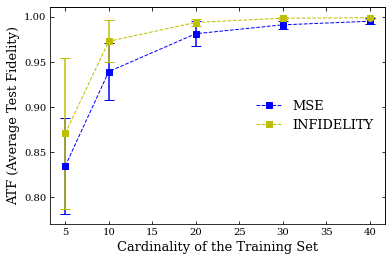

In [27]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

plt.figure(figsize = (6,4))
plt.plot(x, y, label='MSE', color='b', ls='dashed', marker='s', linewidth=1)
plt.errorbar(x, y, yerr = [predictions_5_std, predictions_10_std, predictions_20_std, predictions_30_std, predictions_40_std], fmt='o', color='b', capsize=5)
plt.errorbar(x, z, yerr = [inf_predictions_5_std, inf_predictions_10_std, inf_predictions_20_std, inf_predictions_30_std, inf_predictions_40_std], fmt='o', color='y', capsize=5)
plt.plot(x, z, label='INFIDELITY', color='y', ls='dashed', marker='s', linewidth=1)
ax = plt.subplot()

plt.xlabel("Cardinality of the Training Set", fontsize=13) 
plt.ylabel("ATF (Average Test Fidelity)", fontsize=13)
leg = plt.legend(fontsize=13, loc='center right', frameon='False')

secax = ax.secondary_xaxis('top')
secay = ax.secondary_yaxis('right')
ax.tick_params(axis="both", direction='in')
secax.tick_params(axis="x", direction="in")
secay.tick_params(axis="y", direction="in")
secax.set_xticklabels([])
secay.set_yticklabels([])


leg.get_frame().set_linewidth(0.0)

plt.savefig("md_oq.png")